<a href="https://colab.research.google.com/github/A00785001/TC5035/blob/main/004-Loop_Closure_Dataset_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loop Closure Dataset Generation: Time Alignment, Pairing & Labeling
## Phase 1.5: Supervised Learning Dataset Preparation for Jetson Nano Training Pipeline

**Version:** 6.10  
**Pipeline Phase:** Feature Extraction → **[THIS NOTEBOOK]** → Fusion MLP Training → Deployment  
**Target Hardware:** Waveshare Jetbot AI Pro Kit (Jetson Nano)  
**SLAM System:** Google Cartographer (2D)  
**Training Platform:** Vertex AI

---

---

# DOCUMENTATION

---



## NOTEBOOK DOCUMENTATION

### Purpose

This notebook transforms independently extracted multi-modal features (camera + LiDAR) into a supervised learning dataset for training a loop closure detection classifier. It bridges the gap between feature extraction and neural network training by performing temporal alignment, intelligent pairing, and ground truth labeling.

---

### Workflow Overview

**Phase 1A:** ROS Bag Validation (optional validation)
**Phase 1B:** Feature File Validation (HDF5 features)
**Phase 1C:** Pbstream Extraction
- Extract trajectory nodes with timestamps and poses
- Extract INTER_SUBMAP constraints (loop closures)
- Generate pairwise distance/time table for all nodes
- Temporal alignment: Match features to trajectory nodes

**Phase 2:** Dataset Generation
- Data profiling and automatic threshold suggestion
- Generate positive pairs (loop closures from distance + time filters)
- Generate easy negative pairs (spatially distant)
- Generate hard negative pairs (perceptually similar but distant)

**Phase 3:** Dataset Splitting & Validation
**Phase 4:** Save Dataset & Generate Report

---

### Folder Structure

**Expected Directory Layout:**

```
session_YYYYMMDD_HHMMSS/          (base working folder - your session)
├── map.pbstream                  ← INPUT: Cartographer pbstream file (REQUIRED)
├── session_data.bag              ← INPUT: ROS bag file (optional validation)
├── features/                     ← INPUT: Directory from feature extraction
│   └── features.h5               ← INPUT: Extracted features (HDF5)
└── dataset/                      ← OUTPUT: Created by this notebook
    ├── loop_closure_dataset.pkl  ← OUTPUT: Training dataset
    ├── dataset_diagnostics.png   ← OUTPUT: Visualization plots
    └── dataset_generation_report.txt ← OUTPUT: Summary report
```

**Note:** The `.pbstream` file is REQUIRED. Replace `session_YYYYMMDD_HHMMSS` with your actual session folder name.

---

### Required Inputs

#### 1. Pbstream File (REQUIRED)

**File:** `map.pbstream` (Cartographer SLAM state)

**Contents:**
- Trajectory nodes with full 6-DOF poses and timestamps
- INTER_SUBMAP constraints (loop closures detected by SLAM)
- Complete SLAM graph state

#### 2. Extracted Features (HDF5 Format)

**File:** `features/features.h5` (generated from feature extraction pipeline)

**Structure:**
```
features.h5
├── camera/
│   ├── features [N_cam, 1280]       # MobileNetV2 embeddings (L2 normalized, float32)
│   ├── timestamps_sec [N_cam]       # ROS timestamp seconds (int64)
│   ├── timestamps_nsec [N_cam]      # ROS timestamp nanoseconds (int32)
│   └── filenames [N_cam]            # Source image filenames (strings)
└── lidar/
    ├── features [N_lid, 256]        # 1D CNN descriptors (L2 normalized, float32)
    ├── timestamps_sec [N_lid]       # ROS timestamp seconds (int64)
    ├── timestamps_nsec [N_lid]      # ROS timestamp nanoseconds (int32)
    └── filenames [N_lid]            # Source scan filenames (strings)
```

---


---

## 🧠 HOW THIS NOTEBOOK WORKS: COMPREHENSIVE EXPLANATION

### The Problem We're Solving

**Loop closure detection** is critical for mobile robot SLAM. When a robot revisits a location, the system must recognize this "loop closure" to correct accumulated drift. This notebook creates a **supervised learning dataset** to train a neural network for loop closure detection using multi-modal sensor data.

**The Challenge:** Three independent data streams must be combined:
- Camera features (1280D MobileNetV2) at ~0.22 Hz
- LiDAR features (256D 1D-CNN) at ~0.7 Hz  
- SLAM ground truth (Cartographer trajectory + constraints)

These have **different rates**, **independent timestamps**, and **no pre-sync**.

---

### Why This Approach?

#### **1. Why INTER_SUBMAP Constraints?**

Cartographer's pose graph has two constraint types:
- **INTRA_SUBMAP**: Sequential (node j inserted into submap i)
- **INTER_SUBMAP**: Loop closures (node j NOT in submap i = robot returned)

**INTER_SUBMAP = gold standard** because:
- Cartographer solved loop closure via scan matching
- Passed rigorous geometric validation
- Verified spatial alignment (<2m, similar orientation)
- Residual provides confidence metric

#### **2. Why KD-Trees for Temporal Alignment?**

**Sensors operate independently:**
- Camera: ~4.5s intervals
- LiDAR: ~1.4s intervals
- Trajectory nodes: ~0.9 Hz

**KD-Tree solution:** O(log N) nearest-neighbor in time domain
```
For node at time T:
  → Find camera where |t_cam - T| < 0.5s
  → Find LiDAR where |t_lid - T| < 0.5s
  → Combine into multi-modal feature
```

**±700ms threshold** balances:
- Robot motion (~0.5m in 700ms at low speed)
- Sensor rate limits
- Pose uncertainty

#### **3. Why Three Pair Types?**

**Positive (30%)** - True loop closures from INTER_SUBMAP
- Teaches "same place" recognition

**Easy Negative (35%)** - Distance >5m + temporal gap >5s
- Teaches basic discrimination
- Temporal gap prevents consecutive-but-far frames

**Hard Negative (35%)** - High similarity (>0.7) BUT distant (>3m)
- Handles perceptual aliasing (corridors, symmetry)
- Most challenging cases

**Balanced 30/35/35** prevents:
- Trivial solutions ("always no")
- Easy case overfitting
- Perceptual aliasing failure

---

### Step-by-Step Workflow

#### **PHASE 0: Data Validation**

**HDF5 Analysis (1.1.5):** Feature stats, temporal coherence, quality checks
**Bag Analysis (1.2.5):** Trajectory distribution, INTER constraints, overlap

#### **PHASE 1: Feature-Trajectory Alignment**

**Step 1.1: Load Features**
```
camera_features: [N, 1280] L2-normalized
lidar_features: [N, 256] L2-normalized
timestamps: sec (int64) + nsec (int32)
```

**Step 1.2: Parse Trajectory Nodes**
```
From /trajectory_node_list (MarkerArray):
  node_id, timestamp, pose (x,y,z, qx,qy,qz,qw)
```

**Step 1.2.6: Parse INTER_SUBMAP Constraints**
```
From /constraint_list (MarkerArray):
  Filter: "Inter constraints" namespace only
  Match: constraint endpoints → trajectory nodes
  Validate: distance <2m, angle <90°, residual <0.5m
```

**Step 1.3: Temporal Alignment**
```
For each trajectory node at time T:
  cam_idx = nearest(camera_times, T) if |diff| < 0.5s
  lid_idx = nearest(lidar_times, T) if |diff| < 0.5s
  
  If both found:
    combined_feature = [cam_feat, lid_feat]  # [1536D]
    valid_nodes.append(node)
```

#### **PHASE 2: Intelligent Pairing**

**Step 2.1: Positive Pairs**
```
For (node_i, node_j) in INTER_SUBMAP_constraints:
  If both have combined_feature:
    pair = {features: [feat_i, feat_j], label: 1}
```

**Step 2.2: Easy Negatives**
```
Random sample nodes:
  Accept if: distance >5m AND time_gap >5s
```

**Step 2.3: Hard Negatives**
```
KD-Tree in feature space:
  Find similar features (cosine >0.7)
  Accept if: spatially distant (>3m)
```

#### **PHASE 3: Finalization**

- Combine + shuffle all pairs
- Stratified train/val/test split (60/20/20)
- Validation checks + statistics
- Save PKL + diagnostics + report

---

### 🛡️ Key Design Decisions

**±700ms threshold:**
- Too tight (<100ms): 60-80% data loss
- Too loose (>1s): Robot moves >1m, high uncertainty
- Sweet spot (700ms): <0.5m motion at low speed, better alignment coverage

**Float64 for timestamps:**
- Precision loss: ~250ns
- Threshold: 700,000,000ns
- Ratio: 5e-7 (negligible!)
- Store both: split (exact) + float (algorithms)

**Residual <0.5m filter:**
- High residual = weak constraint
- Filters false positives
- Keeps only high-quality ground truth

**35/35 easy/hard split:**
- Only easy: fails on aliasing
- Only hard: won't converge
- Balanced: stable training + generalization

**L2 normalization required:**
- Enables cosine similarity = dot product
- Network learns directions not magnitudes
- KD-tree works in normalized space

---

### ⚠️ Common Issues

**"No INTER_SUBMAP constraints"**
- Robot never looped back
- Solution: Re-record with intentional loops

**"Low alignment <50%"**
- Clock skew or wrong timestamps
- Solution: Verify bag recording, check timestamps

**"Features not normalized"**
- Extraction pipeline error
- Solution: Re-extract with normalization

**"Insufficient positives"**
- Too few validated constraints
- Solution: Relax thresholds or re-record

---

### Next Steps

**Output:** `loop_closure_dataset.pkl`
```
{'train': {features: [N,2,1536], labels: [N]},
 'val': {...},
 'test': {...},
 'config': {...},
 'statistics': {...}}
```

**1. Train Fusion MLP (Vertex AI)**
- Input: [2, 1536] paired features
- Architecture: MLP with dropout
- Output: Binary classifier

**2. Evaluate**
- Precision/Recall/F1
- ROC curves
- Per-type accuracy

**3. Deploy to Jetson Nano**
- TensorRT optimization
- Real-time inference (<50ms)
- Integrate with Cartographer

---

---

# SECTION 1: SETUP

Imports, configuration, thresholds.

---



## 1.1 IMPORTS AND DEPENDENCIES

In [1]:
# Install required packages
!pip install -q rosbags h5py scikit-learn matplotlib

print("✅ All packages installed successfully")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 37.7 MB/s eta 0:00:00
✅ All packages installed successfully


In [2]:
# System and file I/O
import os
import sys
import pickle
from pathlib import Path
import struct
import zlib
from google.protobuf.internal.decoder import _DecodeVarint32, _DecodeVarint
from google.colab import drive

# Numerical computing
import numpy as np
from scipy.spatial import KDTree
from scipy.spatial.transform import Rotation
# Data handling
import h5py
import pandas as pd # Added pandas import
# ROS bag processing
from rosbags.rosbag1 import Reader
from rosbags.typesys import get_typestore, Stores
# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
# Progress tracking
from tqdm import tqdm
# Random state for reproducibility
import random
print("✅ All imports successful")
print(f"   NumPy version: {np.__version__}")
print(f"   Python version: {sys.version.split()[0]}")

✅ All imports successful
   NumPy version: 2.0.2
   Python version: 3.12.12


## 1.2 WORKING DIRECTORY CONFIGURATION

---

# SECTION 2: STORAGE MOUNTING

Google Drive mount.

---



In [3]:
# Detect environment
try:
    import google.colab
    IN_COLAB = True
    print(" Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print(" Running in local environment")

# Mount Google Drive if in Colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✅ Google Drive mounted")



 Running in Google Colab
Mounted at /content/drive
✅ Google Drive mounted


In [4]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
print(f"\n Random seed set to: {RANDOM_SEED}")

# Time alignment parameters
MAX_TIME_OFFSET = 0.7  # seconds - maximum time difference for feature-node matching
MIN_TEMPORAL_GAP = 5.0  # seconds - minimum time between frames for negative pairs

# Spatial thresholds
POSITIVE_DISTANCE_THRESHOLD = 0.3  # meters - UPDATED for 3m x 2m environment
EASY_NEGATIVE_MIN_DISTANCE = 1.0  # meters - UPDATED for small indoor space
HARD_NEGATIVE_MIN_DISTANCE = 3.0  # meters - minimum distance for hard negatives

POSITIVE_TIME_GAP = 10.0  # seconds - minimum time between loop closure pairs
# Cartographer validation thresholds
MAX_CONSTRAINT_RESIDUAL = 0.5  # meters - maximum constraint error for validation
MAX_ANGULAR_DISTANCE = np.pi / 2  # radians - maximum angular difference for loop closure

# Pairing strategy - Option 2: Hard-focused ratios (relative to positive count)
EASY_NEGATIVE_RATIO = 0.75   # 0.75x positives (22% of final dataset)
HARD_NEGATIVE_RATIO = 1.25   # 1.25x positives (48% of final dataset)
# Positives will be 30% of final dataset

# Hard negative mining
HARD_NEGATIVE_SIMILARITY_THRESHOLD = 0.7  # cosine similarity threshold for perceptual aliasing
HARD_NEGATIVE_SIMILARITY_FALLBACK = [0.7, 0.65, 0.6, 0.55]  # Fallback thresholds if insufficient hard negatives

# Easy negative sampling
EASY_NEG_MIN_TEMPORAL_GAP = 5.0  # seconds - minimum time gap for easy negatives
STRATIFY_DISTANCE_BINS = [1.0, 1.5, 2.0, np.inf]  # meters - distance bins for stratified sampling
# Split ratios (stratified random)
TRAIN_RATIO = 0.60
VAL_RATIO = 0.20
TEST_RATIO = 0.20

print("\n⚙️ Algorithm Parameters:")
print(f"  Time alignment: ±{MAX_TIME_OFFSET}s")
print(f"  Positive threshold: <{POSITIVE_DISTANCE_THRESHOLD}m")
print(f"  Easy negative: >{EASY_NEGATIVE_MIN_DISTANCE}m")
print(f"  Hard negative: >{HARD_NEGATIVE_MIN_DISTANCE}m, similarity >{HARD_NEGATIVE_SIMILARITY_THRESHOLD}")
print(f"  Constraint validation: residual <{MAX_CONSTRAINT_RESIDUAL}m, angle <{MAX_ANGULAR_DISTANCE:.2f} rad")
print(f"  Negative sampling ratios: {EASY_NEGATIVE_RATIO:.2f}x easy / {HARD_NEGATIVE_RATIO:.2f}x hard (relative to positives)")
print(f"  Split ratios: {TRAIN_RATIO:.0%} train / {VAL_RATIO:.0%} val / {TEST_RATIO:.0%} test")


 Random seed set to: 42

⚙️ Algorithm Parameters:
  Time alignment: ±0.7s
  Positive threshold: <0.3m
  Easy negative: >1.0m
  Hard negative: >3.0m, similarity >0.7
  Constraint validation: residual <0.5m, angle <1.57 rad
  Negative sampling ratios: 0.75x easy / 1.25x hard (relative to positives)
  Split ratios: 60% train / 20% val / 20% test


In [5]:
# Configure session folder
SESSION_ID = 'session_20251022_155137'  # ← CHANGE THIS to your session folder name

if IN_COLAB:
    # Google Colab: Assume data is in Drive
    BASE_PATH = f'/content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/{SESSION_ID}'
else:
    # Local: Use current directory or specify path
    BASE_PATH = f'./{SESSION_ID}'  # Or specify full path: '/path/to/data/{SESSION_ID}'

# Change to working directory
os.chdir(BASE_PATH)
print(f"\n Working directory: {os.getcwd()}")
print(f"   Session ID: {SESSION_ID}")


 Working directory: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137
   Session ID: session_20251022_155137


In [6]:
# File Paths Configuration
print("=" * 70)
print("FILE PATHS CONFIGURATION")
print("=" * 70)

# Input directories and files (relative to working folder)
FEATURES_DIR = 'features'
FEATURES_FILE = os.path.join(FEATURES_DIR, 'features.h5')
BAG_FILE = 'session_data.bag'  # In base working folder
PBSTREAM_FILE = 'map.pbstream'  # Optional, in base working folder

# Output directory for dataset
OUTPUT_DIR = 'dataset'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Output files
DATASET_FILE = os.path.join(OUTPUT_DIR, 'loop_closure_dataset.pkl')
DIAGNOSTICS_FILE = os.path.join(OUTPUT_DIR, 'dataset_diagnostics.png')
REPORT_FILE = os.path.join(OUTPUT_DIR, 'dataset_generation_report.txt')

print("\n Input Configuration:")
print(f"  Features directory: {FEATURES_DIR}")
print(f"  Features file: {FEATURES_FILE}")
print(f"  ROS bag file: {BAG_FILE}")
print(f"  Pbstream file: {PBSTREAM_FILE}")

print("\n Output Configuration:")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Dataset file: {DATASET_FILE}")
print(f"  Diagnostics plot: {DIAGNOSTICS_FILE}")
print(f"  Report file: {REPORT_FILE}")



FILE PATHS CONFIGURATION

 Input Configuration:
  Features directory: features
  Features file: features/features.h5
  ROS bag file: session_data.bag
  Pbstream file: map.pbstream

 Output Configuration:
  Output directory: dataset
  Dataset file: dataset/loop_closure_dataset.pkl
  Diagnostics plot: dataset/dataset_diagnostics.png
  Report file: dataset/dataset_generation_report.txt


In [7]:
# Verify input files exist
print("\n Verifying input files...")
if os.path.exists(FEATURES_FILE):
    print(f"  ✓ Features file found: {FEATURES_FILE}")
else:
    print(f"  ❌ Features file NOT found: {FEATURES_FILE}")
    raise FileNotFoundError(f"Required file not found: {FEATURES_FILE}")

if os.path.exists(BAG_FILE):
    print(f"  ✓ ROS bag file found: {BAG_FILE}")
else:
    print(f"  ❌ ROS bag file NOT found: {BAG_FILE}")
    raise FileNotFoundError(f"Required file not found: {BAG_FILE}")

if os.path.exists(PBSTREAM_FILE):
    print(f"  ✓ Pbstream file found: {PBSTREAM_FILE}")
else:
    print(f"  ℹ Pbstream file not found (optional): {PBSTREAM_FILE}")

print("=" * 70)


 Verifying input files...
  ✓ Features file found: features/features.h5
  ✓ ROS bag file found: session_data.bag
  ✓ Pbstream file found: map.pbstream


---

# SECTION 3: PBSTREAM LOADING & EXTRACTION

Trajectory, constraints, pairwise data.

---



## 3.1 SECTION DOCUMENTATION

### 1C.1 Pbstream Extraction Functions

These functions parse the Cartographer `.pbstream` file (protobuf format) to extract:
- Trajectory nodes with timestamps and poses
- INTER_SUBMAP constraints (loop closures)
- Pairwise node distances and time differences


## 3.2 Cartographer PBSTREAM Format Documentation



## 🏗️ File Structure

```
PBSTREAM FILE
├─ [8-byte header]
└─ [Messages]* (repeated)
   ├─ 8 bytes: message length (uint64, little-endian)
   └─ N bytes: gzip-compressed protobuf message
```

---

## 📋 Message Types

### 1. POSE_GRAPH (Field 1)
Complete optimized graph structure containing all trajectories, nodes, submaps, and loop closure constraints after SLAM optimization.

**Typical Count:** 1-2 messages (usually at end of file)

### 2. ALL_TRAJECTORY_BUILDER_OPTIONS (Field 2)
SLAM algorithm configuration parameters and tuning settings.

**Typical Count:** 1 message (at start of file)

### 3. SUBMAP (Field 3)
2D/3D probability grids representing mapped areas. Each submap is a tile of the complete map.

### 4. NODE (Field 4) ⭐ PRIMARY DATA
Trajectory nodes containing robot pose, timestamp, and sensor data at each mapping step.

### 5. TRAJECTORY_DATA (Field 5)
Metadata about trajectories (IDs, relationships between multiple trajectories).

### 6. IMU_DATA (Field 6)
IMU sensor readings (accelerometer, gyroscope) if IMU was used during mapping.

---

## 🎯 NODE Structure (Field 4) - DETAILED

This is the **primary data structure** containing pose and sensor information.

```
NODE (Field 4)
├─ Field 1: Node metadata (usually empty, 0-2 bytes)
└─ Field 5: POSE DATA
   ├─ Field 1: TIMESTAMP (int64 varint)
   │   └─ Format: 100-nanosecond ticks since Windows epoch (1601-01-01)
   │   └─ Conversion: (timestamp - 621355968000000000) / 10000000 = Unix seconds
   │
   ├─ Field 2: Metadata (9-18 bytes, varies by node)
   ├─ Field 3: POINT CLOUD DATA (600-950 bytes, raw LIDAR scan)
   ├─ Field 4: (empty)
   ├─ Field 5: (empty)
   │
   └─ Field 7: POSE (TRANSFORM)
      ├─ Field 1: TRANSLATION
      │  ├─ Field 1: x (double) - meters
      │  ├─ Field 2: y (double) - meters
      │  └─ Field 3: z (double) - meters
      │
      └─ Field 2: ROTATION (quaternion)
         ├─ Field 1: x (double)
         ├─ Field 2: y (double)
         ├─ Field 3: z (double)
         └─ Field 4: w (double) - normalized
```

---

## 🔧 Protobuf Wire Types

| Wire Type | Name | Description |
|-----------|------|-------------|
| 0 | VARINT | Variable-length integer (int32, int64, uint32, uint64, bool, enum) |
| 1 | 64BIT | Fixed 8 bytes (double, fixed64, sfixed64) |
| 2 | LENGTH_DELIM | Length-prefixed (string, bytes, nested messages, packed repeated) |
| 5 | 32BIT | Fixed 4 bytes (float, fixed32, sfixed32) |

---

## 📚 Important Notes

- **Timestamp Format:** Cartographer uses "Universal Time" (100-nanosecond ticks since Windows epoch)
- **Coordinate System:** Right-handed with Z-up (typical for 2D: z=0)
- **Quaternions:** Stored as (x, y, z, w) and are normalized (magnitude = 1.0)
- **Compression:** All messages are gzip-compressed with window bits = 16 + MAX_WBITS
- **Endianness:** Little-endian for all multi-byte values
- **Field Numbers:** In protobuf, field numbers 1-15 use 1 byte, 16+ use 2+ bytes

---

## 3.3 Helper Functions (ORIGINAL - DO NOT MODIFY)

In [8]:
def extract_xy(field5_data):
    pos = 0
    x = y = None
    while pos < len(field5_data):
        try:
            tag, pos = _DecodeVarint32(field5_data, pos)
            fn = tag >> 3
            wt = tag & 0x7
            if fn == 7 and wt == 2:
                length, pos = _DecodeVarint32(field5_data, pos)
                f7_data = field5_data[pos:pos + length]
                f7_pos = 0
                while f7_pos < len(f7_data):
                    try:
                        f7_tag, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                        f7_fn = f7_tag >> 3
                        f7_wt = f7_tag & 0x7
                        if f7_fn == 1 and f7_wt == 2:
                            tl, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                            td = f7_data[f7_pos:f7_pos + tl]
                            tp = 0
                            while tp < len(td):
                                try:
                                    tt, tp = _DecodeVarint32(td, tp)
                                    tf = tt >> 3
                                    tw = tt & 0x7
                                    if tw == 1 and tp + 8 <= len(td):
                                        val = struct.unpack('<d', td[tp:tp+8])[0]
                                        if tf == 1:
                                            x = val
                                        elif tf == 2:
                                            y = val
                                        tp += 8
                                    else:
                                        break
                                except:
                                    break
                            f7_pos += tl
                            break
                        elif f7_wt == 2:
                            l2, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                            f7_pos += l2
                        else:
                            break
                    except:
                        break
                pos += length
                break
            elif wt == 0:
                _, pos = _DecodeVarint32(field5_data, pos)
            elif wt == 1:
                pos += 8
            elif wt == 2:
                l, pos = _DecodeVarint32(field5_data, pos)
                pos += l
            elif wt == 5:
                pos += 4
            else:
                break
        except:
            break
    return x, y


def extract_timestamp(node_data):
    """Extract timestamp from Field 1 (node ID message)"""
    pos = 0
    while pos < len(node_data):
        try:
            tag, pos = _DecodeVarint32(node_data, pos)
            fn = tag >> 3
            wt = tag & 0x7

            # Timestamp is inside Field 5 (pose), not Field 1!
            if fn == 5 and wt == 2:
                length, pos = _DecodeVarint32(node_data, pos)
                field1_data = node_data[pos:pos + length]
                f1_pos = 0
                while f1_pos < len(field1_data):
                    try:
                        f1_tag, f1_pos = _DecodeVarint32(field1_data, f1_pos)
                        f1_fn = f1_tag >> 3
                        f1_wt = f1_tag & 0x7
                        if f1_fn == 1 and f1_wt == 0:  # Timestamp
                            timestamp, f1_pos = _DecodeVarint(field1_data, f1_pos)
                            return timestamp
                        elif f1_wt == 0:
                            _, f1_pos = _DecodeVarint32(field1_data, f1_pos)
                        elif f1_wt == 1:
                            f1_pos += 8
                        elif f1_wt == 2:
                            l, f1_pos = _DecodeVarint32(field1_data, f1_pos)
                            f1_pos += l
                        elif f1_wt == 5:
                            f1_pos += 4
                        else:
                            break
                    except:
                        break
                return None
            elif wt == 0:
                _, pos = _DecodeVarint32(node_data, pos)
            elif wt == 1:
                pos += 8
            elif wt == 2:
                l, pos = _DecodeVarint32(node_data, pos)
                pos += l
            elif wt == 5:
                pos += 4
            else:
                break
        except:
            break
    return None


In [9]:
def extract_full_pose(field5_data):
    """Extract full pose: x, y, z, quat_x, quat_y, quat_z, quat_w, timestamp"""
    pos = 0
    x = y = z = qx = qy = qz = qw = timestamp = None

    while pos < len(field5_data):
        try:
            tag, pos = _DecodeVarint32(field5_data, pos)
            fn = tag >> 3
            wt = tag & 0x7

            if fn == 1 and wt == 0:  # Timestamp
                timestamp, pos = _DecodeVarint(field5_data, pos)

            elif fn == 7 and wt == 2:  # Pose
                length, pos = _DecodeVarint32(field5_data, pos)
                f7_data = field5_data[pos:pos + length]
                f7_pos = 0

                while f7_pos < len(f7_data):
                    try:
                        f7_tag, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                        f7_fn = f7_tag >> 3
                        f7_wt = f7_tag & 0x7

                        if f7_fn == 1 and f7_wt == 2:  # Translation
                            tl, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                            td = f7_data[f7_pos:f7_pos + tl]
                            tp = 0
                            while tp < len(td):
                                try:
                                    tt, tp = _DecodeVarint32(td, tp)
                                    tf = tt >> 3
                                    tw = tt & 0x7
                                    if tw == 1 and tp + 8 <= len(td):
                                        val = struct.unpack('<d', td[tp:tp+8])[0]
                                        if tf == 1: x = val
                                        elif tf == 2: y = val
                                        elif tf == 3: z = val
                                        tp += 8
                                    else:
                                        break
                                except:
                                    break
                            f7_pos += tl

                        elif f7_fn == 2 and f7_wt == 2:  # Rotation
                            rl, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                            rd = f7_data[f7_pos:f7_pos + rl]
                            rp = 0
                            while rp < len(rd):
                                try:
                                    rt, rp = _DecodeVarint32(rd, rp)
                                    rf = rt >> 3
                                    rw = rt & 0x7
                                    if rw == 1 and rp + 8 <= len(rd):
                                        val = struct.unpack('<d', rd[rp:rp+8])[0]
                                        if rf == 1: qx = val
                                        elif rf == 2: qy = val
                                        elif rf == 3: qz = val
                                        elif rf == 4: qw = val
                                        rp += 8
                                    else:
                                        break
                                except:
                                    break
                            f7_pos += rl

                        elif f7_wt == 2:
                            l, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                            f7_pos += l
                        else:
                            break
                    except:
                        break
                pos += length

            elif wt == 0:
                _, pos = _DecodeVarint32(field5_data, pos)
            elif wt == 1:
                pos += 8
            elif wt == 2:
                l, pos = _DecodeVarint32(field5_data, pos)
                pos += l
            elif wt == 5:
                pos += 4
            else:
                break
        except:
            break

    return x, y, z, qx, qy, qz, qw, timestamp


## 3.4 FILE VALIDATION
---

In [10]:
PBSTREAM_FILE = os.path.join(BASE_PATH, "map.pbstream")
print(f"Pbstream file: {PBSTREAM_FILE}")


Pbstream file: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/map.pbstream


In [11]:
print("🔍 VALIDATING PBSTREAM FILE...\n")

with open(PBSTREAM_FILE, 'rb') as f:
    data = f.read()

print(f"File size: {len(data):,} bytes ({len(data)/1024/1024:.2f} MB)")
print(f"Header: {' '.join(f'{b:02x}' for b in data[:8])}")
print()

# Count message types
pos = 8
msg_types = {}
first_node = None

while pos < len(data):
    try:
        if pos + 8 > len(data): break
        msg_len = struct.unpack('<Q', data[pos:pos+8])[0]
        pos += 8
        if msg_len == 0 or pos + msg_len > len(data): break
        compressed = data[pos:pos + msg_len]
        pos += msg_len
        try:
            msg_data = zlib.decompress(compressed, 16 + zlib.MAX_WBITS)
        except: continue
        if len(msg_data) < 2: continue
        tag, _ = _DecodeVarint32(msg_data, 0)
        field_num = tag >> 3
        msg_types[field_num] = msg_types.get(field_num, 0) + 1

        # Capture first node for timestamp example
        if field_num == 4 and first_node is None:
            node_pos = 0
            tag, node_pos = _DecodeVarint32(msg_data, node_pos)
            node_len, node_pos = _DecodeVarint32(msg_data, node_pos)
            first_node = msg_data[node_pos:node_pos + node_len]
    except: break

msg_names = {1: 'POSE_GRAPH', 2: 'BUILDER_OPTIONS', 3: 'SUBMAP', 4: 'NODE'}
print("✅ Message counts:")
for fn in sorted(msg_types.keys()):
    name = msg_names.get(fn, f'UNKNOWN_{fn}')
    print(f"   {name:20} (Field {fn}): {msg_types[fn]:,}")

# Show timestamp conversion example from first node
if first_node:
    timestamp = extract_timestamp(first_node)
    if timestamp:
        print(f"\n✅ Timestamp example (first node):")
        print(f"   Raw ticks (Year 1 epoch): {timestamp}")
        # Convert: ticks × 100 → ns since Year 1, then subtract offset to Unix epoch
        ns_since_year1 = timestamp * 100
        unix_ns = ns_since_year1 - 62135596800000000000
        timestamp_secs = unix_ns // 1_000_000_000
        timestamp_nsecs = unix_ns % 1_000_000_000
        print(f"   Unix timestamp: {timestamp_secs} seconds")
        print(f"   Nanoseconds in second: {timestamp_nsecs} ns")

        import datetime
        dt = datetime.datetime.fromtimestamp(timestamp_secs)
        print(f"   Date/time: {dt.strftime('%Y-%m-%d %H:%M:%S')}.{timestamp_nsecs//1000000:03d}")

print(f"\n✅ File structure: Valid")

🔍 VALIDATING PBSTREAM FILE...

File size: 2,800,733 bytes (2.67 MB)
Header: db 01 f5 5b 7b 1f 1d 7b

✅ Message counts:
   POSE_GRAPH           (Field 1): 2
   BUILDER_OPTIONS      (Field 2): 1
   SUBMAP               (Field 3): 36
   NODE                 (Field 4): 1,256

✅ Timestamp example (first node):
   Raw ticks (Year 1 epoch): 638967723732811315
   Unix timestamp: 1761175573 seconds
   Nanoseconds in second: 281131500 ns
   Date/time: 2025-10-22 23:26:13.281

✅ File structure: Valid


---
## 3.5 TRAJECTORY EXTRACTION AND ANALYSIS
---

In [12]:
print("🛤️ EXTRACTING TRAJECTORY DATA...\n")

with open(PBSTREAM_FILE, 'rb') as f:
    data = f.read()

pos = 8
trajectory_data = []
node_idx = 0

while pos < len(data):
    try:
        if pos + 8 > len(data): break
        msg_len = struct.unpack('<Q', data[pos:pos+8])[0]
        pos += 8
        if msg_len == 0 or pos + msg_len > len(data): break
        compressed = data[pos:pos + msg_len]
        pos += msg_len

        try:
            msg_data = zlib.decompress(compressed, 16 + zlib.MAX_WBITS)
        except:
            continue

        if len(msg_data) < 2: continue
        tag, _ = _DecodeVarint32(msg_data, 0)
        field_num = tag >> 3

        if field_num == 4:  # NODE
            node_pos = 0
            tag, node_pos = _DecodeVarint32(msg_data, node_pos)
            node_len, node_pos = _DecodeVarint32(msg_data, node_pos)
            node_data = msg_data[node_pos:node_pos + node_len]

            # Find Field 5
            inner_pos = 0
            while inner_pos < len(node_data):
                tag, inner_pos = _DecodeVarint32(node_data, inner_pos)
                fn = tag >> 3
                wt = tag & 0x7
                if fn == 5 and wt == 2:
                    f5_len, inner_pos = _DecodeVarint32(node_data, inner_pos)
                    f5_data = node_data[inner_pos:inner_pos + f5_len]

                    x, y, z, qx, qy, qz, qw, timestamp = extract_full_pose(f5_data)

                    if x is not None and y is not None:
                        if timestamp:
                            # Convert: ticks × 100 → ns since Year 1, subtract offset for Unix epoch
                            ns_since_year1 = timestamp * 100
                            unix_ns = ns_since_year1 - 62135596800000000000
                            timestamp_secs = int(unix_ns // 1_000_000_000)
                            timestamp_nsecs = int(unix_ns % 1_000_000_000)
                        else:
                            timestamp_secs = None
                            timestamp_nsecs = None

                        trajectory_data.append({
                            'node_id': node_idx,
                            'timestamp_secs': timestamp_secs,
                            'timestamp_nsecs': timestamp_nsecs,
                            'x_m': x,
                            'y_m': y,
                            'z_m': z if z is not None else 0.0,
                            'quat_x': qx if qx is not None else 0.0,
                            'quat_y': qy if qy is not None else 0.0,
                            'quat_z': qz if qz is not None else 0.0,
                            'quat_w': qw if qw is not None else 1.0
                        })
                        node_idx += 1
                    break
                elif wt == 0:
                    _, inner_pos = _DecodeVarint32(node_data, inner_pos)
                elif wt == 1:
                    inner_pos += 8
                elif wt == 2:
                    l, inner_pos = _DecodeVarint32(node_data, inner_pos)
                    inner_pos += l
                elif wt == 5:
                    inner_pos += 4
    except:
        break

df_trajectory = pd.DataFrame(trajectory_data)

# Ensure timestamp columns are integers
if len(df_trajectory) > 0:
    df_trajectory['timestamp_secs'] = df_trajectory['timestamp_secs'].fillna(0).astype(int)
    df_trajectory['timestamp_nsecs'] = df_trajectory['timestamp_nsecs'].fillna(0).astype(int)


print(f"✅ Extracted: {len(df_trajectory)} nodes")
print(f"\n📝 Timestamp format:")
print(f"   timestamp_secs: Unix timestamp (seconds since 1970-01-01)")
print(f"   timestamp_nsecs: Nanoseconds within that second (0-999,999,999)")
print(f"\n📋 First 5 rows:")
display(df_trajectory.head())
print(f"\n📋 Last 5 rows:")
display(df_trajectory.tail())

🛤️ EXTRACTING TRAJECTORY DATA...

✅ Extracted: 1255 nodes

📝 Timestamp format:
   timestamp_secs: Unix timestamp (seconds since 1970-01-01)
   timestamp_nsecs: Nanoseconds within that second (0-999,999,999)

📋 First 5 rows:


,node_id,timestamp_secs,timestamp_nsecs,x_m,y_m,z_m,quat_x,quat_y,quat_z,quat_w
0,0,1761175578,341865800,-0.001466,0.004393,0.0,0.0,0.0,0.001625,0.999999
1,1,1761175578,476540500,-0.003856,0.002816,0.0,0.0,0.0,0.017387,0.999849
2,2,1761175578,611894500,0.001183,0.002219,0.0,0.0,0.0,0.030296,0.999541
3,3,1761175578,867448600,0.041088,0.004711,0.0,0.0,0.0,0.006010,0.999982
4,4,1761175579,2461300,0.076415,0.010777,0.0,0.0,0.0,-0.005306,0.999986



📋 Last 5 rows:


,node_id,timestamp_secs,timestamp_nsecs,x_m,y_m,z_m,quat_x,quat_y,quat_z,quat_w
1250,1250,1761175962,839079300,2.844030,6.390513,0.0,0.0,0.0,0.876729,-0.480985
1251,1251,1761175963,632571600,2.768131,6.164998,0.0,0.0,0.0,0.879331,-0.476211
1252,1252,1761175963,902584000,2.712850,6.092377,0.0,0.0,0.0,0.885523,-0.464595
1253,1253,1761175964,296024600,2.607575,6.054640,0.0,0.0,0.0,0.891796,-0.452439
1254,1254,1761175964,946802100,2.464423,6.084261,0.0,0.0,0.0,0.897377,-0.441265


### 3.4.1 Trajectory Visualization & Bounding Box


TRAJECTORY VISUALIZATION

📐 MAP BOUNDING BOX:
   X-axis: [-1.274, 3.534] m
   Y-axis: [-0.757, 7.812] m
   Width:  4.808 m
   Height: 8.568 m
   Diagonal (max possible distance): 9.825 m



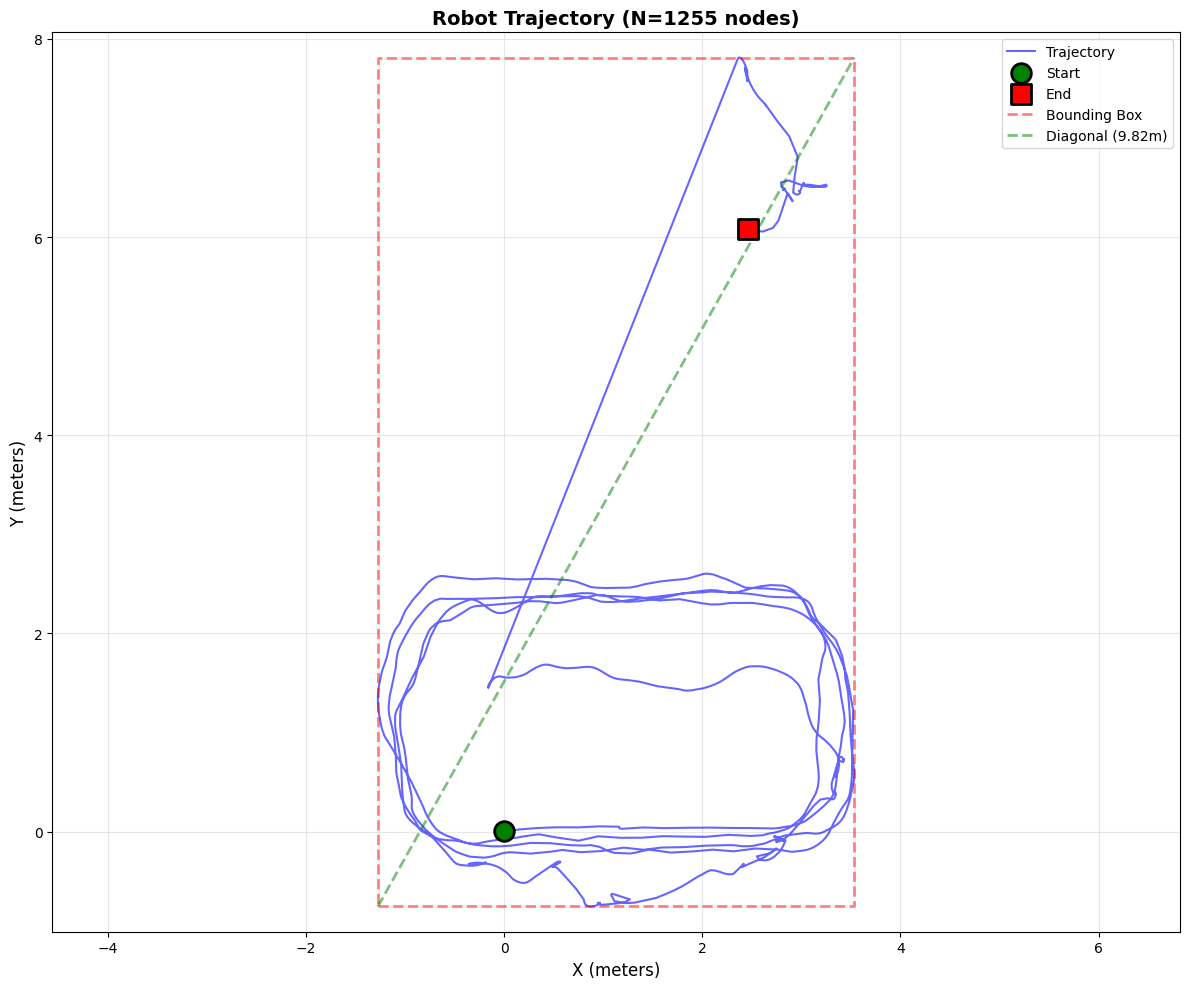

✅ Trajectory visualization complete


In [13]:
print("\n" + "="*70)
print("TRAJECTORY VISUALIZATION")
print("="*70 + "\n")

# Extract coordinates
x_coords = df_trajectory['x_m'].values
y_coords = df_trajectory['y_m'].values

# Calculate bounding box
min_x, max_x = x_coords.min(), x_coords.max()
min_y, max_y = y_coords.min(), y_coords.max()
width = max_x - min_x
height = max_y - min_y
diagonal = np.sqrt(width**2 + height**2)

print("📐 MAP BOUNDING BOX:")
print(f"   X-axis: [{min_x:.3f}, {max_x:.3f}] m")
print(f"   Y-axis: [{min_y:.3f}, {max_y:.3f}] m")
print(f"   Width:  {width:.3f} m")
print(f"   Height: {height:.3f} m")
print(f"   Diagonal (max possible distance): {diagonal:.3f} m\n")

# Create visualization
fig, ax = plt.subplots(figsize=(12, 10))

# Plot trajectory
ax.plot(x_coords, y_coords, 'b-', linewidth=1.5, alpha=0.6, label='Trajectory')
ax.scatter(x_coords[0], y_coords[0], c='green', s=200, marker='o',
           edgecolors='black', linewidths=2, label='Start', zorder=5)
ax.scatter(x_coords[-1], y_coords[-1], c='red', s=200, marker='s',
           edgecolors='black', linewidths=2, label='End', zorder=5)

# Plot bounding box
ax.plot([min_x, max_x, max_x, min_x, min_x],
        [min_y, min_y, max_y, max_y, min_y],
        'r--', linewidth=2, alpha=0.5, label='Bounding Box')

# Plot diagonal
ax.plot([min_x, max_x], [min_y, max_y], 'g--', linewidth=2, alpha=0.5,
        label=f'Diagonal ({diagonal:.2f}m)')

ax.set_xlabel('X (meters)', fontsize=12)
ax.set_ylabel('Y (meters)', fontsize=12)
ax.set_title(f'Robot Trajectory (N={len(df_trajectory)} nodes)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.axis('equal')

plt.tight_layout()
plt.show()

print("✅ Trajectory visualization complete")

In [14]:
# Verify timestamp format
print("🔍 TIMESTAMP VERIFICATION\n")

import datetime
import pytz

# First node
sample = df_trajectory.iloc[0]
print(f"Sample node (first):")
print(f"   timestamp_secs: {sample['timestamp_secs']} (type: {type(sample['timestamp_secs']).__name__})")
print(f"   timestamp_nsecs: {sample['timestamp_nsecs']} (type: {type(sample['timestamp_nsecs']).__name__})")

if sample['timestamp_secs'] is not None:
    nsecs = int(sample['timestamp_nsecs']) if sample['timestamp_nsecs'] is not None else 0
    dt_utc = datetime.datetime.fromtimestamp(int(sample['timestamp_secs']), tz=pytz.UTC)
    dt_monterrey = dt_utc.astimezone(pytz.timezone('America/Monterrey'))
    print(f"   Readable UTC: {dt_utc.strftime('%Y-%m-%d %H:%M:%S')}.{nsecs//1000000:03d}")
    print(f"   Readable (America/Monterrey - {dt_monterrey.tzname()}): {dt_monterrey.strftime('%Y-%m-%d %H:%M:%S')}.{nsecs//1000000:03d}")

# Last node
sample_last = df_trajectory.iloc[-1]
print(f"\nSample node (last):")
print(f"   timestamp_secs: {sample_last['timestamp_secs']} (type: {type(sample_last['timestamp_secs']).__name__})")
print(f"   timestamp_nsecs: {sample_last['timestamp_nsecs']} (type: {type(sample_last['timestamp_nsecs']).__name__})")

if sample_last['timestamp_secs'] is not None:
    nsecs_last = int(sample_last['timestamp_nsecs']) if sample_last['timestamp_nsecs'] is not None else 0
    dt_utc_last = datetime.datetime.fromtimestamp(int(sample_last['timestamp_secs']), tz=pytz.UTC)
    dt_monterrey_last = dt_utc_last.astimezone(pytz.timezone('America/Monterrey'))
    print(f"   Readable UTC: {dt_utc_last.strftime('%Y-%m-%d %H:%M:%S')}.{nsecs_last//1000000:03d}")
    print(f"   Readable (America/Monterrey - {dt_monterrey_last.tzname()}): {dt_monterrey_last.strftime('%Y-%m-%d %H:%M:%S')}.{nsecs_last//1000000:03d}")

print(f"\n✅ Timestamps correctly formatted as (seconds, nanoseconds)")


🔍 TIMESTAMP VERIFICATION

Sample node (first):
   timestamp_secs: 1761175578.0 (type: float64)
   timestamp_nsecs: 341865800.0 (type: float64)
   Readable UTC: 2025-10-22 23:26:18.341
   Readable (America/Monterrey - CST): 2025-10-22 17:26:18.341

Sample node (last):
   timestamp_secs: 1761175964.0 (type: float64)
   timestamp_nsecs: 946802100.0 (type: float64)
   Readable UTC: 2025-10-22 23:32:44.946
   Readable (America/Monterrey - CST): 2025-10-22 17:32:44.946

✅ Timestamps correctly formatted as (seconds, nanoseconds)


In [15]:
# Trajectory profiling - consecutive nodes
print("\n📊 TRAJECTORY PROFILING (CONSECUTIVE NODES)\n")


# Calculate distances and time differences between consecutive nodes
consecutive_distances = []
consecutive_times = []

for i in range(len(df_trajectory) - 1):
    node1 = df_trajectory.iloc[i]
    node2 = df_trajectory.iloc[i + 1]

    # Distance
    dist = np.sqrt((node2['x_m'] - node1['x_m'])**2 + (node2['y_m'] - node1['y_m'])**2)
    consecutive_distances.append(dist)

    # Time difference
    if node1['timestamp_secs'] is not None and node2['timestamp_secs'] is not None:
        time_diff_ns = (
            (node2['timestamp_secs'] - node1['timestamp_secs']) * 1_000_000_000 +
            (node2['timestamp_nsecs'] - node1['timestamp_nsecs'])
        )
        time_diff_secs = time_diff_ns / 1_000_000_000
        consecutive_times.append(time_diff_secs)

consecutive_distances = np.array(consecutive_distances)
consecutive_times = np.array(consecutive_times)


# Statistics table
print("\n📈 DESCRIPTIVE STATISTICS\n")
print("Distance Between Consecutive Nodes (meters):")
print(f"   Count:  {len(consecutive_distances)}")
print(f"   Min:    {consecutive_distances.min():.6f} m")
print(f"   Max:    {consecutive_distances.max():.6f} m")
print(f"   Mean:   {consecutive_distances.mean():.6f} m")
print(f"   Median: {np.median(consecutive_distances):.6f} m")
print(f"   Std:    {consecutive_distances.std():.6f} m")

print("\nTime Between Consecutive Nodes (seconds):")
print(f"   Count:  {len(consecutive_times)}")
print(f"   Min:    {consecutive_times.min():.6f} s")
print(f"   Max:    {consecutive_times.max():.6f} s")
print(f"   Mean:   {consecutive_times.mean():.6f} s")
print(f"   Median: {np.median(consecutive_times):.6f} s")
print(f"   Std:    {consecutive_times.std():.6f} s")

print("\nTrajectory Velocity Profile:")
velocities = consecutive_distances / consecutive_times
print(f"   Mean velocity:   {velocities.mean():.6f} m/s")
print(f"   Median velocity: {np.median(velocities):.6f} m/s")
print(f"   Max velocity:    {velocities.max():.6f} m/s")


📊 TRAJECTORY PROFILING (CONSECUTIVE NODES)


📈 DESCRIPTIVE STATISTICS

Distance Between Consecutive Nodes (meters):
   Count:  1254
   Min:    0.000845 m
   Max:    6.828017 m
   Mean:   0.058617 m
   Median: 0.034281 m
   Std:    0.199323 m

Time Between Consecutive Nodes (seconds):
   Count:  1254
   Min:    0.114630 s
   Max:    48.649355 s
   Mean:   0.308297 s
   Median: 0.135182 s
   Std:    1.420958 s

Trajectory Velocity Profile:
   Mean velocity:   0.214999 m/s
   Median velocity: 0.239200 m/s
   Max velocity:    0.460624 m/s


---
## 3.6 NODE PAIRING
---

In [16]:
print("\n🔗 CREATING ALL NODE PAIRS...\n")
print("⚠️  Creating ~786,885 pairs. Please wait...\n")

node_pairs_data = []
n_nodes = len(df_trajectory)

for i in range(n_nodes):
    if i % 100 == 0:
        print(f"   Processing node {i}/{n_nodes}...")

    node1 = df_trajectory.iloc[i]

    for j in range(i + 1, n_nodes):
        node2 = df_trajectory.iloc[j]

        distance = np.sqrt((node2['x_m'] - node1['x_m'])**2 + (node2['y_m'] - node1['y_m'])**2)

        time_diff_secs = 0.0
        if node1['timestamp_secs'] is not None and node2['timestamp_secs'] is not None:
            time_diff_ns = (
                (node2['timestamp_secs'] - node1['timestamp_secs']) * 1_000_000_000 +
                (node2['timestamp_nsecs'] - node1['timestamp_nsecs'])
            )
            time_diff_secs = round(time_diff_ns / 1_000_000_000, 5)

        node_pairs_data.append({
            'node1_id': node1['node_id'],
            'node2_id': node2['node_id'],
            'distance_between_nodes_m': distance,
            'time_diff_secs': time_diff_secs,
            'loop_closure': 0  # Initialize to 0, will be marked during loop closure extraction
        })

df_all_pairs = pd.DataFrame(node_pairs_data)

print(f"\n✅ Created: {len(df_all_pairs):,} pairs\n")
print(f"📊 Statistics:")
print(f"   Distance - Min: {df_all_pairs['distance_between_nodes_m'].min():.6f} m")
print(f"   Distance - Max: {df_all_pairs['distance_between_nodes_m'].max():.6f} m")
print(f"   Distance - Mean: {df_all_pairs['distance_between_nodes_m'].mean():.6f} m")
print(f"   Time - Min: {df_all_pairs['time_diff_secs'].min():.5f} s")
print(f"   Time - Max: {df_all_pairs['time_diff_secs'].max():.5f} s")
print(f"   Loop closures: 0 (will be marked after extraction)")


🔗 CREATING ALL NODE PAIRS...

⚠️  Creating ~786,885 pairs. Please wait...

   Processing node 0/1255...
   Processing node 100/1255...
   Processing node 200/1255...
   Processing node 300/1255...
   Processing node 400/1255...
   Processing node 500/1255...
   Processing node 600/1255...
   Processing node 700/1255...
   Processing node 800/1255...
   Processing node 900/1255...
   Processing node 1000/1255...
   Processing node 1100/1255...
   Processing node 1200/1255...

✅ Created: 786,885 pairs

📊 Statistics:
   Distance - Min: 0.000406 m
   Distance - Max: 8.700595 m
   Distance - Mean: 3.006543 m
   Time - Min: 0.11463 s
   Time - Max: 386.60494 s
   Loop closures: 0 (will be marked after extraction)


### 3.6.1 Distance Coherency Check

In [17]:
print("\n" + "="*70)
print("DISTANCE COHERENCY CHECK")
print("="*70 + "\n")

# Calculate map diagonal (maximum possible distance)
x_coords = df_trajectory['x_m'].values
y_coords = df_trajectory['y_m'].values
min_x, max_x = x_coords.min(), x_coords.max()
min_y, max_y = y_coords.min(), y_coords.max()
width = max_x - min_x
height = max_y - min_y
max_possible_distance = np.sqrt(width**2 + height**2)

print(f"📊 VALIDATION:")
print(f"   Map diagonal (max theoretical distance): {max_possible_distance:.3f} m")
print(f"   Max computed distance in pairs: {df_all_pairs['distance_between_nodes_m'].max():.3f} m\n")

# Check for invalid distances
invalid_distances = df_all_pairs[df_all_pairs['distance_between_nodes_m'] > max_possible_distance]

if len(invalid_distances) > 0:
    print(f"❌ COHERENCY CHECK FAILED!")
    print(f"   Found {len(invalid_distances)} pairs with distances exceeding map diagonal")
    print(f"\n🔍 Invalid pairs sample:")
    print(invalid_distances[['node1_id', 'node2_id', 'distance_between_nodes_m']].head(10))
    raise ValueError(f"Distance coherency check failed: {len(invalid_distances)} invalid pairs found")
else:
    print(f"✅ COHERENCY CHECK PASSED")
    print(f"   All {len(df_all_pairs):,} pairwise distances are within valid range")
    print(f"   Max distance / Diagonal ratio: {df_all_pairs['distance_between_nodes_m'].max() / max_possible_distance:.4f}\n")

# Additional statistics
print(f"📈 DISTANCE DISTRIBUTION:")
quantiles = df_all_pairs['distance_between_nodes_m'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(f"   25th percentile: {quantiles[0.25]:.3f} m")
print(f"   50th percentile (median): {quantiles[0.5]:.3f} m")
print(f"   75th percentile: {quantiles[0.75]:.3f} m")
print(f"   90th percentile: {quantiles[0.9]:.3f} m")
print(f"   95th percentile: {quantiles[0.95]:.3f} m")
print(f"   99th percentile: {quantiles[0.99]:.3f} m")

print("\n" + "="*70)
print("✅ DISTANCE COHERENCY VALIDATION COMPLETE")
print("="*70)



DISTANCE COHERENCY CHECK

📊 VALIDATION:
   Map diagonal (max theoretical distance): 9.825 m
   Max computed distance in pairs: 8.701 m

✅ COHERENCY CHECK PASSED
   All 786,885 pairwise distances are within valid range
   Max distance / Diagonal ratio: 0.8856

📈 DISTANCE DISTRIBUTION:
   25th percentile: 1.619 m
   50th percentile (median): 2.794 m
   75th percentile: 4.107 m
   90th percentile: 5.788 m
   95th percentile: 6.842 m
   99th percentile: 7.786 m

✅ DISTANCE COHERENCY VALIDATION COMPLETE


---
## 3.7 LOOP CLOSURE EXTRACTION AND ANALYSIS
---

In [18]:
print("🔗 EXTRACTING LOOP CLOSURES (ORIGINAL ALGORITHM)...\n")

# EXACT ORIGINAL EXTRACTION CODE
with open(PBSTREAM_FILE, 'rb') as f:
    data = f.read()

pos = 8
trajectory = []  # (x, y, timestamp)
loop_closure_pairs = []
total_constraints = 0
submap_to_nodes = {}
loop_closure_count = 0

msg_count = 0
pg_count = 0

while pos < len(data):
    try:
        if pos + 8 > len(data): break
        msg_len = struct.unpack('<Q', data[pos:pos+8])[0]
        pos += 8
        if msg_len == 0 or msg_len > len(data) or pos + msg_len > len(data): break
        compressed = data[pos:pos + msg_len]
        pos += msg_len
        msg_count += 1

        try:
            msg_data = zlib.decompress(compressed, 16 + zlib.MAX_WBITS)
        except:
            continue

        if len(msg_data) < 2: continue
        tag, _ = _DecodeVarint32(msg_data, 0)
        field_number = tag >> 3

        if field_number == 4:  # Node
            node_pos = 0
            tag, node_pos = _DecodeVarint32(msg_data, node_pos)
            node_len, node_pos = _DecodeVarint32(msg_data, node_pos)
            node_data = msg_data[node_pos:node_pos + node_len]
            timestamp = extract_timestamp(node_data)

            inner_pos = 0
            while inner_pos < len(node_data):
                tag, inner_pos = _DecodeVarint32(node_data, inner_pos)
                fn = tag >> 3
                wt = tag & 0x7
                if fn == 5 and wt == 2:
                    f5_len, inner_pos = _DecodeVarint32(node_data, inner_pos)
                    f5_data = node_data[inner_pos:inner_pos + f5_len]
                    x, y = extract_xy(f5_data)
                    if x is not None and y is not None:
                        trajectory.append((x, y, timestamp))
                    break
                elif wt == 0:
                    _, inner_pos = _DecodeVarint32(node_data, inner_pos)
                elif wt == 1:
                    inner_pos += 8
                elif wt == 2:
                    l, inner_pos = _DecodeVarint32(node_data, inner_pos)
                    inner_pos += l
                elif wt == 5:
                    inner_pos += 4

        elif field_number == 1:  # PoseGraph
            pg_count += 1
            if pg_count == 2:  # CRITICAL: Use second POSE_GRAPH message
                pg_pos = 0
                tag, pg_pos = _DecodeVarint32(msg_data, pg_pos)
                pg_len, pg_pos = _DecodeVarint32(msg_data, pg_pos)
                pg_data = msg_data[pg_pos:pg_pos + pg_len]

                p = 0
                while p < len(pg_data):
                    try:
                        tag, p = _DecodeVarint32(pg_data, p)
                        fn = tag >> 3
                        wt = tag & 0x7

                        if fn == 2 and wt == 2:  # CRITICAL: Field 2 = Constraint
                            total_constraints += 1
                            cl, p = _DecodeVarint32(pg_data, p)
                            cd = pg_data[p:p+cl]

                            cp = 0
                            ctag = 0
                            node_idx = None
                            submap_idx = None

                            while cp < len(cd):
                                try:
                                    ct, cp = _DecodeVarint32(cd, cp)
                                    cf = ct >> 3
                                    cw = ct & 0x7

                                    if cf == 1 and cw == 2:  # Submap ID
                                        sid_len, cp = _DecodeVarint32(cd, cp)
                                        sid_data = cd[cp:cp+sid_len]
                                        sp = 0
                                        while sp < len(sid_data):
                                            st, sp = _DecodeVarint32(sid_data, sp)
                                            sf = st >> 3
                                            sw = st & 0x7
                                            if sf == 2 and sw == 0:
                                                submap_idx, sp = _DecodeVarint32(sid_data, sp)
                                                break
                                            elif sw == 0:
                                                _, sp = _DecodeVarint32(sid_data, sp)
                                            elif sw == 2:
                                                sl, sp = _DecodeVarint32(sid_data, sp)
                                                sp += sl
                                            else:
                                                break
                                        cp += sid_len

                                    elif cf == 2 and cw == 2:  # Node ID
                                        nid_len, cp = _DecodeVarint32(cd, cp)
                                        nid_data = cd[cp:cp+nid_len]
                                        nid_pos = 0
                                        while nid_pos < len(nid_data):
                                            nt, nid_pos = _DecodeVarint32(nid_data, nid_pos)
                                            nf = nt >> 3
                                            nw = nt & 0x7
                                            if nf == 2 and nw == 0:
                                                node_idx, nid_pos = _DecodeVarint32(nid_data, nid_pos)
                                                break
                                            elif nw == 0:
                                                _, nid_pos = _DecodeVarint32(nid_data, nid_pos)
                                            elif nw == 2:
                                                nl, nid_pos = _DecodeVarint32(nid_data, nid_pos)
                                                nid_pos += nl
                                            else:
                                                break
                                        cp += nid_len

                                    elif cf == 5 and cw == 0:  # Tag field
                                        ctag, cp = _DecodeVarint32(cd, cp)

                                    elif cw == 0:
                                        _, cp = _DecodeVarint32(cd, cp)
                                    elif cw == 1:
                                        cp += 8
                                    elif cw == 2:
                                        cll, cp = _DecodeVarint32(cd, cp)
                                        cp += cll
                                    elif cw == 5:
                                        cp += 4
                                    else:
                                        break
                                except:
                                    break

                            if ctag == 0 and node_idx is not None and submap_idx is not None:
                                # INTRA_SUBMAP
                                if submap_idx not in submap_to_nodes:
                                    submap_to_nodes[submap_idx] = []
                                submap_to_nodes[submap_idx].append(node_idx)

                            elif ctag == 1 and node_idx is not None and submap_idx is not None:
                                # INTER_SUBMAP: Loop closure
                                loop_closure_count += 1
                                loop_closure_pairs.append((submap_idx, node_idx))

                            p += cl
                        elif wt == 0:
                            _, p = _DecodeVarint32(pg_data, p)
                        elif wt == 1:
                            p += 8
                        elif wt == 2:
                            ll, p = _DecodeVarint32(pg_data, p)
                            p += ll
                        elif wt == 5:
                            p += 4
                        else:
                            break
                    except:
                        break
    except:
        break

# Process loop closures
processed_loop_pairs = []
invalid_count = 0

for submap_idx, node_idx in loop_closure_pairs:
    if node_idx >= len(trajectory):
        invalid_count += 1
        continue

    if submap_idx in submap_to_nodes and len(submap_to_nodes[submap_idx]) > 0:
        nodes_in_submap = [n for n in submap_to_nodes[submap_idx] if n < len(trajectory)]

        if len(nodes_in_submap) > 0:
            target_x, target_y, _ = trajectory[node_idx]
            min_dist = float('inf')
            best_ref_idx = None

            for ref_idx in nodes_in_submap:
                if ref_idx < node_idx:
                    dx = trajectory[ref_idx][0] - target_x
                    dy = trajectory[ref_idx][1] - target_y
                    dist = (dx**2 + dy**2)**0.5
                    if dist < min_dist:
                        min_dist = dist
                        best_ref_idx = ref_idx

            if best_ref_idx is not None:
                processed_loop_pairs.append((best_ref_idx, node_idx))

loop_closure_pairs = processed_loop_pairs

print(f"✅ Loop closures extracted: {len(loop_closure_pairs)} pairs")
print(f"   Total INTER_SUBMAP constraints: {loop_closure_count}")
print(f"   Submaps tracked: {len(submap_to_nodes)}")
print(f"   Trajectory nodes: {len(trajectory)}")

🔗 EXTRACTING LOOP CLOSURES (ORIGINAL ALGORITHM)...

✅ Loop closures extracted: 406 pairs
   Total INTER_SUBMAP constraints: 805
   Submaps tracked: 35
   Trajectory nodes: 1255


In [19]:
# Mark loop closures in df_all_pairs
print("\n🔗 MARKING LOOP CLOSURES IN NODE PAIRS...\n")

marked_count = 0

for ref_idx, node_idx in loop_closure_pairs:
    if ref_idx < len(df_trajectory) and node_idx < len(df_trajectory):
        # Find the pair in df_all_pairs and mark it
        mask = (df_all_pairs['node1_id'] == ref_idx) & (df_all_pairs['node2_id'] == node_idx)
        if mask.any():
            df_all_pairs.loc[mask, 'loop_closure'] = 1
            marked_count += 1

print(f"✅ Marked: {marked_count} loop closure pairs in df_all_pairs")
print(f"   Total pairs: {len(df_all_pairs):,}")
print(f"   Loop closures: {df_all_pairs['loop_closure'].sum()} ({100*df_all_pairs['loop_closure'].sum()/len(df_all_pairs):.3f}%)")

# Create filtered view for display
df_loop_closures = df_all_pairs[df_all_pairs['loop_closure'] == 1][['node1_id', 'node2_id', 'distance_between_nodes_m', 'time_diff_secs']].copy()

print(f"\n📋 First 50 loop closure pairs:")
display(df_loop_closures.head(50))
print(f"\n📋 Last 50 loop closure pairs:")
display(df_loop_closures.tail(50))


🔗 MARKING LOOP CLOSURES IN NODE PAIRS...

✅ Marked: 406 loop closure pairs in df_all_pairs
   Total pairs: 786,885
   Loop closures: 406 (0.052%)

📋 First 50 loop closure pairs:


,node1_id,node2_id,distance_between_nodes_m,time_diff_secs
45429,36.0,952.0,0.025163,237.91770
45434,36.0,957.0,0.013182,244.09490
50363,40.0,1024.0,0.078557,262.64145
51537,41.0,985.0,0.067171,248.17507
51547,41.0,995.0,0.063022,249.76031
51581,41.0,1029.0,0.029172,262.91324
60649,49.0,429.0,0.094426,98.35462
63671,51.0,1044.0,0.360064,263.16983
65657,53.0,627.0,0.078664,146.90694
67864,55.0,435.0,0.094407,98.50267



📋 Last 50 loop closure pairs:


,node1_id,node2_id,distance_between_nodes_m,time_diff_secs
498333,494.0,1123.0,0.648006,162.22162
500166,497.0,682.0,0.021054,48.61333
506952,506.0,700.0,0.079983,48.90823
515861,518.0,711.0,0.084424,48.42704
516297,518.0,1147.0,0.742233,158.84519
521716,526.0,714.0,0.008323,48.83842
526070,532.0,721.0,0.055232,48.95663
528233,535.0,724.0,0.048300,49.09719
528952,536.0,725.0,0.053394,49.10431
531103,539.0,728.0,0.098109,48.72318


---

# SECTION 4: FEATURES LOADING & ANALYSIS

HDF5 features validation.

---



### 4.1 FILE LOADING AND VALIDATION




In [20]:
print("Loading extracted features from HDF5...")

with h5py.File(FEATURES_FILE, 'r') as f:
    # Load camera features and split timestamps
    camera_features = f['camera/features'][:]
    camera_timestamps_sec = f['camera/timestamps_sec'][:].astype(np.int64)
    camera_timestamps_nsec = f['camera/timestamps_nsec'][:].astype(np.int32)
    camera_filenames = [fn.decode('utf-8') if isinstance(fn, bytes) else fn
                       for fn in f['camera/filenames'][:]]

    # Load LiDAR features and split timestamps
    lidar_features = f['lidar/features'][:]
    lidar_timestamps_sec = f['lidar/timestamps_sec'][:].astype(np.int64)
    lidar_timestamps_nsec = f['lidar/timestamps_nsec'][:].astype(np.int32)
    lidar_filenames = [fn.decode('utf-8') if isinstance(fn, bytes) else fn
                      for fn in f['lidar/filenames'][:]]

# Create float64 timestamps for convenience (temporal operations)
# Note: float64 loses ~250ns precision, but this is negligible vs ±0.7s alignment threshold
camera_timestamps = camera_timestamps_sec + camera_timestamps_nsec * 1e-9
lidar_timestamps = lidar_timestamps_sec + lidar_timestamps_nsec * 1e-9

print(f"\n✅ Features loaded successfully:")
print(f"   Camera: {len(camera_features)} frames, {camera_features.shape[1]}D features")
print(f"   LiDAR: {len(lidar_features)} scans, {lidar_features.shape[1]}D features")
print(f"   Time range: {min(min(camera_timestamps), min(lidar_timestamps)):.2f}s to {max(max(camera_timestamps), max(lidar_timestamps)):.2f}s")

# Verify L2 normalization
camera_norms = np.linalg.norm(camera_features, axis=1)
lidar_norms = np.linalg.norm(lidar_features, axis=1)
print(f"\n Feature normalization check:")
print(f"   Camera L2 norms: mean={camera_norms.mean():.4f}, std={camera_norms.std():.4f}")
print(f"   LiDAR L2 norms: mean={lidar_norms.mean():.4f}, std={lidar_norms.std():.4f}")

if not (np.allclose(camera_norms, 1.0, atol=1e-5) and np.allclose(lidar_norms, 1.0, atol=1e-5)):
    print("   ⚠️ WARNING: Features are not properly L2 normalized!")
else:
    print("   ✅ Features are properly L2 normalized")

Loading extracted features from HDF5...

✅ Features loaded successfully:
   Camera: 7193 frames, 1280D features
   LiDAR: 2973 scans, 256D features
   Time range: 1761175571.69s to 1761175967.53s

 Feature normalization check:
   Camera L2 norms: mean=1.0000, std=0.0000
   LiDAR L2 norms: mean=1.0000, std=0.0000
   ✅ Features are properly L2 normalized


### 4.2 H5 DATA ANALYSIS

**Purpose:** Deep analysis and validation of extracted features before proceeding with dataset generation.

In [21]:
print("\n" + "=" * 80)
print("COMPREHENSIVE HDF5 DATA ANALYSIS")
print("=" * 80)

# =======================================================================
#  Basic Statistics
# =======================================================================
print("\n BASIC FEATURE STATISTICS")
print("-" * 80)

print(f"\n Camera Features:")
print(f"   Count: {len(camera_features)} frames")
print(f"   Dimension: {camera_features.shape[1]}D")
print(f"   Data type: {camera_features.dtype}")
print(f"   Memory: {camera_features.nbytes / 1024 / 1024:.2f} MB")
print(f"   Value range: [{camera_features.min():.4f}, {camera_features.max():.4f}]")
print(f"   Mean: {camera_features.mean():.4f}, Std: {camera_features.std():.4f}")

print(f"\n LiDAR Features:")
print(f"   Count: {len(lidar_features)} scans")
print(f"   Dimension: {lidar_features.shape[1]}D")
print(f"   Data type: {lidar_features.dtype}")
print(f"   Memory: {lidar_features.nbytes / 1024 / 1024:.2f} MB")
print(f"   Value range: [{lidar_features.min():.4f}, {lidar_features.max():.4f}]")
print(f"   Mean: {lidar_features.mean():.4f}, Std: {lidar_features.std():.4f}")

# =======================================================================
#  Timestamp Analysis
# =======================================================================
print(f"\n\n⏱️  TIMESTAMP ANALYSIS")
print("-" * 80)

print(f"\n Camera Timestamps:")
cam_duration = camera_timestamps[-1] - camera_timestamps[0]
cam_intervals = np.diff(camera_timestamps)

cam_start_dt_utc = datetime.datetime.fromtimestamp(camera_timestamps[0], tz=pytz.UTC)
cam_end_dt_utc = datetime.datetime.fromtimestamp(camera_timestamps[-1], tz=pytz.UTC)
cam_start_dt_mty = cam_start_dt_utc.astimezone(pytz.timezone('America/Monterrey'))
cam_end_dt_mty = cam_end_dt_utc.astimezone(pytz.timezone('America/Monterrey'))

print(f"   Start timestamp: {camera_timestamps[0]:.3f}s")
print(f"   End timestamp: {camera_timestamps[-1]:.3f}s")
print(f"   Start readable UTC: {cam_start_dt_utc.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   End readable UTC: {cam_end_dt_utc.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   Start readable (America/Monterrey - {cam_start_dt_mty.tzname()}): {cam_start_dt_mty.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   End readable (America/Monterrey - {cam_end_dt_mty.tzname()}): {cam_end_dt_mty.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   Duration: {cam_duration:.2f}s ({cam_duration/60:.2f} minutes)")
print(f"   Intervals - Mean: {cam_intervals.mean():.3f}s, Std: {cam_intervals.std():.3f}s")
print(f"   Intervals - Min: {cam_intervals.min():.3f}s, Max: {cam_intervals.max():.3f}s")
print(f"   Effective rate: {len(camera_features) / cam_duration:.2f} Hz")

print(f"\n LiDAR Timestamps:")
lid_duration = lidar_timestamps[-1] - lidar_timestamps[0]
lid_intervals = np.diff(lidar_timestamps)

lid_start_dt_utc = datetime.datetime.fromtimestamp(lidar_timestamps[0], tz=pytz.UTC)
lid_end_dt_utc = datetime.datetime.fromtimestamp(lidar_timestamps[-1], tz=pytz.UTC)
lid_start_dt_mty = lid_start_dt_utc.astimezone(pytz.timezone('America/Monterrey'))
lid_end_dt_mty = lid_end_dt_utc.astimezone(pytz.timezone('America/Monterrey'))

print(f"   Start timestamp: {lidar_timestamps[0]:.3f}s")
print(f"   End timestamp: {lidar_timestamps[-1]:.3f}s")
print(f"   Start readable UTC: {lid_start_dt_utc.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   End readable UTC: {lid_end_dt_utc.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   Start readable (America/Monterrey - {lid_start_dt_mty.tzname()}): {lid_start_dt_mty.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   End readable (America/Monterrey - {lid_end_dt_mty.tzname()}): {lid_end_dt_mty.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   Duration: {lid_duration:.2f}s ({lid_duration/60:.2f} minutes)")
print(f"   Intervals - Mean: {lid_intervals.mean():.3f}s, Std: {lid_intervals.std():.3f}s")
print(f"   Intervals - Min: {lid_intervals.min():.3f}s, Max: {lid_intervals.max():.3f}s")
print(f"   Effective rate: {len(lidar_features) / lid_duration:.2f} Hz")

# Temporal overlap
cam_start, cam_end = camera_timestamps[0], camera_timestamps[-1]
lid_start, lid_end = lidar_timestamps[0], lidar_timestamps[-1]
overlap_start = max(cam_start, lid_start)
overlap_end = min(cam_end, lid_end)
overlap_duration = max(0, overlap_end - overlap_start)

print(f"\n Cross-Modal Temporal Analysis:")
print(f"   Camera start timestamp: {cam_start:.3f}s")
print(f"   Camera end timestamp: {cam_end:.3f}s")
print(f"   Camera start readable UTC: {cam_start_dt_utc.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   Camera end readable UTC: {cam_end_dt_utc.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   Camera start readable (America/Monterrey - {cam_start_dt_mty.tzname()}): {cam_start_dt_mty.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   Camera end readable (America/Monterrey - {cam_end_dt_mty.tzname()}): {cam_end_dt_mty.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"\n   LiDAR start timestamp: {lid_start:.3f}s")
print(f"   LiDAR end timestamp: {lid_end:.3f}s")
print(f"   LiDAR start readable UTC: {lid_start_dt_utc.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   LiDAR end readable UTC: {lid_end_dt_utc.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   LiDAR start readable (America/Monterrey - {lid_start_dt_mty.tzname()}): {lid_start_dt_mty.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   LiDAR end readable (America/Monterrey - {lid_end_dt_mty.tzname()}): {lid_end_dt_mty.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"\n   Temporal overlap: {overlap_duration:.2f}s ({overlap_duration/60:.2f} minutes)")
print(f"   Overlap ratio: {overlap_duration/max(cam_duration, lid_duration):.1%}")

if overlap_duration < 10:
    print(f"   ⚠️  WARNING: Very short temporal overlap (<10s)!")
elif overlap_duration < 30:
    print(f"   ⚠️  WARNING: Short temporal overlap (<30s), dataset may be limited")
else:
    print(f"   ✅ Good temporal overlap for dataset generation")

# Time offset detection
time_offset = abs(cam_start - lid_start)
if time_offset > 5.0:
    print(f"   ⚠️  WARNING: Large time offset between sensors: {time_offset:.2f}s")
    print(f"       This may indicate sensor desynchronization")

# Gap detection
print(f"\n Temporal Gap Detection:")
cam_gaps = np.where(cam_intervals > 10.0)[0]
lid_gaps = np.where(lid_intervals > 10.0)[0]

if len(cam_gaps) > 0:
    print(f"   Camera: Found {len(cam_gaps)} gaps >10s")
    for gap_idx in cam_gaps[:3]:  # Show first 3
        print(f"     • Gap at frame {gap_idx}: {cam_intervals[gap_idx]:.2f}s")
    if len(cam_gaps) > 3:
        print(f"     • ... and {len(cam_gaps)-3} more gaps")
else:
    print(f"   Camera: No significant gaps detected")

if len(lid_gaps) > 0:
    print(f"   LiDAR: Found {len(lid_gaps)} gaps >10s")
    for gap_idx in lid_gaps[:3]:
        print(f"     • Gap at scan {gap_idx}: {lid_intervals[gap_idx]:.2f}s")
    if len(lid_gaps) > 3:
        print(f"     • ... and {len(lid_gaps)-3} more gaps")
else:
    print(f"   LiDAR: No significant gaps detected")

# =======================================================================
#  Feature Quality Analysis
# =======================================================================
print(f"\n\n FEATURE QUALITY ANALYSIS")
print("-" * 80)

# Check for NaN/Inf
cam_nan = np.isnan(camera_features).sum()
cam_inf = np.isinf(camera_features).sum()
lid_nan = np.isnan(lidar_features).sum()
lid_inf = np.isinf(lidar_features).sum()

print(f"\n Camera Feature Quality:")
print(f"   NaN values: {cam_nan} ({cam_nan/camera_features.size:.2%})")
print(f"   Inf values: {cam_inf} ({cam_inf/camera_features.size:.2%})")
if cam_nan > 0 or cam_inf > 0:
    print(f"   ❌ CRITICAL: Invalid values detected in camera features!")
else:
    print(f"   ✅ No invalid values detected")

# Check for zero features
cam_zero_frames = np.sum(np.all(camera_features == 0, axis=1))
print(f"   All-zero frames: {cam_zero_frames} ({cam_zero_frames/len(camera_features):.1%})")
if cam_zero_frames > 0:
    print(f"   ⚠️  WARNING: {cam_zero_frames} frames have all-zero features")

print(f"\n LiDAR Feature Quality:")
print(f"   NaN values: {lid_nan} ({lid_nan/lidar_features.size:.2%})")
print(f"   Inf values: {lid_inf} ({lid_inf/lidar_features.size:.2%})")
if lid_nan > 0 or lid_inf > 0:
    print(f"   ❌ CRITICAL: Invalid values detected in LiDAR features!")
else:
    print(f"   ✅ No invalid values detected")

lid_zero_scans = np.sum(np.all(lidar_features == 0, axis=1))
print(f"   All-zero scans: {lid_zero_scans} ({lid_zero_scans/len(lidar_features):.1%})")
if lid_zero_scans > 0:
    print(f"   ⚠️  WARNING: {lid_zero_scans} scans have all-zero features")

# Normalization verification (already done, but detailed here)
print(f"\n✅ L2 Normalization Verification:")
cam_norm_errors = np.abs(camera_norms - 1.0)
lid_norm_errors = np.abs(lidar_norms - 1.0)
print(f"   Camera - Max error: {cam_norm_errors.max():.2e}, Mean error: {cam_norm_errors.mean():.2e}")
print(f"   LiDAR - Max error: {lid_norm_errors.max():.2e}, Mean error: {lid_norm_errors.mean():.2e}")

if cam_norm_errors.max() > 1e-4 or lid_norm_errors.max() > 1e-4:
    print(f"   ⚠️  WARNING: Some features deviate significantly from unit norm")
else:
    print(f"   ✅ All features properly normalized (error < 1e-4)")

# =======================================================================
#  Feature Distribution Analysis
# =======================================================================
print(f"\n\n FEATURE DISTRIBUTION ANALYSIS")
print("-" * 80)

# Sparsity analysis
cam_sparsity = (camera_features == 0).sum() / camera_features.size
lid_sparsity = (lidar_features == 0).sum() / lidar_features.size

print(f"\n Camera Feature Distribution:")
print(f"   Sparsity: {cam_sparsity:.1%} (fraction of zero values)")
print(f"   Non-zero values per frame - Mean: {(camera_features != 0).sum(axis=1).mean():.0f}, Std: {(camera_features != 0).sum(axis=1).std():.0f}")

# Check for duplicate frames
cam_unique = len(np.unique(camera_features, axis=0))
cam_duplicates = len(camera_features) - cam_unique
print(f"   Unique frames: {cam_unique}/{len(camera_features)}")
if cam_duplicates > 0:
    print(f"   ⚠️  WARNING: {cam_duplicates} duplicate frames detected ({cam_duplicates/len(camera_features):.1%})")
else:
    print(f"   ✅ No duplicate frames detected")

print(f"\n LiDAR Feature Distribution:")
print(f"   Sparsity: {lid_sparsity:.1%} (fraction of zero values)")
print(f"   Non-zero values per scan - Mean: {(lidar_features != 0).sum(axis=1).mean():.0f}, Std: {(lidar_features != 0).sum(axis=1).std():.0f}")

lid_unique = len(np.unique(lidar_features, axis=0))
lid_duplicates = len(lidar_features) - lid_unique
print(f"   Unique scans: {lid_unique}/{len(lidar_features)}")
if lid_duplicates > 0:
    print(f"   ⚠️  WARNING: {lid_duplicates} duplicate scans detected ({lid_duplicates/len(lidar_features):.1%})")
else:
    print(f"   ✅ No duplicate scans detected")

# =======================================================================
#  Timestamp Precision Analysis
# =======================================================================
print(f"\n\n TIMESTAMP PRECISION ANALYSIS")
print("-" * 80)

print(f"\n Split Timestamp Format:")
print(f"   Storage format: timestamps_sec (int64) + timestamps_nsec (int32)")
print(f"   Precision: Full nanosecond precision maintained")
print(f"   Camera timestamps_sec range: [{camera_timestamps_sec.min()}, {camera_timestamps_sec.max()}]")
print(f"   Camera timestamps_nsec range: [{camera_timestamps_nsec.min()}, {camera_timestamps_nsec.max()}]")
print(f"   LiDAR timestamps_sec range: [{lidar_timestamps_sec.min()}, {lidar_timestamps_sec.max()}]")
print(f"   LiDAR timestamps_nsec range: [{lidar_timestamps_nsec.min()}, {lidar_timestamps_nsec.max()}]")

# Reconstruct and compare
cam_recon = camera_timestamps_sec + camera_timestamps_nsec * 1e-9
lid_recon = lidar_timestamps_sec + lidar_timestamps_nsec * 1e-9
cam_precision_loss = np.abs(cam_recon - camera_timestamps).max()
lid_precision_loss = np.abs(lid_recon - lidar_timestamps).max()

print(f"\n Float64 Conversion Analysis:")
print(f"   Camera max precision loss: {cam_precision_loss*1e9:.2f} ns")
print(f"   LiDAR max precision loss: {lid_precision_loss*1e9:.2f} ns")
print(f"   Temporal alignment threshold: {MAX_TIME_OFFSET*1e9:.0f} ns ({MAX_TIME_OFFSET}s)")
print(f"   Precision loss vs threshold: {cam_precision_loss/MAX_TIME_OFFSET:.2e}x")

if cam_precision_loss < 1e-6 and lid_precision_loss < 1e-6:
    print(f"   ✅ Precision loss negligible (<1 microsecond)")
    print(f"   ✅ Float64 safe for all temporal operations in this notebook")
else:
    print(f"   ⚠️  WARNING: Precision loss > 1 microsecond detected")

# =======================================================================
#  Cross-Modal Synchronization Preview
# =======================================================================
print(f"\n\n CROSS-MODAL SYNCHRONIZATION PREVIEW")
print("-" * 80)

print(f"\nEstimating potential aligned pairs (using ±{MAX_TIME_OFFSET}s threshold):")

# Count how many camera frames can be aligned
aligned_count = 0
for cam_t in camera_timestamps:
    # Find closest LiDAR timestamp
    time_diffs = np.abs(lidar_timestamps - cam_t)
    min_diff = time_diffs.min()
    if min_diff < MAX_TIME_OFFSET:
        aligned_count += 1

alignment_rate = aligned_count / len(camera_timestamps)
print(f"   Camera frames that can align with LiDAR: {aligned_count}/{len(camera_timestamps)} ({alignment_rate:.1%})")

if alignment_rate < 0.5:
    print(f"   ❌ CRITICAL: Low alignment rate (<50%)!")
    print(f"      This suggests poor temporal synchronization between sensors.")
elif alignment_rate < 0.7:
    print(f"   ⚠️  WARNING: Moderate alignment rate (<70%)")
    print(f"      Some features may not be usable in multi-modal pairs.")
else:
    print(f"   ✅ Good alignment rate (>70%)")

# =======================================================================
#  Overall Quality Assessment
# =======================================================================
print(f"\n\n✅ OVERALL DATA QUALITY ASSESSMENT")
print("=" * 80)

# Quality checks
checks = []

# 1. Sufficient data
min_frames = 50
checks.append((
    "Sufficient frames",
    len(camera_features) >= min_frames and len(lidar_features) >= min_frames,
    f"Camera: {len(camera_features)}, LiDAR: {len(lidar_features)} (need ≥{min_frames})"
))

# 2. No invalid values
checks.append((
    "No NaN/Inf values",
    cam_nan == 0 and cam_inf == 0 and lid_nan == 0 and lid_inf == 0,
    f"Camera NaN: {cam_nan}, Inf: {cam_inf}; LiDAR NaN: {lid_nan}, Inf: {lid_inf}"
))

# 3. Proper normalization
checks.append((
    "Proper L2 normalization",
    cam_norm_errors.max() < 1e-4 and lid_norm_errors.max() < 1e-4,
    f"Max error: Camera {cam_norm_errors.max():.2e}, LiDAR {lid_norm_errors.max():.2e}"
))

# 4. Temporal overlap
checks.append((
    "Sufficient temporal overlap",
    overlap_duration > 30,
    f"{overlap_duration:.1f}s (need >30s)"
))

# 5. Good alignment rate
checks.append((
    "Good cross-modal alignment",
    alignment_rate > 0.7,
    f"{alignment_rate:.1%} (need >70%)"
))

# 6. Not too many zeros
checks.append((
    "Low all-zero frame rate",
    cam_zero_frames < len(camera_features) * 0.05 and lid_zero_scans < len(lidar_features) * 0.05,
    f"Camera: {cam_zero_frames}, LiDAR: {lid_zero_scans} (<5% threshold)"
))

# 7. No excessive gaps
checks.append((
    "Temporal continuity",
    len(cam_gaps) < 5 and len(lid_gaps) < 5,
    f"Camera gaps: {len(cam_gaps)}, LiDAR gaps: {len(lid_gaps)} (<5 threshold)"
))

# 8. Reasonable durations
checks.append((
    "Sufficient recording duration",
    cam_duration > 60 or lid_duration > 60,
    f"Camera: {cam_duration:.1f}s, LiDAR: {lid_duration:.1f}s (need >60s)"
))

# Print results
print("\nQuality Checks:")
passed = 0
for check_name, check_passed, check_details in checks:
    status = "✅ PASS" if check_passed else "❌ FAIL"
    print(f"  {status} - {check_name}")
    print(f"         {check_details}")
    if check_passed:
        passed += 1

# Overall assessment
print(f"\n" + "=" * 80)
print(f"OVERALL ASSESSMENT: {passed}/{len(checks)} checks passed")

if passed == len(checks):
    print(" EXCELLENT: All quality checks passed! Data ready for dataset generation.")
elif passed >= len(checks) * 0.75:
    print("✅ GOOD: Most checks passed. Proceed with dataset generation.")
elif passed >= len(checks) * 0.5:
    print("⚠️  FAIR: Several issues detected. Dataset generation may proceed with limitations.")
else:
    print("❌ POOR: Multiple critical issues detected. Review data quality before proceeding.")

print("=" * 80 + "\n")


COMPREHENSIVE HDF5 DATA ANALYSIS

 BASIC FEATURE STATISTICS
--------------------------------------------------------------------------------

 Camera Features:
   Count: 7193 frames
   Dimension: 1280D
   Data type: float32
   Memory: 35.12 MB
   Value range: [0.0000, 0.2260]
   Mean: 0.0190, Std: 0.0205

 LiDAR Features:
   Count: 2973 scans
   Dimension: 256D
   Data type: float32
   Memory: 2.90 MB
   Value range: [0.0000, 0.6209]
   Mean: 0.0351, Std: 0.0517


⏱️  TIMESTAMP ANALYSIS
--------------------------------------------------------------------------------

 Camera Timestamps:
   Start timestamp: 1761175573.226s
   End timestamp: 1761175967.532s
   Start readable UTC: 2025-10-22 23:26:13.225
   End readable UTC: 2025-10-22 23:32:47.532
   Start readable (America/Monterrey - CST): 2025-10-22 17:26:13.225
   End readable (America/Monterrey - CST): 2025-10-22 17:32:47.532
   Duration: 394.31s (6.57 minutes)
   Intervals - Mean: 0.055s, Std: 0.254s
   Intervals - Min: 0.000s, Ma

---

# SECTION 5: TIME ALIGNMENT

Feature-to-node matching.

---



### Temporal Alignment: Features to Trajectory Nodes

**Strategy:** Iterate through trajectory nodes and find the closest camera and LiDAR features within tolerance.

**Process:**
1. For each trajectory node timestamp
2. Find nearest camera feature (within MAX_TIME_OFFSET)
3. Find nearest LiDAR feature (within MAX_TIME_OFFSET)
4. Create time_alignments dataframe: [node_id, camera_feat_id, lidar_feat_id, cam_t_diff_ms, lidar_t_diff_ms]
5. Use NaN for nodes where either modality is missing
6. Filter to complete alignments when needed for training


### 5.0 Timestamp Overlap Pre-Validation

In [22]:
print("\n" + "="*70)
print("TIMESTAMP OVERLAP VALIDATION")
print("="*70)

import datetime
import pytz

# Convert trajectory timestamps to seconds
traj_times = df_trajectory['timestamp_secs'].values + df_trajectory['timestamp_nsecs'].values * 1e-9
traj_start = traj_times.min()
traj_end = traj_times.max()

# Camera timestamps already in seconds
cam_times = camera_timestamps_sec + camera_timestamps_nsec * 1e-9
cam_start = cam_times.min()
cam_end = cam_times.max()

# LiDAR timestamps already in seconds
lid_times = lidar_timestamps_sec + lidar_timestamps_nsec * 1e-9
lid_start = lid_times.min()
lid_end = lid_times.max()

# Calculate overlaps
traj_cam_overlap_start = max(traj_start, cam_start)
traj_cam_overlap_end = min(traj_end, cam_end)
traj_cam_overlap = max(0, traj_cam_overlap_end - traj_cam_overlap_start)

traj_lid_overlap_start = max(traj_start, lid_start)
traj_lid_overlap_end = min(traj_end, lid_end)
traj_lid_overlap = max(0, traj_lid_overlap_end - traj_lid_overlap_start)

cam_lid_overlap_start = max(cam_start, lid_start)
cam_lid_overlap_end = min(cam_end, lid_end)
cam_lid_overlap = max(0, cam_lid_overlap_end - cam_lid_overlap_start)

all_three_overlap_start = max(traj_start, cam_start, lid_start)
all_three_overlap_end = min(traj_end, cam_end, lid_end)
all_three_overlap = max(0, all_three_overlap_end - all_three_overlap_start)

# Format timestamps for display
def format_ts(ts_sec):
    dt_utc = datetime.datetime.fromtimestamp(ts_sec, tz=pytz.UTC)
    dt_mty = dt_utc.astimezone(pytz.timezone('America/Monterrey'))
    return f"{dt_utc.strftime('%Y-%m-%d %H:%M:%S')} UTC / {dt_mty.strftime('%Y-%m-%d %H:%M:%S')} {dt_mty.tzname()}"

print(f"\n📊 Timestamp Ranges:")
print(f"\n  Trajectory:")
print(f"    Start: {format_ts(traj_start)}")
print(f"    End:   {format_ts(traj_end)}")
print(f"    Duration: {traj_end - traj_start:.2f}s ({(traj_end - traj_start)/60:.2f} min)")

print(f"\n  Camera:")
print(f"    Start: {format_ts(cam_start)}")
print(f"    End:   {format_ts(cam_end)}")
print(f"    Duration: {cam_end - cam_start:.2f}s ({(cam_end - cam_start)/60:.2f} min)")

print(f"\n  LiDAR:")
print(f"    Start: {format_ts(lid_start)}")
print(f"    End:   {format_ts(lid_end)}")
print(f"    Duration: {lid_end - lid_start:.2f}s ({(lid_end - lid_start)/60:.2f} min)")

print(f"\n📈 Temporal Overlaps:")
print(f"  Trajectory ∩ Camera: {traj_cam_overlap:.2f}s ({traj_cam_overlap/60:.2f} min) - {100*traj_cam_overlap/max(traj_end-traj_start, cam_end-cam_start):.1f}%")
print(f"  Trajectory ∩ LiDAR:  {traj_lid_overlap:.2f}s ({traj_lid_overlap/60:.2f} min) - {100*traj_lid_overlap/max(traj_end-traj_start, lid_end-lid_start):.1f}%")
print(f"  Camera ∩ LiDAR:      {cam_lid_overlap:.2f}s ({cam_lid_overlap/60:.2f} min) - {100*cam_lid_overlap/max(cam_end-cam_start, lid_end-lid_start):.1f}%")
print(f"  All Three (Traj ∩ Cam ∩ Lid): {all_three_overlap:.2f}s ({all_three_overlap/60:.2f} min)")

# Validation checks
print(f"\n✓ Validation Checks:")
if traj_cam_overlap < 10:
    print(f"  ⚠️  WARNING: Trajectory-Camera overlap very short (<10s)!")
elif traj_cam_overlap < 30:
    print(f"  ⚠️  WARNING: Trajectory-Camera overlap short (<30s)")
else:
    print(f"  ✅ Good Trajectory-Camera overlap")

if traj_lid_overlap < 10:
    print(f"  ⚠️  WARNING: Trajectory-LiDAR overlap very short (<10s)!")
elif traj_lid_overlap < 30:
    print(f"  ⚠️  WARNING: Trajectory-LiDAR overlap short (<30s)")
else:
    print(f"  ✅ Good Trajectory-LiDAR overlap")

if all_three_overlap < 10:
    print(f"  ⚠️  WARNING: Three-way overlap very short (<10s)!")
    print(f"       Dataset generation may fail or produce limited pairs.")
elif all_three_overlap < 30:
    print(f"  ⚠️  WARNING: Three-way overlap short (<30s), dataset may be limited")
else:
    print(f"  ✅ Good three-way overlap for dataset generation")

print("\n" + "="*70)



TIMESTAMP OVERLAP VALIDATION

📊 Timestamp Ranges:

  Trajectory:
    Start: 2025-10-22 23:26:18 UTC / 2025-10-22 17:26:18 CST
    End:   2025-10-22 23:32:44 UTC / 2025-10-22 17:32:44 CST
    Duration: 386.60s (6.44 min)

  Camera:
    Start: 2025-10-22 23:26:13 UTC / 2025-10-22 17:26:13 CST
    End:   2025-10-22 23:32:47 UTC / 2025-10-22 17:32:47 CST
    Duration: 394.31s (6.57 min)

  LiDAR:
    Start: 2025-10-22 23:26:11 UTC / 2025-10-22 17:26:11 CST
    End:   2025-10-22 23:32:44 UTC / 2025-10-22 17:32:44 CST
    Duration: 393.13s (6.55 min)

📈 Temporal Overlaps:
  Trajectory ∩ Camera: 386.60s (6.44 min) - 98.0%
  Trajectory ∩ LiDAR:  386.47s (6.44 min) - 98.3%
  Camera ∩ LiDAR:      391.59s (6.53 min) - 99.3%
  All Three (Traj ∩ Cam ∩ Lid): 386.47s (6.44 min)

✓ Validation Checks:
  ✅ Good Trajectory-Camera overlap
  ✅ Good Trajectory-LiDAR overlap
  ✅ Good three-way overlap for dataset generation



### 5.1 Align Features to Trajectory Nodes

In [23]:
print("\n" + "="*70)
print("TEMPORAL ALIGNMENT: FEATURES TO TRAJECTORY NODES")
print("="*70)

# Calculate trajectory timestamps in seconds from separate sec/nsec columns
trajectory_times = df_trajectory['timestamp_secs'].values + df_trajectory['timestamp_nsecs'].values * 1e-9

# Combine feature timestamps (from split sec/nsec format)
camera_times = camera_timestamps_sec + camera_timestamps_nsec * 1e-9
lidar_times = lidar_timestamps_sec + lidar_timestamps_nsec * 1e-9

print(f"\nInput data:")
print(f"  Trajectory nodes: {len(df_trajectory)}")
print(f"  Camera features: {len(camera_features)}")
print(f"  LiDAR features: {len(lidar_features)}")
print(f"  Tolerance: ±{MAX_TIME_OFFSET}s")

# Build time alignments dataframe
time_alignments_data = []
alignment_stats = {'camera_aligned': 0, 'lidar_aligned': 0, 'both_aligned': 0}

for idx, row in df_trajectory.iterrows():
    node_id = row['node_id']
    node_time = row['timestamp_secs'] + row['timestamp_nsecs'] * 1e-9  # Calculate seconds

    # Find closest camera feature
    cam_time_diffs = np.abs(camera_times - node_time)
    cam_min_diff = np.min(cam_time_diffs)
    cam_feat_id = np.nan
    cam_t_diff_ms = np.nan

    if cam_min_diff <= MAX_TIME_OFFSET:
        cam_feat_id = np.argmin(cam_time_diffs)
        # Signed difference in milliseconds (positive = sensor after node)
        cam_t_diff_ms = (camera_times[cam_feat_id] - node_time) * 1000
        alignment_stats['camera_aligned'] += 1

    # Find closest LiDAR feature
    lid_time_diffs = np.abs(lidar_times - node_time)
    lid_min_diff = np.min(lid_time_diffs)
    lid_feat_id = np.nan
    lidar_t_diff_ms = np.nan

    if lid_min_diff <= MAX_TIME_OFFSET:
        lid_feat_id = np.argmin(lid_time_diffs)
        # Signed difference in milliseconds (positive = sensor after node)
        lidar_t_diff_ms = (lidar_times[lid_feat_id] - node_time) * 1000
        alignment_stats['lidar_aligned'] += 1

    # Track if both aligned
    if not np.isnan(cam_feat_id) and not np.isnan(lid_feat_id):
        alignment_stats['both_aligned'] += 1

    # Add ALL nodes (with NaN for missing sensors)
    time_alignments_data.append({
        'node_id': node_id,
        'camera_feat_id': cam_feat_id,
        'lidar_feat_id': lid_feat_id,
        'cam_t_diff_ms': cam_t_diff_ms,
        'lidar_t_diff_ms': lidar_t_diff_ms
    })

# Create time alignments dataframe
time_alignments = pd.DataFrame(time_alignments_data)

# Convert to appropriate types (Int64 preserves NaN for missing alignments)
time_alignments['node_id'] = time_alignments['node_id'].astype(int)
time_alignments['camera_feat_id'] = time_alignments['camera_feat_id'].astype('Int64')
time_alignments['lidar_feat_id'] = time_alignments['lidar_feat_id'].astype('Int64')

print(f"\n✓ Alignment Results:")
print(f"  Camera aligned: {alignment_stats['camera_aligned']} / {len(df_trajectory)} ({100*alignment_stats['camera_aligned']/len(df_trajectory):.1f}%)")
print(f"  LiDAR aligned: {alignment_stats['lidar_aligned']} / {len(df_trajectory)} ({100*alignment_stats['lidar_aligned']/len(df_trajectory):.1f}%)")
print(f"  Both aligned: {alignment_stats['both_aligned']} / {len(df_trajectory)} ({100*alignment_stats['both_aligned']/len(df_trajectory):.1f}%)")

if alignment_stats['both_aligned'] == 0:
    raise ValueError("❌ No nodes with both modalities! Check timestamp alignment.")

print(f"\n✓ Time alignments dataframe created: {len(time_alignments)} nodes")
print(f"\n📋 First 20 rows:")
display(time_alignments.head(20))
print(f"\n📋 Last 20 rows:")
display(time_alignments.tail(20))



TEMPORAL ALIGNMENT: FEATURES TO TRAJECTORY NODES

Input data:
  Trajectory nodes: 1255
  Camera features: 7193
  LiDAR features: 2973
  Tolerance: ±0.7s

✓ Alignment Results:
  Camera aligned: 1242 / 1255 (99.0%)
  LiDAR aligned: 1255 / 1255 (100.0%)
  Both aligned: 1242 / 1255 (99.0%)

✓ Time alignments dataframe created: 1255 nodes

📋 First 20 rows:


,node_id,camera_feat_id,lidar_feat_id,cam_t_diff_ms,lidar_t_diff_ms
0,0,146,50,13.400316,0.704288
1,1,148,51,2.297878,0.571728
2,2,151,52,-7.240295,0.341177
3,3,156,54,4.096270,2.674103
4,4,159,55,4.927874,2.864838
5,5,164,57,-18.225193,0.568628
6,6,175,61,9.129524,0.379086
7,7,193,68,-7.299423,3.623724
8,8,210,74,28.794050,0.325680
9,9,225,80,-1.873255,0.327110



📋 Last 20 rows:


,node_id,camera_feat_id,lidar_feat_id,cam_t_diff_ms,lidar_t_diff_ms
1235,1235,7002,2921,-0.317097,0.439405
1236,1236,7005,2922,-8.597612,0.711679
1237,1237,7007,2923,4.664660,0.357628
1238,1238,7010,2924,-13.765335,0.350475
1239,1239,7037,2934,-20.761967,0.342369
1240,1240,7039,2935,-22.942305,0.338554
1241,1241,7042,2936,-4.750490,1.862288
1242,1242,7044,2937,-0.650883,1.636267
1243,1243,7046,2938,3.279209,1.843929
1244,1244,7049,2939,38.361788,0.348091


### 5.2 Alignment Validation

In [24]:
print("\n" + "="*70)
print("ALIGNMENT VALIDATION")
print("="*70)

# Calculate missing data statistics
missing_camera = time_alignments['camera_feat_id'].isna().sum()
missing_lidar = time_alignments['lidar_feat_id'].isna().sum()
missing_both = (time_alignments['camera_feat_id'].isna() & time_alignments['lidar_feat_id'].isna()).sum()
missing_camera_only = (time_alignments['camera_feat_id'].isna() & time_alignments['lidar_feat_id'].notna()).sum()
missing_lidar_only = (time_alignments['camera_feat_id'].notna() & time_alignments['lidar_feat_id'].isna()).sum()
complete_nodes = (time_alignments['camera_feat_id'].notna() & time_alignments['lidar_feat_id'].notna()).sum()

print(f"\n📊 Missing Data Statistics:")
print(f"  Nodes missing camera only: {missing_camera_only} ({100*missing_camera_only/len(time_alignments):.1f}%)")
print(f"  Nodes missing LiDAR only: {missing_lidar_only} ({100*missing_lidar_only/len(time_alignments):.1f}%)")
print(f"  Nodes missing both: {missing_both} ({100*missing_both/len(time_alignments):.1f}%)")
print(f"  Complete nodes (both sensors): {complete_nodes} ({100*complete_nodes/len(time_alignments):.1f}%)")

# Time offset statistics for complete nodes
complete_alignments = time_alignments.dropna()
if len(complete_alignments) > 0:
    print(f"\n📈 Time Offset Statistics (complete nodes only):")
    print(f"  Camera offset - Mean: {complete_alignments['cam_t_diff_ms'].mean():.2f}ms, Std: {complete_alignments['cam_t_diff_ms'].std():.2f}ms")
    print(f"  Camera offset - Min: {complete_alignments['cam_t_diff_ms'].min():.2f}ms, Max: {complete_alignments['cam_t_diff_ms'].max():.2f}ms")
    print(f"  LiDAR offset - Mean: {complete_alignments['lidar_t_diff_ms'].mean():.2f}ms, Std: {complete_alignments['lidar_t_diff_ms'].std():.2f}ms")
    print(f"  LiDAR offset - Min: {complete_alignments['lidar_t_diff_ms'].min():.2f}ms, Max: {complete_alignments['lidar_t_diff_ms'].max():.2f}ms")

# Display sample alignments with full timestamps
import pytz

def format_timestamp_display(node_row, alignment_row):
    """Format a single alignment for display with all timestamps"""
    node_id = int(alignment_row['node_id'])
    node_time_sec = int(node_row['timestamp_secs'])
    node_time_nsec = int(node_row['timestamp_nsecs'])

    # Node timestamp
    node_dt_utc = datetime.datetime.fromtimestamp(node_time_sec, tz=pytz.UTC)
    node_dt_mty = node_dt_utc.astimezone(pytz.timezone('America/Monterrey'))
    node_ms = node_time_nsec // 1000000

    result = f"\n  Node {node_id}:"
    result += f"\n    Node timestamp: {node_time_sec}.{node_time_nsec:09d}"
    result += f"\n    Node UTC: {node_dt_utc.strftime('%Y-%m-%d %H:%M:%S')}.{node_ms:03d}"
    result += f"\n    Node ({node_dt_mty.tzname()}): {node_dt_mty.strftime('%Y-%m-%d %H:%M:%S')}.{node_ms:03d}"

    # Camera timestamp
    if not pd.isna(alignment_row['camera_feat_id']):
        cam_idx = int(alignment_row['camera_feat_id'])
        cam_time_sec = int(camera_timestamps_sec[cam_idx])
        cam_time_nsec = int(camera_timestamps_nsec[cam_idx])
        cam_dt_utc = datetime.datetime.fromtimestamp(cam_time_sec, tz=pytz.UTC)
        cam_dt_mty = cam_dt_utc.astimezone(pytz.timezone('America/Monterrey'))
        cam_ms = cam_time_nsec // 1000000
        result += f"\n    Camera timestamp: {cam_time_sec}.{cam_time_nsec:09d}"
        result += f"\n    Camera UTC: {cam_dt_utc.strftime('%Y-%m-%d %H:%M:%S')}.{cam_ms:03d}"
        result += f"\n    Camera ({cam_dt_mty.tzname()}): {cam_dt_mty.strftime('%Y-%m-%d %H:%M:%S')}.{cam_ms:03d}"
        result += f"\n    Camera offset: {alignment_row['cam_t_diff_ms']:.2f}ms"
    else:
        result += f"\n    Camera: NOT FOUND"

    # LiDAR timestamp
    if not pd.isna(alignment_row['lidar_feat_id']):
        lid_idx = int(alignment_row['lidar_feat_id'])
        lid_time_sec = int(lidar_timestamps_sec[lid_idx])
        lid_time_nsec = int(lidar_timestamps_nsec[lid_idx])
        lid_dt_utc = datetime.datetime.fromtimestamp(lid_time_sec, tz=pytz.UTC)
        lid_dt_mty = lid_dt_utc.astimezone(pytz.timezone('America/Monterrey'))
        lid_ms = lid_time_nsec // 1000000
        result += f"\n    LiDAR timestamp: {lid_time_sec}.{lid_time_nsec:09d}"
        result += f"\n    LiDAR UTC: {lid_dt_utc.strftime('%Y-%m-%d %H:%M:%S')}.{lid_ms:03d}"
        result += f"\n    LiDAR ({lid_dt_mty.tzname()}): {lid_dt_mty.strftime('%Y-%m-%d %H:%M:%S')}.{lid_ms:03d}"
        result += f"\n    LiDAR offset: {alignment_row['lidar_t_diff_ms']:.2f}ms"
    else:
        result += f"\n    LiDAR: NOT FOUND"

    return result

# Display first node
print(f"\n🔍 First Node Alignment:")
print("=" * 70)
alignment_row = time_alignments.iloc[0]
node_row = df_trajectory[df_trajectory['node_id'] == alignment_row['node_id']].iloc[0]
print(format_timestamp_display(node_row, alignment_row))

# Display last node
print(f"\n\n🔍 Last Node Alignment:")
print("=" * 70)
alignment_row = time_alignments.iloc[-1]
node_row = df_trajectory[df_trajectory['node_id'] == alignment_row['node_id']].iloc[0]
print(format_timestamp_display(node_row, alignment_row))

print("\n" + "="*70)
print("✅ ALIGNMENT VALIDATION COMPLETE")
print("="*70)



ALIGNMENT VALIDATION

📊 Missing Data Statistics:
  Nodes missing camera only: 13 (1.0%)
  Nodes missing LiDAR only: 0 (0.0%)
  Nodes missing both: 0 (0.0%)
  Complete nodes (both sensors): 1242 (99.0%)

📈 Time Offset Statistics (complete nodes only):
  Camera offset - Mean: 1.65ms, Std: 52.79ms
  Camera offset - Min: -592.08ms, Max: 664.16ms
  LiDAR offset - Mean: 1.08ms, Std: 4.30ms
  LiDAR offset - Min: -134.54ms, Max: 21.08ms

🔍 First Node Alignment:

  Node 0:
    Node timestamp: 1761175578.341865800
    Node UTC: 2025-10-22 23:26:18.341
    Node (CST): 2025-10-22 17:26:18.341
    Camera timestamp: 1761175578.355266094
    Camera UTC: 2025-10-22 23:26:18.355
    Camera (CST): 2025-10-22 17:26:18.355
    Camera offset: 13.40ms
    LiDAR timestamp: 1761175578.342569985
    LiDAR UTC: 2025-10-22 23:26:18.342
    LiDAR (CST): 2025-10-22 17:26:18.342
    LiDAR offset: 0.70ms


🔍 Last Node Alignment:

  Node 1254:
    Node timestamp: 1761175964.946802100
    Node UTC: 2025-10-22 23:32:4

---

# SECTION 6: PAIRING

Positive and negative pair generation.

---



### 6.1 Data Profiling & Automatic Threshold Suggestion

Before pairing, analyze the pairwise distance and time distributions to suggest optimal thresholds.



DATA PROFILING & THRESHOLD SUGGESTION

Pairwise data:
  Total pairs: 786,885
  Complete alignment nodes: 1242 / 1255
  Valid pairs (both nodes complete): 770,661

📊 Distance Distribution - ALL PAIRS (meters):
   5th percentile: 0.363m
  10th percentile: 0.708m
  25th percentile: 1.614m
  50th percentile: 2.821m
  75th percentile: 4.122m
  90th percentile: 5.801m
  95th percentile: 6.862m

⏱️  Time Difference Distribution - ALL PAIRS (seconds):
   5th percentile: 8.2s
  10th percentile: 17.4s
  25th percentile: 47.5s
  50th percentile: 101.1s
  75th percentile: 172.0s
  90th percentile: 240.0s
  95th percentile: 275.6s

INTER_SUBMAP CONSTRAINT ANALYSIS (Ground Truth)

🎯 INTER_SUBMAP Loop Closures:
  Count: 396

  Distance statistics:
    Min:  0.008m
    Max:  5.482m
    Mean: 0.244m
    Std:  0.496m

  Time gap statistics:
    Min:  1.4s
    Max:  318.5s
    Mean: 96.8s
    Std:  55.5s

💡 Suggested Thresholds (based on INTER_SUBMAP):
  Positive distance: 0.278m (INTER_SUBMAP 75th perc

/tmp/ipython-input-109192789.py:292: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


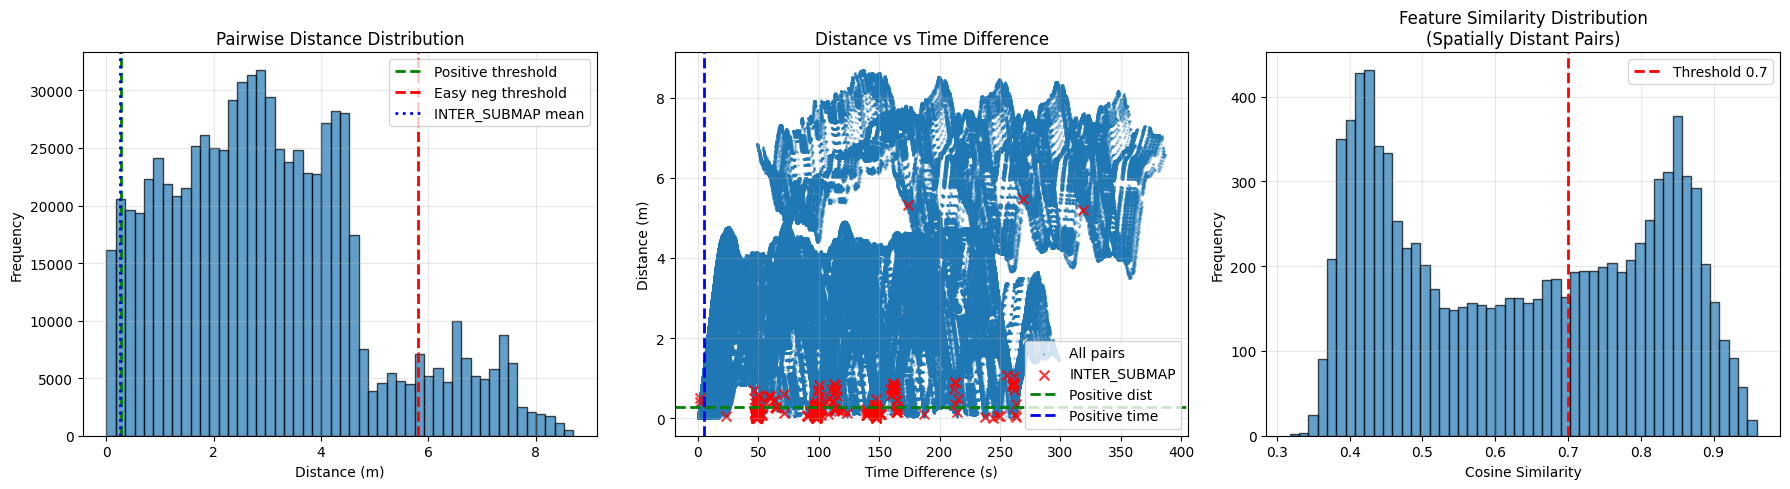


✓ Profiling complete. Proceeding with configured thresholds.


In [25]:
print("\n" + "="*70)
print("DATA PROFILING & THRESHOLD SUGGESTION")
print("="*70)


# Configuration: Threshold percentiles (adjustable)
POSITIVE_DISTANCE_PERCENTILE = 75  # Percentile of INTER_SUBMAP distances (75 = 75th percentile)
EASY_NEGATIVE_DISTANCE_PERCENTILE = 90  # Percentile of all pair distances


# Filter df_all_pairs to only include complete alignment nodes (both sensors)
complete_alignments = time_alignments.dropna()
valid_node_ids = set(complete_alignments['node_id'].values)
df_pairs_valid = df_all_pairs[
    df_all_pairs['node1_id'].isin(valid_node_ids) &
    df_all_pairs['node2_id'].isin(valid_node_ids)
].copy()

print(f"\nPairwise data:")
print(f"  Total pairs: {len(df_all_pairs):,}")
print(f"  Complete alignment nodes: {len(complete_alignments)} / {len(time_alignments)}")
print(f"  Valid pairs (both nodes complete): {len(df_pairs_valid):,}")

# Calculate statistics for ALL valid pairs
distances = df_pairs_valid['distance_between_nodes_m'].values
time_diffs = df_pairs_valid['time_diff_secs'].values

# Distance percentiles (FIXED - correct indexing)
dist_percentiles = [5, 10, 25, 50, 75, 90, 95]
dist_values = np.percentile(distances, dist_percentiles)

print(f"\n📊 Distance Distribution - ALL PAIRS (meters):")
for p, v in zip(dist_percentiles, dist_values):
    print(f"  {p:2d}th percentile: {v:.3f}m")

# Time percentiles
time_percentiles = [5, 10, 25, 50, 75, 90, 95]
time_values = np.percentile(time_diffs, time_percentiles)

print(f"\n⏱️  Time Difference Distribution - ALL PAIRS (seconds):")
for p, v in zip(time_percentiles, time_values):
    print(f"  {p:2d}th percentile: {v:.1f}s")

print("\n" + "="*70)
print("INTER_SUBMAP CONSTRAINT ANALYSIS (Ground Truth)")
print("="*70)

# Analyze INTER_SUBMAP pairs specifically
inter_submap_pairs = df_pairs_valid[df_pairs_valid['loop_closure'] == 1]

print(f"\n🎯 INTER_SUBMAP Loop Closures:")
print(f"  Count: {len(inter_submap_pairs)}")

if len(inter_submap_pairs) > 0:
    inter_distances = inter_submap_pairs['distance_between_nodes_m'].values
    inter_times = inter_submap_pairs['time_diff_secs'].values

    print(f"\n  Distance statistics:")
    print(f"    Min:  {np.min(inter_distances):.3f}m")
    print(f"    Max:  {np.max(inter_distances):.3f}m")
    print(f"    Mean: {np.mean(inter_distances):.3f}m")
    print(f"    Std:  {np.std(inter_distances):.3f}m")

    print(f"\n  Time gap statistics:")
    print(f"    Min:  {np.min(inter_times):.1f}s")
    print(f"    Max:  {np.max(inter_times):.1f}s")
    print(f"    Mean: {np.mean(inter_times):.1f}s")
    print(f"    Std:  {np.std(inter_times):.1f}s")

    # Suggest thresholds based on INTER_SUBMAP characteristics
    suggested_positive_dist = np.percentile(inter_distances, POSITIVE_DISTANCE_PERCENTILE) + 0.05  # Configurable percentile + margin
    suggested_time_gap = max(5.0, np.min(inter_times) - 2.0)  # Min - margin, but at least 5s

    print(f"\n💡 Suggested Thresholds (based on INTER_SUBMAP):")
    print(f"  Positive distance: {suggested_positive_dist:.3f}m (INTER_SUBMAP {POSITIVE_DISTANCE_PERCENTILE}th percentile + 0.05m)")
    print(f"  Positive time gap: {suggested_time_gap:.1f}s (INTER_SUBMAP min - 2s)")
else:
    print("  ⚠️  WARNING: No INTER_SUBMAP constraints found!")
    suggested_positive_dist = POSITIVE_DISTANCE_THRESHOLD
    suggested_time_gap = POSITIVE_TIME_GAP

# Use 90th percentile for easy negative threshold
suggested_easy_neg_dist = np.percentile(distances, EASY_NEGATIVE_DISTANCE_PERCENTILE)

print(f"  Easy negative distance: {suggested_easy_neg_dist:.3f}m ({EASY_NEGATIVE_DISTANCE_PERCENTILE}th percentile of all pairs)")

print(f"\n{'='*70}")
print("AUTO-APPLYING SUGGESTED THRESHOLDS")
print(f"{'='*70}")

# Store original values
original_positive_dist = POSITIVE_DISTANCE_THRESHOLD
original_positive_time = POSITIVE_TIME_GAP
original_easy_neg_dist = EASY_NEGATIVE_MIN_DISTANCE

# Apply suggested thresholds
POSITIVE_DISTANCE_THRESHOLD = suggested_positive_dist
POSITIVE_TIME_GAP = suggested_time_gap
EASY_NEGATIVE_MIN_DISTANCE = suggested_easy_neg_dist

print(f"\n📝 Threshold Updates:")
print(f"\n  Positive Distance:")
print(f"    Before: {original_positive_dist:.3f}m")
print(f"    After:  {POSITIVE_DISTANCE_THRESHOLD:.3f}m")
print(f"    Change: {POSITIVE_DISTANCE_THRESHOLD - original_positive_dist:+.3f}m ({100*(POSITIVE_DISTANCE_THRESHOLD - original_positive_dist)/original_positive_dist:+.1f}%)")

print(f"\n  Positive Time Gap:")
print(f"    Before: {original_positive_time:.1f}s")
print(f"    After:  {POSITIVE_TIME_GAP:.1f}s")
print(f"    Change: {POSITIVE_TIME_GAP - original_positive_time:+.1f}s ({100*(POSITIVE_TIME_GAP - original_positive_time)/original_positive_time:+.1f}%)")

print(f"\n  Easy Negative Distance:")
print(f"    Before: {original_easy_neg_dist:.3f}m")
print(f"    After:  {EASY_NEGATIVE_MIN_DISTANCE:.3f}m")
print(f"    Change: {EASY_NEGATIVE_MIN_DISTANCE - original_easy_neg_dist:+.3f}m ({100*(EASY_NEGATIVE_MIN_DISTANCE - original_easy_neg_dist)/original_easy_neg_dist:+.1f}%)")

print(f"\n📊 Threshold Sources:")
print(f"  Positive distance: INTER_SUBMAP {POSITIVE_DISTANCE_PERCENTILE}th percentile + 0.05m safety margin")
print(f"  Positive time gap: INTER_SUBMAP min - 2s safety margin (≥5s floor)")
print(f"  Easy negative distance: {EASY_NEGATIVE_DISTANCE_PERCENTILE}th percentile of all pair distances")

# Calculate adaptive hard negative distance threshold
suggested_hard_neg_dist = np.median(distances)
original_hard_neg_dist = HARD_NEGATIVE_MIN_DISTANCE
HARD_NEGATIVE_MIN_DISTANCE = suggested_hard_neg_dist

print(f"\n  Hard Negative Distance:")
print(f"    Before: {original_hard_neg_dist:.3f}m")
print(f"    After:  {HARD_NEGATIVE_MIN_DISTANCE:.3f}m (median of all pairs)")
print(f"    Change: {HARD_NEGATIVE_MIN_DISTANCE - original_hard_neg_dist:+.3f}m ({100*(HARD_NEGATIVE_MIN_DISTANCE - original_hard_neg_dist)/original_hard_neg_dist:+.1f}%)")

print(f"\n✅ Thresholds updated - proceeding with data-driven values")

print(f"\n📝 Current Configuration:")
print(f"  Positive distance: {POSITIVE_DISTANCE_THRESHOLD:.3f}m")
print(f"  Easy negative distance: {EASY_NEGATIVE_MIN_DISTANCE:.3f}m")
print(f"  Hard negative distance: {HARD_NEGATIVE_MIN_DISTANCE:.3f}m")
print(f"  Positive time gap: {POSITIVE_TIME_GAP:.1f}s")

print("\n" + "="*70)
print("POSITIVE PAIRS ANALYSIS")
print("="*70)

# Analyze potential positives with current thresholds
potential_positives_current = df_pairs_valid[
    (df_pairs_valid['distance_between_nodes_m'] <= POSITIVE_DISTANCE_THRESHOLD) &
    (df_pairs_valid['time_diff_secs'] >= POSITIVE_TIME_GAP)
]
extra_candidates_current = potential_positives_current[potential_positives_current['loop_closure'] == 0]

print(f"\n🔧 With CURRENT thresholds:")
print(f"  Distance ≤ {POSITIVE_DISTANCE_THRESHOLD}m AND Time gap ≥ {POSITIVE_TIME_GAP}s")
print(f"  Total meeting criteria: {len(potential_positives_current)}")
print(f"  Validated INTER_SUBMAP: {len(inter_submap_pairs)}")
print(f"  Extra candidates (not INTER_SUBMAP): {len(extra_candidates_current)}")

if len(extra_candidates_current) > 0:
    print(f"    Distance - Mean: {extra_candidates_current['distance_between_nodes_m'].mean():.3f}m")
    print(f"    Time gap - Mean: {extra_candidates_current['time_diff_secs'].mean():.1f}s")

print("\n" + "="*70)
print("NEGATIVE PAIRS PROFILING")
print("="*70)

# Easy negatives pool
easy_neg_candidates = df_pairs_valid[
    (df_pairs_valid['distance_between_nodes_m'] > EASY_NEGATIVE_MIN_DISTANCE) &
    (df_pairs_valid['time_diff_secs'] > EASY_NEG_MIN_TEMPORAL_GAP)
]

print(f"\n📦 Easy Negative Pool:")
print(f"  Criteria: Distance > {EASY_NEGATIVE_MIN_DISTANCE}m AND Time gap > {EASY_NEG_MIN_TEMPORAL_GAP}s")
print(f"  Available candidates: {len(easy_neg_candidates):,}")

# Distance bin distribution
for i in range(len(STRATIFY_DISTANCE_BINS) - 1):
    bin_start = STRATIFY_DISTANCE_BINS[i]
    bin_end = STRATIFY_DISTANCE_BINS[i+1]
    if bin_end == np.inf:
        bin_count = len(easy_neg_candidates[easy_neg_candidates['distance_between_nodes_m'] >= bin_start])
        print(f"    {bin_start:.1f}m+ : {bin_count:,} pairs")
    else:
        bin_count = len(easy_neg_candidates[
            (easy_neg_candidates['distance_between_nodes_m'] >= bin_start) &
            (easy_neg_candidates['distance_between_nodes_m'] < bin_end)
        ])
        print(f"    {bin_start:.1f}-{bin_end:.1f}m: {bin_count:,} pairs")

# Hard negatives pool profiling
print(f"\n🎯 Hard Negative Pool Profiling:")
print(f"  Computing similarities for distance > {EASY_NEGATIVE_MIN_DISTANCE}m pairs...")

hard_neg_base = df_pairs_valid[
    df_pairs_valid['distance_between_nodes_m'] > EASY_NEGATIVE_MIN_DISTANCE
]

# Sample for profiling (if too many, sample 10k for speed)
profile_sample = hard_neg_base.sample(n=min(10000, len(hard_neg_base)), random_state=RANDOM_SEED)

similarities = []
for _, row in profile_sample.iterrows():
    node1_data = time_alignments[time_alignments['node_id'] == row['node1_id']].iloc[0]
    node2_data = time_alignments[time_alignments['node_id'] == row['node2_id']].iloc[0]

    cam1_idx = int(node1_data['camera_feat_id'])
    lid1_idx = int(node1_data['lidar_feat_id'])
    cam2_idx = int(node2_data['camera_feat_id'])
    lid2_idx = int(node2_data['lidar_feat_id'])

    feat1 = np.concatenate([camera_features[cam1_idx], lidar_features[lid1_idx]])
    feat2 = np.concatenate([camera_features[cam2_idx], lidar_features[lid2_idx]])

    similarity = np.dot(feat1, feat2) / (np.linalg.norm(feat1) * np.linalg.norm(feat2))
    similarities.append(similarity)

similarities = np.array(similarities)

print(f"  Similarity distribution (sampled {len(similarities):,} pairs):")
sim_percentiles = [50, 75, 90, 95, 99]
sim_values = np.percentile(similarities, sim_percentiles)
for p, v in zip(sim_percentiles, sim_values):
    print(f"    {p:2d}th percentile: {v:.3f}")

# Estimate hard negatives at each threshold
print(f"\n  Estimated hard negatives at different thresholds:")
total_hard_base = len(hard_neg_base)
for threshold in HARD_NEGATIVE_SIMILARITY_FALLBACK:
    estimated_count = int(total_hard_base * np.mean(similarities >= threshold))
    print(f"    Similarity ≥ {threshold:.2f}: ~{estimated_count:,} pairs")

print("\n" + "="*70)
print("SAMPLING PLAN (Option 2: Hard-focused)")
print("="*70)

n_positives = len(potential_positives_current)
n_easy_neg_target = int(n_positives * EASY_NEGATIVE_RATIO)
n_hard_neg_target = int(n_positives * HARD_NEGATIVE_RATIO)
total_dataset_size = n_positives + n_easy_neg_target + n_hard_neg_target

print(f"\n📊 Target Dataset Composition:")
print(f"  Positives:      {n_positives:4d} (30.0%)")
print(f"  Easy negatives: {n_easy_neg_target:4d} ({100*n_easy_neg_target/total_dataset_size:.1f}%)")
print(f"  Hard negatives: {n_hard_neg_target:4d} ({100*n_hard_neg_target/total_dataset_size:.1f}%)")
print(f"  ──────────────────────────")
print(f"  Total:          {total_dataset_size:4d} pairs")

print(f"\n✅ Feasibility Check:")
print(f"  Easy neg available: {len(easy_neg_candidates):,} (need {n_easy_neg_target}) → {'✓' if len(easy_neg_candidates) >= n_easy_neg_target else '⚠️ INSUFFICIENT'}")

# Estimate if we have enough hard negatives at base threshold
estimated_hard_at_base = int(total_hard_base * np.mean(similarities >= HARD_NEGATIVE_SIMILARITY_THRESHOLD))
print(f"  Hard neg available: ~{estimated_hard_at_base:,} (need {n_hard_neg_target}) → {'✓' if estimated_hard_at_base >= n_hard_neg_target else '⚠️ MAY NEED FALLBACK'}")

# Visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distance histogram
axes[0].hist(distances, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(POSITIVE_DISTANCE_THRESHOLD, color='green', linestyle='--', linewidth=2, label='Positive threshold')
axes[0].axvline(EASY_NEGATIVE_MIN_DISTANCE, color='red', linestyle='--', linewidth=2, label='Easy neg threshold')
if len(inter_submap_pairs) > 0:
    axes[0].axvline(np.mean(inter_distances), color='blue', linestyle=':', linewidth=2, label='INTER_SUBMAP mean')
axes[0].set_xlabel('Distance (m)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Pairwise Distance Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time vs Distance scatter
axes[1].scatter(time_diffs, distances, alpha=0.3, s=1, label='All pairs')
if len(inter_submap_pairs) > 0:
    axes[1].scatter(inter_times, inter_distances, alpha=0.8, s=50, c='red', marker='x', label='INTER_SUBMAP')
axes[1].axhline(POSITIVE_DISTANCE_THRESHOLD, color='green', linestyle='--', linewidth=2, label='Positive dist')
axes[1].axvline(POSITIVE_TIME_GAP, color='blue', linestyle='--', linewidth=2, label='Positive time')
axes[1].set_xlabel('Time Difference (s)')
axes[1].set_ylabel('Distance (m)')
axes[1].set_title('Distance vs Time Difference')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Similarity histogram for hard negatives
axes[2].hist(similarities, bins=50, alpha=0.7, edgecolor='black')
axes[2].axvline(HARD_NEGATIVE_SIMILARITY_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold {HARD_NEGATIVE_SIMILARITY_THRESHOLD}')
axes[2].set_xlabel('Cosine Similarity')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Feature Similarity Distribution\n(Spatially Distant Pairs)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("✓ Profiling complete. Proceeding with configured thresholds.")
print("="*70)

### 6.2 Strategy Overview

We create three types of training pairs using **Option 2: Hard-focused ratios**:

1. **Positive Pairs (30%)** - Loop closures from Cartographer-optimized trajectory
   - Based on final SLAM-corrected positions (distance ≤ 0.3m, time gap ≥ 10s)
   - Includes INTER_SUBMAP validated + augmented candidates from trajectory analysis
   
2. **Easy Negative Pairs (~22%)** - Spatially distant locations
   - **Ratio: 0.75x positives**
   - Distance > 1.0m with temporal gap > 5s
   - Stratified sampling by distance bins for diversity
   
3. **Hard Negative Pairs (~48%)** - Perceptually similar but spatially distinct
   - **Ratio: 1.25x positives**
   - Distance > 1.0m AND high feature similarity (≥ 0.7)
   - Fallback thresholds if insufficient: [0.7, 0.65, 0.6, 0.55]
   - Teaches model to avoid perceptual aliasing

**Rationale:** More hard negatives help the model learn robust discrimination in ambiguous cases, which is critical for reliable loop closure detection.

### 6.3 Generate Positive Pairs from Loop Closures

In [26]:
print("\n" + "="*70)
print("GENERATING POSITIVE PAIR LABELS - PART 1: LOOP CLOSURES")
print("="*70)

# Step 1: Get INTER_SUBMAP loop closures
loop_closure_pairs_all = df_all_pairs[df_all_pairs['loop_closure'] == True].copy()

print(f"\nTotal INTER_SUBMAP loop closures: {len(loop_closure_pairs_all)}")

# Filter outliers based on DISTANCE threshold only
outlier_mask = loop_closure_pairs_all['distance_between_nodes_m'] > POSITIVE_DISTANCE_THRESHOLD

loop_closure_outliers = loop_closure_pairs_all[outlier_mask].copy()
loop_closure_pairs = loop_closure_pairs_all[~outlier_mask].copy()

print(f"\n🔍 Outlier Detection (Distance-based):")
print(f"  Threshold: Distance ≤ {POSITIVE_DISTANCE_THRESHOLD:.4f}m")
print(f"  Outliers found: {len(loop_closure_outliers)} ({100*len(loop_closure_outliers)/len(loop_closure_pairs_all):.1f}%)")
print(f"  Valid loop closures: {len(loop_closure_pairs)} ({100*len(loop_closure_pairs)/len(loop_closure_pairs_all):.1f}%)")

if len(loop_closure_outliers) > 0:
    print(f"\n📊 Outlier Statistics:")
    print(f"  Distance - Min: {loop_closure_outliers['distance_between_nodes_m'].min():.4f}m, "
          f"Max: {loop_closure_outliers['distance_between_nodes_m'].max():.4f}m, "
          f"Mean: {loop_closure_outliers['distance_between_nodes_m'].mean():.4f}m")
    print(f"  Time gap - Min: {loop_closure_outliers['time_diff_secs'].min():.2f}s, "
          f"Max: {loop_closure_outliers['time_diff_secs'].max():.2f}s, "
          f"Mean: {loop_closure_outliers['time_diff_secs'].mean():.2f}s")

    # Text-based bar graph for distance distribution
    print(f"\n📊 Distance Distribution (Text Bar Graph):")
    bins = [0, 0.1, 0.2, 0.3, 0.5, 1.0, 2.0, 5.0, 100]
    bin_labels = ['0-0.1m', '0.1-0.2m', '0.2-0.3m', '0.3-0.5m', '0.5-1.0m', '1.0-2.0m', '2.0-5.0m', '>5.0m']

    valid_dists = loop_closure_pairs['distance_between_nodes_m'].values
    outlier_dists = loop_closure_outliers['distance_between_nodes_m'].values

    print("\n  Valid Loop Closures:")
    for i in range(len(bins)-1):
        count = np.sum((valid_dists >= bins[i]) & (valid_dists < bins[i+1]))
        bar = '█' * int(count / len(valid_dists) * 50) if len(valid_dists) > 0 else ''
        print(f"    {bin_labels[i]:12s} {count:4d} {bar}")

    print("\n  Outliers:")
    for i in range(len(bins)-1):
        count = np.sum((outlier_dists >= bins[i]) & (outlier_dists < bins[i+1]))
        bar = '█' * int(count / len(outlier_dists) * 50) if len(outlier_dists) > 0 else ''
        print(f"    {bin_labels[i]:12s} {count:4d} {bar}")

    print(f"\n  Outlier node pairs (first 10):")
    for idx, row in loop_closure_outliers.head(10).iterrows():
        print(f"    Pair {int(row['node1_id']):4d}-{int(row['node2_id']):4d}: "
              f"dist={row['distance_between_nodes_m']:.4f}m, time={row['time_diff_secs']:.2f}s")
    if len(loop_closure_outliers) > 10:
        print(f"    ... and {len(loop_closure_outliers)-10} more")

    print(f"\n✓ Outliers kept in pool for future sections")

# Create DataFrame with node_pair_id (as integer) and label - ONLY valid loop closures
labeled_pairs_loop_closure = pd.DataFrame({
    'node_pair_id': loop_closure_pairs.index.astype(int),
    'label': 1,
    'source': 'loop_closure'
})

n_loop_closure = len(labeled_pairs_loop_closure)
print(f"\n✅ Valid loop closure positives added: {n_loop_closure}")

# Track used indices
used_indices = set(labeled_pairs_loop_closure['node_pair_id'].values)



GENERATING POSITIVE PAIR LABELS - PART 1: LOOP CLOSURES

Total INTER_SUBMAP loop closures: 406

🔍 Outlier Detection (Distance-based):
  Threshold: Distance ≤ 0.2778m
  Outliers found: 94 (23.2%)
  Valid loop closures: 312 (76.8%)

📊 Outlier Statistics:
  Distance - Min: 0.2808m, Max: 5.4819m, Mean: 0.7512m
  Time gap - Min: 1.45s, Max: 318.50s, Mean: 138.99s

📊 Distance Distribution (Text Bar Graph):

  Valid Loop Closures:
    0-0.1m        154 ████████████████████████
    0.1-0.2m      131 ████████████████████
    0.2-0.3m       27 ████
    0.3-0.5m        0 
    0.5-1.0m        0 
    1.0-2.0m        0 
    2.0-5.0m        0 
    >5.0m           0 

  Outliers:
    0-0.1m          0 
    0.1-0.2m        0 
    0.2-0.3m        6 ███
    0.3-0.5m       30 ███████████████
    0.5-1.0m       53 ████████████████████████████
    1.0-2.0m        2 █
    2.0-5.0m        0 
    >5.0m           3 █

  Outlier node pairs (first 10):
    Pair   51-1044: dist=0.3601m, time=263.17s
    Pair   70


VISUALIZATION: LOOP CLOSURE PAIRS (PART 1)


/tmp/ipython-input-90167858.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,


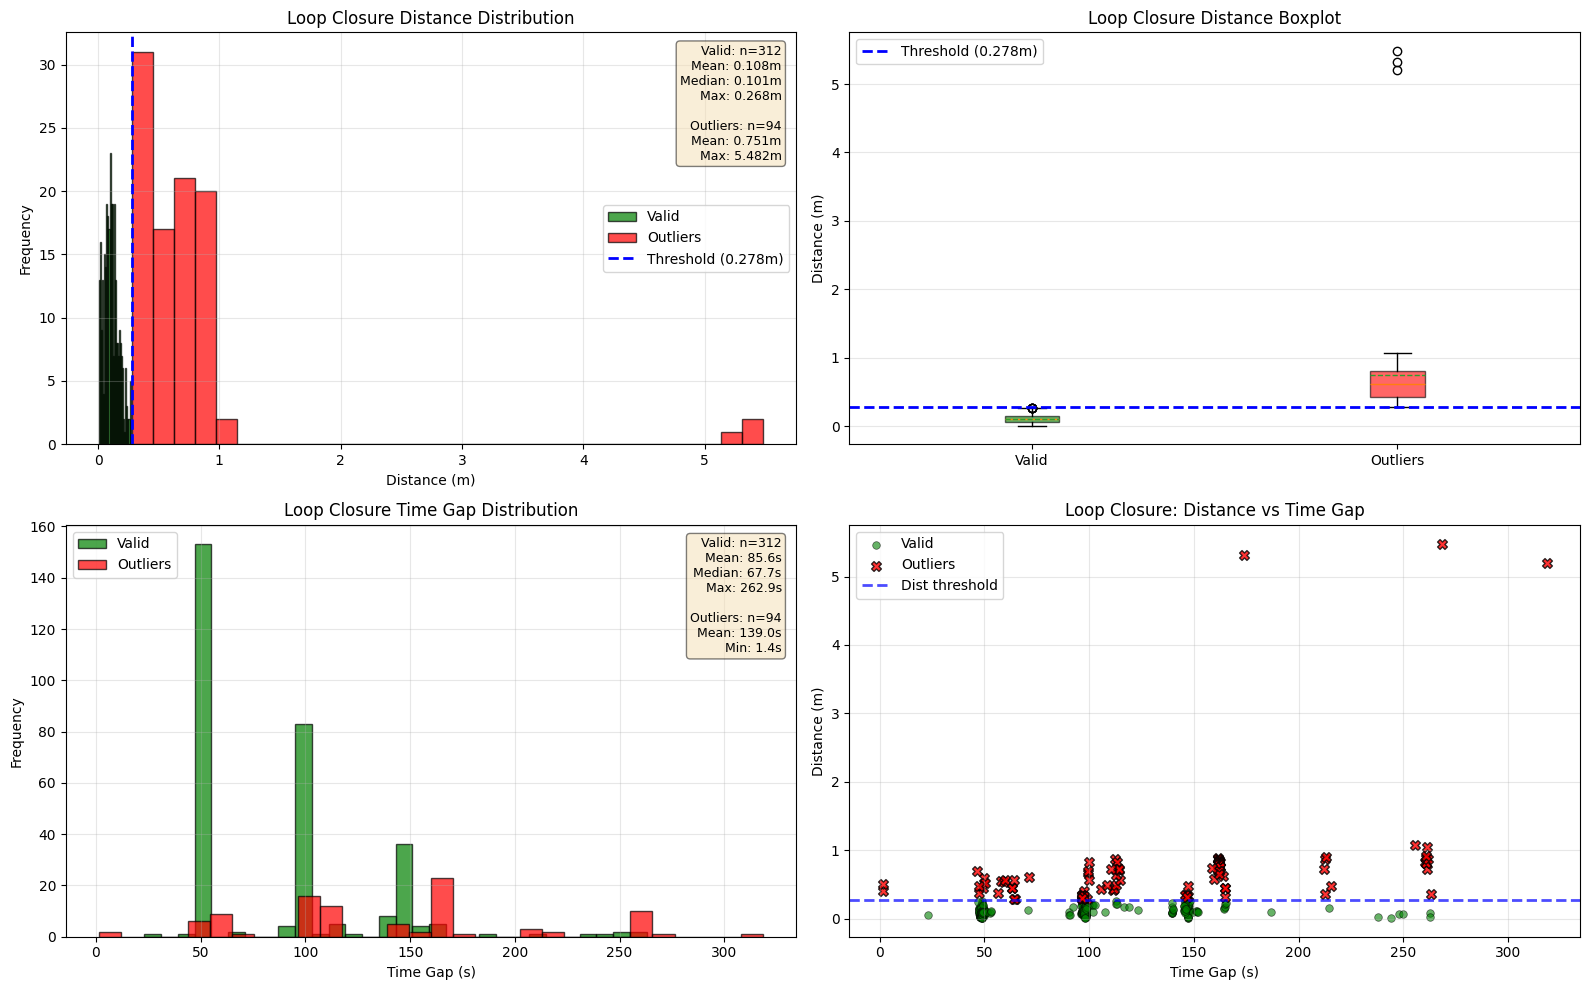


✅ Visualization complete


In [27]:
print("\n" + "="*70)
print("VISUALIZATION: LOOP CLOSURE PAIRS (PART 1)")
print("="*70)

import matplotlib.pyplot as plt

# Extract data for all loop closures
all_lc_distances = loop_closure_pairs_all['distance_between_nodes_m'].values
all_lc_times = loop_closure_pairs_all['time_diff_secs'].values

# Extract data for valid and outliers
valid_distances = loop_closure_pairs['distance_between_nodes_m'].values if len(loop_closure_pairs) > 0 else []
valid_times = loop_closure_pairs['time_diff_secs'].values if len(loop_closure_pairs) > 0 else []
outlier_distances = loop_closure_outliers['distance_between_nodes_m'].values if len(loop_closure_outliers) > 0 else []
outlier_times = loop_closure_outliers['time_diff_secs'].values if len(loop_closure_outliers) > 0 else []

# Create figure with 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# Plot 1: Distance histogram
axes[0].hist(valid_distances, bins=30, alpha=0.7, color='green', edgecolor='black', label='Valid')
if len(outlier_distances) > 0:
    axes[0].hist(outlier_distances, bins=30, alpha=0.7, color='red', edgecolor='black', label='Outliers')
axes[0].axvline(POSITIVE_DISTANCE_THRESHOLD, color='blue', linestyle='--', linewidth=2, label=f'Threshold ({POSITIVE_DISTANCE_THRESHOLD:.3f}m)')
axes[0].set_xlabel('Distance (m)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Loop Closure Distance Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Statistics text
stats_text = f"Valid: n={len(valid_distances)}\nMean: {np.mean(valid_distances):.3f}m\nMedian: {np.median(valid_distances):.3f}m\nMax: {np.max(valid_distances):.3f}m"
if len(outlier_distances) > 0:
    stats_text += f"\n\nOutliers: n={len(outlier_distances)}\nMean: {np.mean(outlier_distances):.3f}m\nMax: {np.max(outlier_distances):.3f}m"
axes[0].text(0.98, 0.97, stats_text, transform=axes[0].transAxes,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

# Plot 2: Distance boxplot
boxplot_data = [valid_distances]
boxplot_labels = ['Valid']
boxplot_colors = ['green']
if len(outlier_distances) > 0:
    boxplot_data.append(outlier_distances)
    boxplot_labels.append('Outliers')
    boxplot_colors.append('red')

bp = axes[1].boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,
                     showmeans=True, meanline=True)
for patch, color in zip(bp['boxes'], boxplot_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
axes[1].axhline(POSITIVE_DISTANCE_THRESHOLD, color='blue', linestyle='--', linewidth=2,
                label=f'Threshold ({POSITIVE_DISTANCE_THRESHOLD:.3f}m)')
axes[1].set_ylabel('Distance (m)')
axes[1].set_title('Loop Closure Distance Boxplot')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Time gap histogram
axes[2].hist(valid_times, bins=30, alpha=0.7, color='green', edgecolor='black', label='Valid')
if len(outlier_times) > 0:
    axes[2].hist(outlier_times, bins=30, alpha=0.7, color='red', edgecolor='black', label='Outliers')
axes[2].set_xlabel('Time Gap (s)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Loop Closure Time Gap Distribution')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Statistics text
stats_text = f"Valid: n={len(valid_times)}\nMean: {np.mean(valid_times):.1f}s\nMedian: {np.median(valid_times):.1f}s\nMax: {np.max(valid_times):.1f}s"
if len(outlier_times) > 0:
    stats_text += f"\n\nOutliers: n={len(outlier_times)}\nMean: {np.mean(outlier_times):.1f}s\nMin: {np.min(outlier_times):.1f}s"
axes[2].text(0.98, 0.97, stats_text, transform=axes[2].transAxes,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

# Plot 4: Distance vs Time scatter
if len(valid_distances) > 0:
    axes[3].scatter(valid_times, valid_distances, alpha=0.6, s=30, c='green', label='Valid', edgecolors='black', linewidths=0.5)
if len(outlier_distances) > 0:
    axes[3].scatter(outlier_times, outlier_distances, alpha=0.8, s=50, c='red', marker='X', label='Outliers', edgecolors='black', linewidths=1)
axes[3].axhline(POSITIVE_DISTANCE_THRESHOLD, color='blue', linestyle='--', linewidth=2, alpha=0.7, label=f'Dist threshold')
axes[3].set_xlabel('Time Gap (s)')
axes[3].set_ylabel('Distance (m)')
axes[3].set_title('Loop Closure: Distance vs Time Gap')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Visualization complete")


In [28]:
print("\n" + "="*70)
print("GENERATING POSITIVE PAIR LABELS - PART 2: AUGMENTED POSITIVES")
print("="*70)

# Step 2: Get augmented positives (distance + time criteria, excluding loop closures)
remaining_indices = df_all_pairs.index.difference(used_indices)
candidates = df_all_pairs.loc[remaining_indices]

# Apply positive criteria
augmented_mask = (
    (candidates['distance_between_nodes_m'] < POSITIVE_DISTANCE_THRESHOLD) &
    (candidates['time_diff_secs'] > POSITIVE_TIME_GAP)
)

augmented_positives = candidates[augmented_mask].copy()

# Create DataFrame
labeled_pairs_augmented = pd.DataFrame({
    'node_pair_id': augmented_positives.index.astype(int),
    'label': 1,
    'source': 'augmented',
    'distance': augmented_positives['distance_between_nodes_m'].values,
    'time_diff': augmented_positives['time_diff_secs'].values
})

n_augmented = len(labeled_pairs_augmented)
print(f"\n✓ Augmented positives: {n_augmented}")
print(f"  Distance < {POSITIVE_DISTANCE_THRESHOLD}m, Time gap > {POSITIVE_TIME_GAP}s")

# Combine both positive sets
labeled_pairs_positive = pd.concat([
    labeled_pairs_loop_closure,
    labeled_pairs_augmented
], ignore_index=True)

print(f"\n✅ Total positives: {len(labeled_pairs_positive)} ({n_loop_closure} loop closure + {n_augmented} augmented)")

# Update used indices
used_indices.update(labeled_pairs_positive['node_pair_id'].values)



GENERATING POSITIVE PAIR LABELS - PART 2: AUGMENTED POSITIVES

✓ Augmented positives: 19322
  Distance < 0.2777539391674729m, Time gap > 5.0s

✅ Total positives: 19634 (312 loop closure + 19322 augmented)



VISUALIZATION: AUGMENTED POSITIVE PAIRS (PART 2)


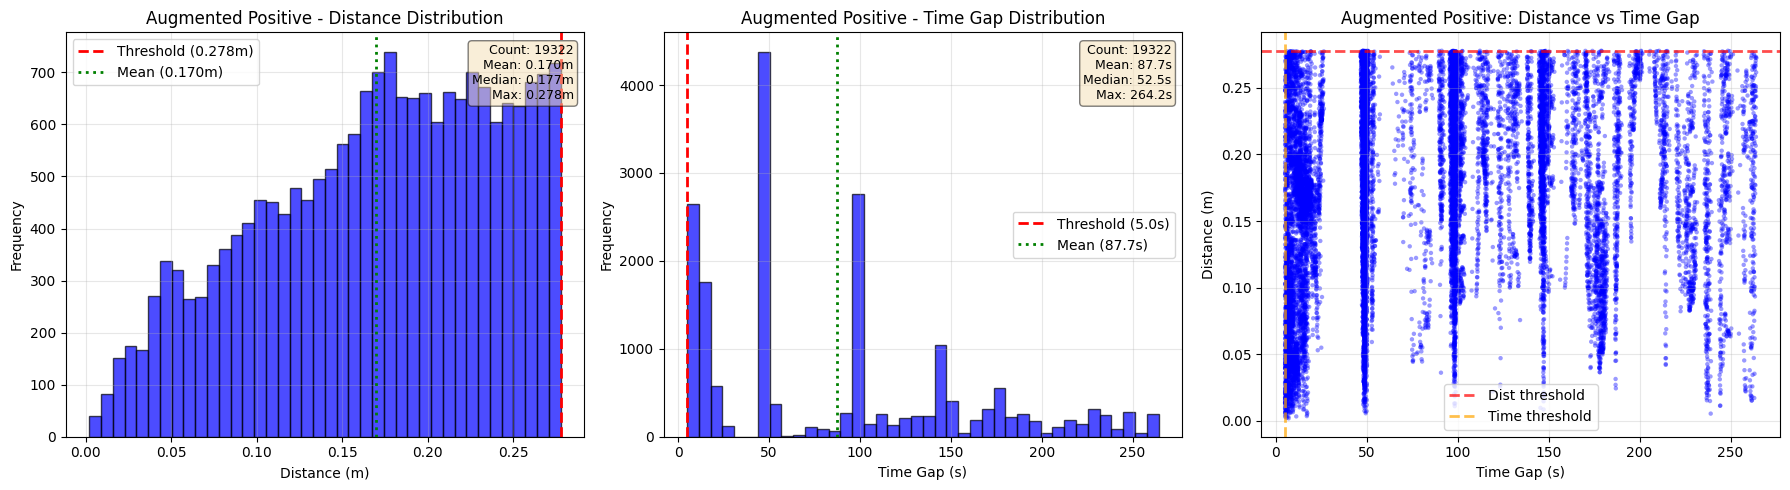


✅ Visualization complete


In [29]:
print("\n" + "="*70)
print("VISUALIZATION: AUGMENTED POSITIVE PAIRS (PART 2)")
print("="*70)

import matplotlib.pyplot as plt

# Extract data
aug_distances = labeled_pairs_augmented['distance'].values
aug_times = labeled_pairs_augmented['time_diff'].values

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Distance histogram
axes[0].hist(aug_distances, bins=40, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(POSITIVE_DISTANCE_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold ({POSITIVE_DISTANCE_THRESHOLD:.3f}m)')
axes[0].axvline(np.mean(aug_distances), color='green', linestyle=':', linewidth=2, label=f'Mean ({np.mean(aug_distances):.3f}m)')
axes[0].set_xlabel('Distance (m)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Augmented Positive - Distance Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Statistics text
stats_text = f"Count: {len(aug_distances)}\nMean: {np.mean(aug_distances):.3f}m\nMedian: {np.median(aug_distances):.3f}m\nMax: {np.max(aug_distances):.3f}m"
axes[0].text(0.98, 0.97, stats_text, transform=axes[0].transAxes,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

# Plot 2: Time gap histogram
axes[1].hist(aug_times, bins=40, alpha=0.7, color='blue', edgecolor='black')
axes[1].axvline(POSITIVE_TIME_GAP, color='red', linestyle='--', linewidth=2, label=f'Threshold ({POSITIVE_TIME_GAP:.1f}s)')
axes[1].axvline(np.mean(aug_times), color='green', linestyle=':', linewidth=2, label=f'Mean ({np.mean(aug_times):.1f}s)')
axes[1].set_xlabel('Time Gap (s)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Augmented Positive - Time Gap Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Statistics text
stats_text = f"Count: {len(aug_times)}\nMean: {np.mean(aug_times):.1f}s\nMedian: {np.median(aug_times):.1f}s\nMax: {np.max(aug_times):.1f}s"
axes[1].text(0.98, 0.97, stats_text, transform=axes[1].transAxes,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

# Plot 3: Distance vs Time scatter
axes[2].scatter(aug_times, aug_distances, alpha=0.4, s=10, c='blue', edgecolors='none')
axes[2].axhline(POSITIVE_DISTANCE_THRESHOLD, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Dist threshold')
axes[2].axvline(POSITIVE_TIME_GAP, color='orange', linestyle='--', linewidth=2, alpha=0.7, label=f'Time threshold')
axes[2].set_xlabel('Time Gap (s)')
axes[2].set_ylabel('Distance (m)')
axes[2].set_title('Augmented Positive: Distance vs Time Gap')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Visualization complete")


### 6.4 Generate Easy Negative Pairs

In [30]:
print("\n" + "="*70)
print("GENERATING EASY NEGATIVE PAIR LABELS")
print("="*70)

# Step 3: Get easy negatives (exclude all positives)
n_easy_neg_target = int(len(labeled_pairs_positive) * EASY_NEGATIVE_RATIO)

remaining_indices = df_all_pairs.index.difference(used_indices)
candidates = df_all_pairs.loc[remaining_indices]

# Apply easy negative criteria
easy_neg_mask = (
    (candidates['distance_between_nodes_m'] > EASY_NEGATIVE_MIN_DISTANCE) &
    (candidates['time_diff_secs'] > POSITIVE_TIME_GAP)
)

easy_neg_candidates = candidates[easy_neg_mask].copy()

print(f"\nTarget count: {n_easy_neg_target} ({EASY_NEGATIVE_RATIO}x positives)")
print(f"Available candidates: {len(easy_neg_candidates)}")

if len(easy_neg_candidates) < n_easy_neg_target:
    print(f"⚠️  Warning: Insufficient candidates. Using all {len(easy_neg_candidates)} available.")
    easy_neg_sample = easy_neg_candidates
else:
    # Stratified sampling by distance bins
    distances = easy_neg_candidates['distance_between_nodes_m'].values
    bins = [EASY_NEGATIVE_MIN_DISTANCE, 2.0, 4.0, 6.0, np.inf]

    samples_per_bin = []
    for i in range(len(bins)-1):
        bin_start, bin_end = bins[i], bins[i+1]
        bin_mask = (distances >= bin_start) & (distances < bin_end)
        bin_data = easy_neg_candidates[bin_mask]

        bin_target = int(n_easy_neg_target * len(bin_data) / len(easy_neg_candidates))
        bin_target = min(bin_target, len(bin_data))

        if bin_target > 0:
            sample = bin_data.sample(n=bin_target, random_state=RANDOM_SEED)
            samples_per_bin.append(sample)

    easy_neg_sample = pd.concat(samples_per_bin, ignore_index=False)

# Create DataFrame
labeled_pairs_easy = pd.DataFrame({
    'node_pair_id': easy_neg_sample.index.astype(int),
    'label': 0,
    'source': 'easy_negative',
    'distance': easy_neg_sample['distance_between_nodes_m'].values
})

print(f"\n✅ Generated {len(labeled_pairs_easy)} easy negative pair labels")

# Update used indices
used_indices.update(labeled_pairs_easy['node_pair_id'].values)



GENERATING EASY NEGATIVE PAIR LABELS

Target count: 14725 (0.75x positives)
Available candidates: 77710

✅ Generated 14724 easy negative pair labels



VISUALIZATION: EASY NEGATIVE PAIRS


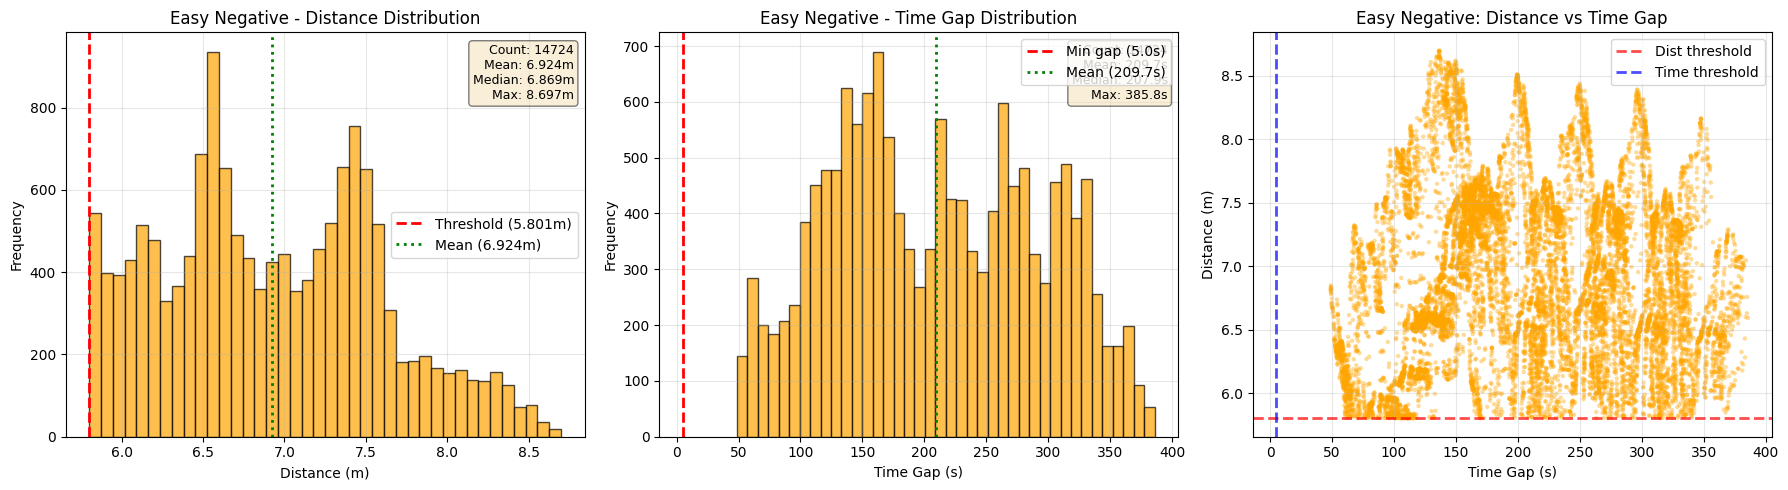


✅ Visualization complete


In [31]:
print("\n" + "="*70)
print("VISUALIZATION: EASY NEGATIVE PAIRS")
print("="*70)

import matplotlib.pyplot as plt

# Extract data
easy_distances = labeled_pairs_easy['distance'].values
# Get time data from df_all_pairs
easy_pair_ids = labeled_pairs_easy['node_pair_id'].values
easy_times = df_all_pairs.loc[easy_pair_ids, 'time_diff_secs'].values

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Distance histogram
axes[0].hist(easy_distances, bins=40, alpha=0.7, color='orange', edgecolor='black')
axes[0].axvline(EASY_NEGATIVE_MIN_DISTANCE, color='red', linestyle='--', linewidth=2, label=f'Threshold ({EASY_NEGATIVE_MIN_DISTANCE:.3f}m)')
axes[0].axvline(np.mean(easy_distances), color='green', linestyle=':', linewidth=2, label=f'Mean ({np.mean(easy_distances):.3f}m)')
axes[0].set_xlabel('Distance (m)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Easy Negative - Distance Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Statistics text
stats_text = f"Count: {len(easy_distances)}\nMean: {np.mean(easy_distances):.3f}m\nMedian: {np.median(easy_distances):.3f}m\nMax: {np.max(easy_distances):.3f}m"
axes[0].text(0.98, 0.97, stats_text, transform=axes[0].transAxes,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

# Plot 2: Time gap histogram
axes[1].hist(easy_times, bins=40, alpha=0.7, color='orange', edgecolor='black')
axes[1].axvline(POSITIVE_TIME_GAP, color='red', linestyle='--', linewidth=2, label=f'Min gap ({POSITIVE_TIME_GAP:.1f}s)')
axes[1].axvline(np.mean(easy_times), color='green', linestyle=':', linewidth=2, label=f'Mean ({np.mean(easy_times):.1f}s)')
axes[1].set_xlabel('Time Gap (s)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Easy Negative - Time Gap Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Statistics text
stats_text = f"Count: {len(easy_times)}\nMean: {np.mean(easy_times):.1f}s\nMedian: {np.median(easy_times):.1f}s\nMax: {np.max(easy_times):.1f}s"
axes[1].text(0.98, 0.97, stats_text, transform=axes[1].transAxes,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

# Plot 3: Distance vs Time scatter
axes[2].scatter(easy_times, easy_distances, alpha=0.4, s=10, c='orange', edgecolors='none')
axes[2].axhline(EASY_NEGATIVE_MIN_DISTANCE, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Dist threshold')
axes[2].axvline(POSITIVE_TIME_GAP, color='blue', linestyle='--', linewidth=2, alpha=0.7, label=f'Time threshold')
axes[2].set_xlabel('Time Gap (s)')
axes[2].set_ylabel('Distance (m)')
axes[2].set_title('Easy Negative: Distance vs Time Gap')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Visualization complete")


### 6.5 Generate Hard Negative Pairs (Perceptual Aliasing)

In [32]:
print("\n" + "="*70)
print("GENERATING HARD NEGATIVE PAIR LABELS (PERCEPTUAL ALIASING)")
print("="*70)

from tqdm import tqdm

# Step 4: Get hard negatives (exclude all positives and easy negatives)
n_hard_neg_target = int(len(labeled_pairs_positive) * HARD_NEGATIVE_RATIO)

remaining_indices = df_all_pairs.index.difference(used_indices)
candidates = df_all_pairs.loc[remaining_indices]

print(f"\nTarget count: {n_hard_neg_target} ({HARD_NEGATIVE_RATIO}x positives)")
print(f"Remaining candidate pairs: {len(candidates)}")

# Filter by distance
distance_mask = candidates['distance_between_nodes_m'] > HARD_NEGATIVE_MIN_DISTANCE
candidates_filtered = candidates[distance_mask]

print(f"After distance filter (>{HARD_NEGATIVE_MIN_DISTANCE:.3f}m): {len(candidates_filtered)}")

if len(candidates_filtered) == 0:
    print("\n⚠️  No candidates after distance filter. Creating empty hard negatives.")
    labeled_pairs_hard = pd.DataFrame(columns=['node_pair_id', 'label', 'source'])
    similarities_selected = np.array([])
else:
    # Vectorized batch processing with fallback thresholds
    hard_negative_candidates = []
    batch_size = 50000
    fallback_thresholds = HARD_NEGATIVE_SIMILARITY_FALLBACK  # [0.70, 0.65, 0.60, 0.55]

    print(f"\nVectorized batch processing (batch_size={batch_size})...")

    # Try each threshold until target reached
    for threshold in fallback_thresholds:
        if len(hard_negative_candidates) >= n_hard_neg_target:
            break

        print(f"\nAttempting similarity threshold ≥ {threshold:.2f}...")
        attempts = 0
        max_attempts = 10  # Maximum batches per threshold

        while len(hard_negative_candidates) < n_hard_neg_target and attempts < max_attempts:
            attempts += 1

            # Random sample from candidates
            sample_size = min(batch_size, len(candidates_filtered))
            batch_candidates = candidates_filtered.sample(n=sample_size, random_state=RANDOM_SEED+attempts)

            # Build feature matrices for batch with progress bar
            batch_features_1 = []
            batch_features_2 = []
            batch_indices = []

            pbar = tqdm(batch_candidates.iterrows(),
                       total=len(batch_candidates),
                       desc=f"  Batch {attempts} - Building features",
                       leave=False)

            for pair_idx, row in pbar:
                try:
                    node1_id = int(row['node1_id'])
                    node2_id = int(row['node2_id'])

                    node1_align = time_alignments[time_alignments['node_id'] == node1_id].iloc[0]
                    node2_align = time_alignments[time_alignments['node_id'] == node2_id].iloc[0]

                    # Check for NaN
                    if pd.isna(node1_align['camera_feat_id']) or pd.isna(node1_align['lidar_feat_id']) or \
                       pd.isna(node2_align['camera_feat_id']) or pd.isna(node2_align['lidar_feat_id']):
                        continue

                    cam1_idx = int(node1_align['camera_feat_id'])
                    lid1_idx = int(node1_align['lidar_feat_id'])
                    cam2_idx = int(node2_align['camera_feat_id'])
                    lid2_idx = int(node2_align['lidar_feat_id'])

                    feat1 = np.concatenate([camera_features[cam1_idx], lidar_features[lid1_idx]])
                    feat2 = np.concatenate([camera_features[cam2_idx], lidar_features[lid2_idx]])

                    batch_features_1.append(feat1)
                    batch_features_2.append(feat2)
                    batch_indices.append(pair_idx)
                except:
                    continue

            pbar.close()

            if len(batch_features_1) == 0:
                continue

            # Vectorized similarity computation
            batch_features_1 = np.array(batch_features_1)
            batch_features_2 = np.array(batch_features_2)

            # Compute cosine similarity (vectorized)
            norms_1 = np.linalg.norm(batch_features_1, axis=1, keepdims=True)
            norms_2 = np.linalg.norm(batch_features_2, axis=1, keepdims=True)
            similarities = np.sum(batch_features_1 * batch_features_2, axis=1) / (norms_1.flatten() * norms_2.flatten())

            # Filter by threshold
            high_sim_mask = similarities >= threshold
            high_sim_indices = np.array(batch_indices)[high_sim_mask]
            high_sim_values = similarities[high_sim_mask]

            # Add to candidates
            for idx, sim in zip(high_sim_indices, high_sim_values):
                if int(idx) not in [c['node_pair_id'] for c in hard_negative_candidates]:
                    hard_negative_candidates.append({
                        'node_pair_id': int(idx),
                        'similarity': float(sim)
                    })

                    if len(hard_negative_candidates) >= n_hard_neg_target:
                        break

            print(f"  Batch {attempts}: Found {len(high_sim_indices)} candidates (Total: {len(hard_negative_candidates)}/{n_hard_neg_target})")

            if len(hard_negative_candidates) >= n_hard_neg_target:
                break

        if len(hard_negative_candidates) >= n_hard_neg_target:
            print(f"\n✅ Target reached with threshold {threshold:.2f}")
            break
        else:
            print(f"  Found {len(hard_negative_candidates)} so far, trying lower threshold...")

    # Create DataFrame
    if len(hard_negative_candidates) > 0:
        # Trim to exact target (with tolerance)
        tolerance = int(n_hard_neg_target * 0.05)  # ±5%
        max_count = n_hard_neg_target + tolerance
        hard_negative_candidates = hard_negative_candidates[:max_count]

        labeled_pairs_hard = pd.DataFrame(hard_negative_candidates)
        labeled_pairs_hard['node_pair_id'] = labeled_pairs_hard['node_pair_id'].astype(int)
        labeled_pairs_hard['label'] = 0
        labeled_pairs_hard['source'] = 'hard_negative'
        similarities_selected = labeled_pairs_hard['similarity'].values

        print(f"\n✅ Generated {len(labeled_pairs_hard)} hard negative pair labels")
        print(f"  Similarity range: [{similarities_selected.min():.3f}, {similarities_selected.max():.3f}]")
        print(f"  Mean similarity: {similarities_selected.mean():.3f}")
        print(f"  Target achievement: {len(labeled_pairs_hard)/n_hard_neg_target*100:.1f}%")
    else:
        print("\n⚠️  No hard negatives found meeting criteria.")
        labeled_pairs_hard = pd.DataFrame(columns=['node_pair_id', 'label', 'source', 'similarity'])
        similarities_selected = np.array([])

# Update used indices
if len(labeled_pairs_hard) > 0:
    used_indices.update(labeled_pairs_hard['node_pair_id'].values)



GENERATING HARD NEGATIVE PAIR LABELS (PERCEPTUAL ALIASING)

Target count: 24542 (1.25x positives)
Remaining candidate pairs: 752527
After distance filter (>2.821m): 373627

Vectorized batch processing (batch_size=50000)...

Attempting similarity threshold ≥ 0.70...


  Batch 1: Found 6892 candidates (Total: 6892/24542)


  Batch 2: Found 6986 candidates (Total: 12931/24542)


  Batch 3: Found 6913 candidates (Total: 18162/24542)


  Batch 4: Found 6967 candidates (Total: 22660/24542)


  Batch 5: Found 7076 candidates (Total: 24542/24542)

✅ Target reached with threshold 0.70

✅ Generated 24542 hard negative pair labels
  Similarity range: [0.700, 0.973]
  Mean similarity: 0.813
  Target achievement: 100.0%


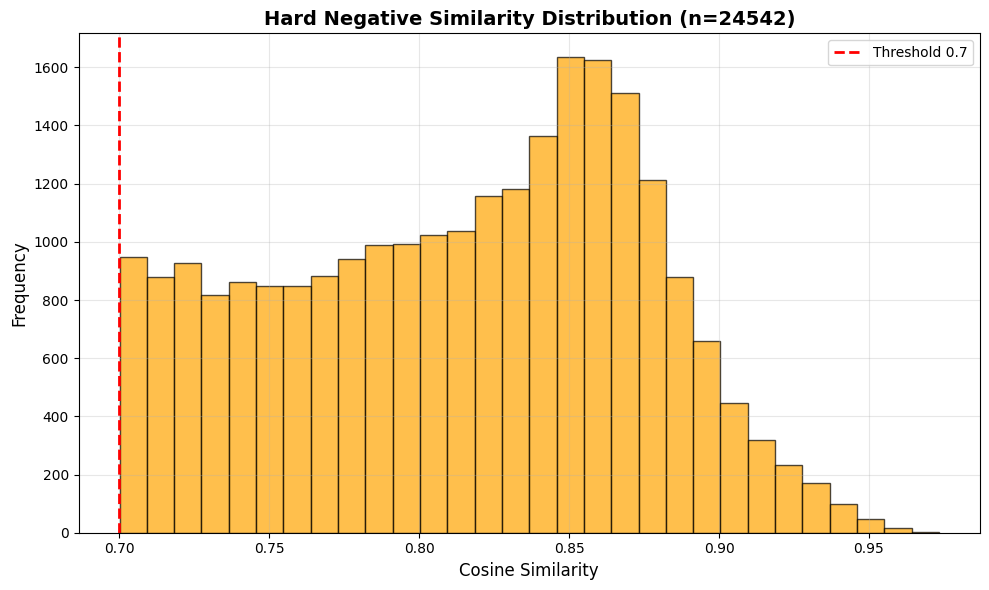


✅ Hard negative similarity plot generated


In [33]:
# Visualize Hard Negative Similarity Distribution
if len(labeled_pairs_hard) > 0 and 'similarity' in labeled_pairs_hard.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(labeled_pairs_hard['similarity'].values, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.axvline(HARD_NEGATIVE_SIMILARITY_THRESHOLD, color='red', linestyle='--', linewidth=2,
                label=f'Threshold {HARD_NEGATIVE_SIMILARITY_THRESHOLD}')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Hard Negative Similarity Distribution (n={len(labeled_pairs_hard)})', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print(f"\n✅ Hard negative similarity plot generated")
else:
    print(f"\n⚠️ No similarity data available for hard negatives")



VISUALIZATION: HARD NEGATIVE PAIRS - DISTANCE & TIME


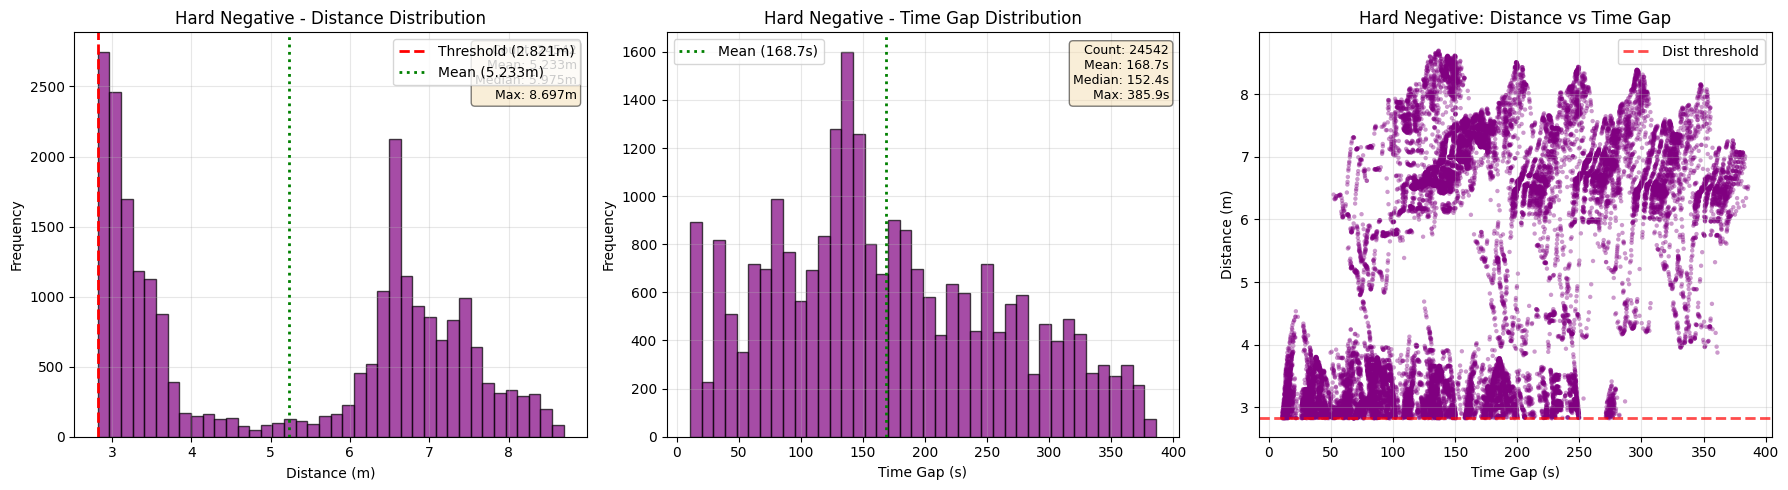


✅ Visualization complete


In [34]:
print("\n" + "="*70)
print("VISUALIZATION: HARD NEGATIVE PAIRS - DISTANCE & TIME")
print("="*70)

import matplotlib.pyplot as plt

# Extract data
hard_pair_ids = labeled_pairs_hard['node_pair_id'].values
hard_distances = df_all_pairs.loc[hard_pair_ids, 'distance_between_nodes_m'].values
hard_times = df_all_pairs.loc[hard_pair_ids, 'time_diff_secs'].values

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Distance histogram
axes[0].hist(hard_distances, bins=40, alpha=0.7, color='purple', edgecolor='black')
axes[0].axvline(HARD_NEGATIVE_MIN_DISTANCE, color='red', linestyle='--', linewidth=2, label=f'Threshold ({HARD_NEGATIVE_MIN_DISTANCE:.3f}m)')
axes[0].axvline(np.mean(hard_distances), color='green', linestyle=':', linewidth=2, label=f'Mean ({np.mean(hard_distances):.3f}m)')
axes[0].set_xlabel('Distance (m)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Hard Negative - Distance Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Statistics text
stats_text = f"Count: {len(hard_distances)}\nMean: {np.mean(hard_distances):.3f}m\nMedian: {np.median(hard_distances):.3f}m\nMax: {np.max(hard_distances):.3f}m"
axes[0].text(0.98, 0.97, stats_text, transform=axes[0].transAxes,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

# Plot 2: Time gap histogram
axes[1].hist(hard_times, bins=40, alpha=0.7, color='purple', edgecolor='black')
axes[1].axvline(np.mean(hard_times), color='green', linestyle=':', linewidth=2, label=f'Mean ({np.mean(hard_times):.1f}s)')
axes[1].set_xlabel('Time Gap (s)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Hard Negative - Time Gap Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Statistics text
stats_text = f"Count: {len(hard_times)}\nMean: {np.mean(hard_times):.1f}s\nMedian: {np.median(hard_times):.1f}s\nMax: {np.max(hard_times):.1f}s"
axes[1].text(0.98, 0.97, stats_text, transform=axes[1].transAxes,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

# Plot 3: Distance vs Time scatter
axes[2].scatter(hard_times, hard_distances, alpha=0.4, s=10, c='purple', edgecolors='none')
axes[2].axhline(HARD_NEGATIVE_MIN_DISTANCE, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Dist threshold')
axes[2].set_xlabel('Time Gap (s)')
axes[2].set_ylabel('Distance (m)')
axes[2].set_title('Hard Negative: Distance vs Time Gap')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Visualization complete")


### 6.6 Combine and Shuffle Dataset

In [35]:
print("\n" + "="*70)
print("COMBINING LABELED PAIRS")
print("="*70)

# Drop extra columns from each dataframe, keeping only node_pair_id and label
labeled_pairs_positive_clean = labeled_pairs_positive[['node_pair_id', 'label']].copy()
labeled_pairs_easy_clean = labeled_pairs_easy[['node_pair_id', 'label']].copy()
labeled_pairs_hard_clean = labeled_pairs_hard[['node_pair_id', 'label']].copy()

# Ensure node_pair_id is integer
labeled_pairs_positive_clean['node_pair_id'] = labeled_pairs_positive_clean['node_pair_id'].astype(int)
labeled_pairs_easy_clean['node_pair_id'] = labeled_pairs_easy_clean['node_pair_id'].astype(int)
labeled_pairs_hard_clean['node_pair_id'] = labeled_pairs_hard_clean['node_pair_id'].astype(int)

# Combine all labeled pairs into single DataFrame
labeled_pairs = pd.concat([
    labeled_pairs_positive_clean,
    labeled_pairs_easy_clean,
    labeled_pairs_hard_clean
], ignore_index=True)

print(f"\n✅ Labeled pairs combined:")
print(f"   Total pairs: {len(labeled_pairs)}")
print(f"\n   Positive:      {len(labeled_pairs_positive):5d} ({100*len(labeled_pairs_positive)/len(labeled_pairs):5.1f}%)")
print(f"   Easy negative: {len(labeled_pairs_easy):5d} ({100*len(labeled_pairs_easy)/len(labeled_pairs):5.1f}%)")
print(f"   Hard negative: {len(labeled_pairs_hard):5d} ({100*len(labeled_pairs_hard)/len(labeled_pairs):5.1f}%)")

actual_easy_ratio = len(labeled_pairs_easy) / len(labeled_pairs_positive) if len(labeled_pairs_positive) > 0 else 0
actual_hard_ratio = len(labeled_pairs_hard) / len(labeled_pairs_positive) if len(labeled_pairs_positive) > 0 else 0

print(f"\n   Actual ratios: {actual_easy_ratio:.2f}x easy / {actual_hard_ratio:.2f}x hard")
print(f"\n   DataFrame columns: {list(labeled_pairs.columns)}")
print(f"   Expected columns: ['node_pair_id', 'label']")

total = len(labeled_pairs)
n_positive = (labeled_pairs['label'] == 1).sum()
n_negative = (labeled_pairs['label'] == 0).sum()

print(f"\n   Label distribution: {n_positive} positive / {n_negative} negative")
print(f"\n💾 Labeled pairs ready for validation")



COMBINING LABELED PAIRS

✅ Labeled pairs combined:
   Total pairs: 58900

   Positive:      19634 ( 33.3%)
   Easy negative: 14724 ( 25.0%)
   Hard negative: 24542 ( 41.7%)

   Actual ratios: 0.75x easy / 1.25x hard

   DataFrame columns: ['node_pair_id', 'label']
   Expected columns: ['node_pair_id', 'label']

   Label distribution: 19634 positive / 39266 negative

💾 Labeled pairs ready for validation


In [36]:
print("\n" + "="*70)
print("SHUFFLING DATASET")
print("="*70)

# Shuffle the dataset
labeled_pairs = labeled_pairs.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

print(f"\n✅ Dataset shuffled (random_seed={RANDOM_SEED})")

# Display first 20 rows
print(f"\n📋 First 20 rows:")
display(labeled_pairs.head(20))

# Display last 20 rows
print(f"\n📋 Last 20 rows:")
display(labeled_pairs.tail(20))

# Quick label distribution check
first_20_pos = (labeled_pairs.head(20)['label'] == 1).sum()
last_20_pos = (labeled_pairs.tail(20)['label'] == 1).sum()
print(f"\n✓ First 20 rows: {first_20_pos} positive, {20-first_20_pos} negative")
print(f"✓ Last 20 rows: {last_20_pos} positive, {20-last_20_pos} negative")

print("="*70)



SHUFFLING DATASET

✅ Dataset shuffled (random_seed=42)

📋 First 20 rows:


,node_pair_id,label
0,652421,0
1,140441,0
2,240285,0
3,619907,0
4,618136,0
5,146560,0
6,646102,0
7,654459,0
8,471631,0
9,383464,0



📋 Last 20 rows:


,node_pair_id,label
58880,52759,1
58881,721140,0
58882,25797,1
58883,42463,1
58884,318337,0
58885,725841,1
58886,492105,0
58887,680786,0
58888,760005,0
58889,721470,0



✓ First 20 rows: 3 positive, 17 negative
✓ Last 20 rows: 9 positive, 11 negative


---

# SECTION 7: VALIDATIONS

Split, validate, visualize, report.

---



In [37]:
print("\n" + "="*70)
print("VALIDATING LABEL CONSISTENCY")
print("="*70)

# Check for duplicate node_pair_id values
duplicate_pairs = labeled_pairs[labeled_pairs.duplicated(subset=['node_pair_id'], keep=False)]

if len(duplicate_pairs) > 0:
    print(f"\n❌ ERROR: Found {len(duplicate_pairs)} duplicate node_pair_id entries!")
    print("\nDuplicate entries:")
    print(duplicate_pairs.sort_values('node_pair_id'))

    # Check for conflicting labels
    conflicting = duplicate_pairs.groupby('node_pair_id')['label'].nunique()
    conflicts = conflicting[conflicting > 1]

    if len(conflicts) > 0:
        print(f"\n❌ CRITICAL: {len(conflicts)} pairs have CONFLICTING LABELS!")
        for pair_id in conflicts.index:
            pair_data = labeled_pairs[labeled_pairs['node_pair_id'] == pair_id]
            print(f"  node_pair_id {pair_id}: labels = {pair_data['label'].tolist()}")
        raise ValueError("Dataset has pairs with conflicting labels!")
    else:
        print(f"\n⚠️  WARNING: Duplicates found but all have same label. Removing duplicates...")
        labeled_pairs = labeled_pairs.drop_duplicates(subset=['node_pair_id'], keep='first')
        print(f"✓ Removed duplicates. New size: {len(labeled_pairs)}")
else:
    print(f"\n✅ No duplicate node_pair_id entries found")

print(f"\n✅ Label consistency validated")
print("="*70)



VALIDATING LABEL CONSISTENCY

✅ No duplicate node_pair_id entries found

✅ Label consistency validated


### 7.1 Dataframes Visualitaions




DIAGNOSTIC VISUALIZATIONS (DATAFRAME-BASED)

Building feature matrix from dataframes...
Feature matrix built: (58644, 3072)
Valid pairs: 58644/58900

✅ Diagnostic plots (dataframe-based) saved: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/dataset/dataset_diagnostics_dataframe.png


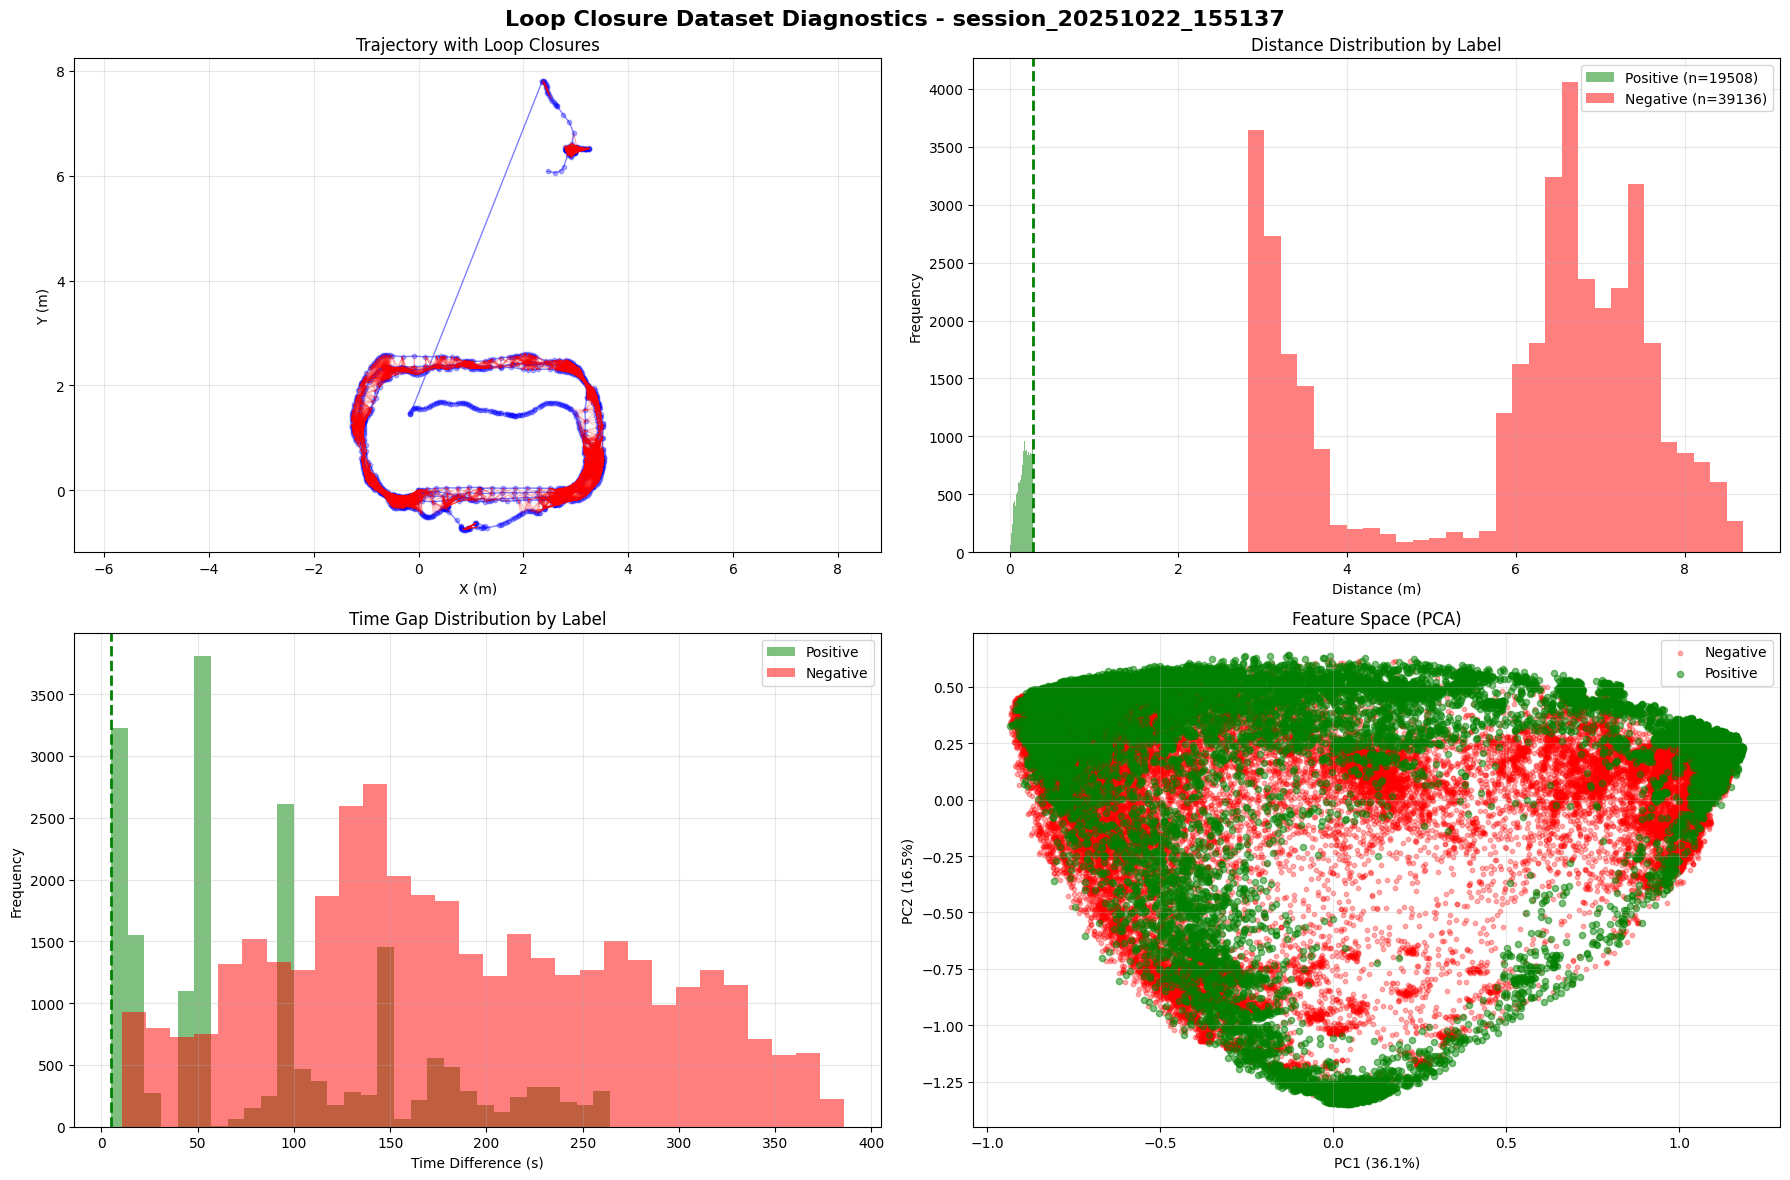

In [38]:
print("\n" + "="*70)
print("DIAGNOSTIC VISUALIZATIONS (DATAFRAME-BASED)")
print("="*70)

# Build feature matrix X and labels y from dataframes
print("\nBuilding feature matrix from dataframes...")

# Merge labeled_pairs with df_all_pairs to get node IDs and metrics
labeled_with_data = labeled_pairs.merge(df_all_pairs[['node1_id', 'node2_id', 'distance_between_nodes_m', 'time_diff_secs']],
                                         left_on='node_pair_id', right_index=True, how='left')

# Build feature matrix
X_list = []
y_list = []
valid_indices = []

for idx, row in labeled_with_data.iterrows():
    node1_id = int(row['node1_id'])
    node2_id = int(row['node2_id'])

    try:
        # Get alignment data
        node1_align = time_alignments[time_alignments['node_id'] == node1_id].iloc[0]
        node2_align = time_alignments[time_alignments['node_id'] == node2_id].iloc[0]

        # Check for NaN
        if pd.isna(node1_align['camera_feat_id']) or pd.isna(node1_align['lidar_feat_id']) or \
           pd.isna(node2_align['camera_feat_id']) or pd.isna(node2_align['lidar_feat_id']):
            continue

        # Extract feature indices
        cam1_idx = int(node1_align['camera_feat_id'])
        lid1_idx = int(node1_align['lidar_feat_id'])
        cam2_idx = int(node2_align['camera_feat_id'])
        lid2_idx = int(node2_align['lidar_feat_id'])

        # Concatenate features
        feat1 = np.concatenate([camera_features[cam1_idx], lidar_features[lid1_idx]])
        feat2 = np.concatenate([camera_features[cam2_idx], lidar_features[lid2_idx]])
        pairwise_feat = np.concatenate([feat1, feat2])

        X_list.append(pairwise_feat)
        y_list.append(int(row['label']))
        valid_indices.append(idx)
    except:
        continue

X = np.array(X_list)
y = np.array(y_list)
labeled_with_data_valid = labeled_with_data.loc[valid_indices]

print(f"Feature matrix built: {X.shape}")
print(f"Valid pairs: {len(valid_indices)}/{len(labeled_pairs)}")

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(f'Loop Closure Dataset Diagnostics - {SESSION_ID}', fontsize=16, fontweight='bold')

# Plot 1: Trajectory with loop closures
ax = axes[0, 0]
traj_x = df_trajectory['x_m'].values
traj_y = df_trajectory['y_m'].values
ax.plot(traj_x, traj_y, 'b-', alpha=0.5, linewidth=1, label='Trajectory')
ax.scatter(traj_x, traj_y, c='blue', s=10, alpha=0.3)

# Highlight positive pairs
positive_pairs = labeled_with_data_valid[labeled_with_data_valid['label'] == 1]
for _, pair in positive_pairs.iterrows():
    node1_id = int(pair['node1_id'])
    node2_id = int(pair['node2_id'])
    n1 = df_trajectory[df_trajectory['node_id'] == node1_id].iloc[0]
    n2 = df_trajectory[df_trajectory['node_id'] == node2_id].iloc[0]
    ax.plot([n1['x_m'], n2['x_m']], [n1['y_m'], n2['y_m']], 'r-', alpha=0.3, linewidth=0.5)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Trajectory with Loop Closures')
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Plot 2: Distance distribution by type
ax = axes[0, 1]
pos_distances = labeled_with_data_valid[labeled_with_data_valid['label'] == 1]['distance_between_nodes_m'].values
neg_distances = labeled_with_data_valid[labeled_with_data_valid['label'] == 0]['distance_between_nodes_m'].values

ax.hist(pos_distances, bins=30, alpha=0.5, label=f'Positive (n={len(pos_distances)})', color='green')
ax.hist(neg_distances, bins=30, alpha=0.5, label=f'Negative (n={len(neg_distances)})', color='red')
ax.axvline(POSITIVE_DISTANCE_THRESHOLD, color='green', linestyle='--', linewidth=2)
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Frequency')
ax.set_title('Distance Distribution by Label')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Time difference distribution
ax = axes[1, 0]
pos_times = labeled_with_data_valid[labeled_with_data_valid['label'] == 1]['time_diff_secs'].values
neg_times = labeled_with_data_valid[labeled_with_data_valid['label'] == 0]['time_diff_secs'].values

ax.hist(pos_times, bins=30, alpha=0.5, label=f'Positive', color='green')
ax.hist(neg_times, bins=30, alpha=0.5, label=f'Negative', color='red')
ax.axvline(POSITIVE_TIME_GAP, color='green', linestyle='--', linewidth=2)
ax.set_xlabel('Time Difference (s)')
ax.set_ylabel('Frequency')
ax.set_title('Time Gap Distribution by Label')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Feature space (PCA)
ax = axes[1, 1]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pos_mask = y == 1
ax.scatter(X_pca[~pos_mask, 0], X_pca[~pos_mask, 1], c='red', alpha=0.3, s=10, label='Negative')
ax.scatter(X_pca[pos_mask, 0], X_pca[pos_mask, 1], c='green', alpha=0.5, s=20, label='Positive')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('Feature Space (PCA)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save figure
DIAGNOSTICS_FILE_DF = os.path.join(BASE_PATH, 'dataset', 'dataset_diagnostics_dataframe.png')
plt.savefig(DIAGNOSTICS_FILE_DF, dpi=150, bbox_inches='tight')
print(f"\n✅ Diagnostic plots (dataframe-based) saved: {DIAGNOSTICS_FILE_DF}")

plt.show()

In [39]:
print("\n" + "="*70)
print("SKIPPING FEATURE-BASED VALIDATION")
print("="*70)
print("\n⏭️  Feature-based validation deferred to Section 8 (after assembly)")
print("   Basic validation completed in 7.2")


SKIPPING FEATURE-BASED VALIDATION

⏭️  Feature-based validation deferred to Section 8 (after assembly)
   Basic validation completed in 7.2


---

# SECTION 8: OUTPUT

Export trajectory, pairs, alignments, and labels to disk for dataset recreation.

---



### 8.1 Trajectory & Alignment Export

In [40]:
print("\n" + "="*70)
print("EXPORTING TRAJECTORY & ALIGNMENT DATA")
print("="*70)

import os

# Ensure dataset directory exists (use OUTPUT_DIR defined in Section 1)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Export trajectory
trajectory_file = os.path.join(OUTPUT_DIR, 'trajectory.parquet')
df_trajectory.to_parquet(trajectory_file, index=False)
print(f"\n✅ Trajectory exported: {trajectory_file}")
print(f"   Rows: {len(df_trajectory)}, Size: {os.path.getsize(trajectory_file) / 1024:.2f} KB")

# Export all pairs
all_pairs_file = os.path.join(OUTPUT_DIR, 'all_pairs.parquet')
df_all_pairs.to_parquet(all_pairs_file, index=True)
print(f"\n✅ All pairs exported: {all_pairs_file}")
print(f"   Rows: {len(df_all_pairs)}, Size: {os.path.getsize(all_pairs_file) / (1024*1024):.2f} MB")

# Export time alignments
alignments_file = os.path.join(OUTPUT_DIR, 'time_alignments.parquet')
time_alignments.to_parquet(alignments_file, index=False)
print(f"\n✅ Time alignments exported: {alignments_file}")
print(f"   Rows: {len(time_alignments)}, Size: {os.path.getsize(alignments_file) / 1024:.2f} KB")

print(f"\n" + "="*70)
print("✅ Trajectory & alignment export complete")
print("="*70)



EXPORTING TRAJECTORY & ALIGNMENT DATA

✅ Trajectory exported: dataset/trajectory.parquet
   Rows: 1255, Size: 70.08 KB

✅ All pairs exported: dataset/all_pairs.parquet
   Rows: 786885, Size: 16.33 MB

✅ Time alignments exported: dataset/time_alignments.parquet
   Rows: 1255, Size: 38.18 KB

✅ Trajectory & alignment export complete


### 8.2 Label & Metadata Export

In [41]:
print("\n" + "="*70)
print("EXPORTING LABELS & METADATA")
print("="*70)

import json

# Export labeled pairs
labels_file = os.path.join(OUTPUT_DIR, 'labeled_pairs.parquet')
labeled_pairs.to_parquet(labels_file, index=False)
print(f"\n✅ Labeled pairs exported: {labels_file}")
print(f"   Rows: {len(labeled_pairs)}, Size: {os.path.getsize(labels_file) / 1024:.2f} KB")

# Create metadata dictionary
export_metadata = {
    'session_info': {
        'session_id': SESSION_ID,
        'creation_date': str(np.datetime64('today')),
        'random_seed': RANDOM_SEED,
        'notebook_version': '6.10'
    },
    'thresholds': {
        'max_time_offset_ms': MAX_TIME_OFFSET,
        'positive_distance_threshold_m': float(POSITIVE_DISTANCE_THRESHOLD),
        'positive_time_gap_s': float(POSITIVE_TIME_GAP),
        'easy_negative_min_distance_m': float(EASY_NEGATIVE_MIN_DISTANCE),
        'easy_negative_min_temporal_gap_s': float(EASY_NEG_MIN_TEMPORAL_GAP),
        'hard_negative_min_distance_m': float(HARD_NEGATIVE_MIN_DISTANCE),
        'hard_negative_similarity_threshold': float(HARD_NEGATIVE_SIMILARITY_THRESHOLD),
        'hard_negative_similarity_fallback': [float(x) for x in HARD_NEGATIVE_SIMILARITY_FALLBACK],
        'max_constraint_residual': MAX_CONSTRAINT_RESIDUAL,
        'max_angular_distance_rad': MAX_ANGULAR_DISTANCE
    },
    'counts': {
        'trajectory_nodes': len(df_trajectory),
        'valid_aligned_nodes': len(complete_alignments),
        'total_pairs': len(df_all_pairs),
        'inter_submap_constraints': len(loop_closure_pairs_all) if 'loop_closure_pairs_all' in locals() else 0,
        'valid_loop_closures': len(loop_closure_pairs) if 'loop_closure_pairs' in locals() else 0,
        'loop_closure_outliers': len(loop_closure_outliers) if 'loop_closure_outliers' in locals() else 0,
        'total_labeled_pairs': len(labeled_pairs),
        'positive_pairs': int((labeled_pairs['label'] == 1).sum()),
        'negative_pairs': int((labeled_pairs['label'] == 0).sum()),
        'easy_negative_pairs': len(labeled_pairs_easy),
        'hard_negative_pairs': len(labeled_pairs_hard)
    },
    'feature_dimensions': {
        'camera_features': int(camera_features.shape[1]),
        'lidar_features': int(lidar_features.shape[1]),
        'concatenated_features': int(camera_features.shape[1] + lidar_features.shape[1])
    },
    'ratios': {
        'easy_negative_ratio': float(EASY_NEGATIVE_RATIO),
        'hard_negative_ratio': float(HARD_NEGATIVE_RATIO)
    }
}

# Export metadata as JSON
metadata_file = os.path.join(OUTPUT_DIR, 'export_metadata.json')
with open(metadata_file, 'w') as f:
    json.dump(export_metadata, f, indent=2)

print(f"\n✅ Metadata exported: {metadata_file}")
print(f"   Size: {os.path.getsize(metadata_file) / 1024:.2f} KB")

# Print summary
print(f"\n📊 Export Summary:")
print(f"   Session: {SESSION_ID}")
print(f"   Trajectory nodes: {export_metadata['counts']['trajectory_nodes']}")
print(f"   All pairs: {export_metadata['counts']['total_pairs']:,}")
print(f"   Labeled pairs: {export_metadata['counts']['total_labeled_pairs']:,}")
print(f"     - Positive: {export_metadata['counts']['positive_pairs']:,}")
print(f"     - Easy negative: {export_metadata['counts']['easy_negative_pairs']:,}")
print(f"     - Hard negative: {export_metadata['counts']['hard_negative_pairs']:,}")
print(f"   Feature dimensions: Camera={export_metadata['feature_dimensions']['camera_features']}, "
      f"LiDAR={export_metadata['feature_dimensions']['lidar_features']}")

print(f"\n" + "="*70)
print("✅ ALL EXPORTS COMPLETE")
print("="*70)
print(f"\n📁 Export location: {OUTPUT_DIR}")
print(f"\n📦 Exported files:")
print(f"   1. trajectory.parquet")
print(f"   2. all_pairs.parquet")
print(f"   3. time_alignments.parquet")
print(f"   4. labeled_pairs.parquet")
print(f"   5. export_metadata.json")
print(f"\n💡 To recreate dataset: Load these files + HDF5 features from features/features.h5")



EXPORTING LABELS & METADATA

✅ Labeled pairs exported: dataset/labeled_pairs.parquet
   Rows: 58900, Size: 403.57 KB

✅ Metadata exported: dataset/export_metadata.json
   Size: 1.23 KB

📊 Export Summary:
   Session: session_20251022_155137
   Trajectory nodes: 1255
   All pairs: 786,885
   Labeled pairs: 58,900
     - Positive: 19,634
     - Easy negative: 14,724
     - Hard negative: 24,542
   Feature dimensions: Camera=1280, LiDAR=256

✅ ALL EXPORTS COMPLETE

📁 Export location: dataset

📦 Exported files:
   1. trajectory.parquet
   2. all_pairs.parquet
   3. time_alignments.parquet
   4. labeled_pairs.parquet
   5. export_metadata.json

💡 To recreate dataset: Load these files + HDF5 features from features/features.h5


### 8.3 Text Report

In [42]:
print("Generating final report...")

file_size_mb = os.path.getsize(labels_file) / (1024 * 1024)

report = f"""
{'='*70}
LOOP CLOSURE DATASET GENERATION REPORT
{'='*70}

SESSION INFORMATION:
  • Session ID: {SESSION_ID}
  • Generation date: {np.datetime64('today')}
  • Pipeline version: 6.10
  • Random seed: {RANDOM_SEED}

INPUT DATA:
  • Trajectory nodes: {len(df_trajectory)}
  • Valid nodes (both modalities): {len(time_alignments)}
  • Camera features: {len(camera_features)} (aligned: {len(time_alignments[~time_alignments['camera_feat_id'].isna()])})
  • LiDAR features: {len(lidar_features)} (aligned: {len(time_alignments[~time_alignments['lidar_feat_id'].isna()])})
  • INTER_SUBMAP constraints: {len(loop_closure_pairs)}

DATASET COMPOSITION:
  • Total labeled pairs: {len(labeled_pairs)}
  • Positive pairs: {len(labeled_pairs_positive)} ({100*len(labeled_pairs_positive)/len(labeled_pairs):.1f}%)
  • Easy negative pairs: {len(labeled_pairs_easy)} ({100*len(labeled_pairs_easy)/len(labeled_pairs):.1f}%)
  • Hard negative pairs: {len(labeled_pairs_hard)} ({100*len(labeled_pairs_hard)/len(labeled_pairs):.1f}%)

FEATURE DIMENSIONS:
  • Camera features: {camera_features.shape[1]}D
  • LiDAR features: {lidar_features.shape[1]}D
  • Concatenated per node: {camera_features.shape[1] + lidar_features.shape[1]}D
  • Pairwise (node1 + node2): {2 * (camera_features.shape[1] + lidar_features.shape[1])}D

OUTPUT FILES:
  • Labeled pairs: labeled_pairs.parquet ({file_size_mb:.2f} MB)
  • Trajectory: trajectory.parquet
  • All pairs: all_pairs.parquet
  • Time alignments: time_alignments.parquet
  • Metadata: export_metadata.json

NEXT STEPS:
  1. Run Section 9 to load exported data and assemble full dataset with features
  2. Dataset will be ready for training after Section 9 completes
  3. Train Fusion MLP (Phase 2): 1536→512→128→1 architecture
  4. Use BCE loss + hard negative mining
  5. Export to ONNX/TensorRT for Jetson Nano deployment


{'='*70}
"""

print(report)

# Save report
with open(REPORT_FILE, 'w') as f:
    f.write(report)

print("\n✅ Final report saved to: dataset_generation_report.txt")
print("\n✅ Section 8 export complete - proceed to Section 9 for dataset assembly")


Generating final report...

LOOP CLOSURE DATASET GENERATION REPORT

SESSION INFORMATION:
  • Session ID: session_20251022_155137
  • Generation date: 2025-11-13
  • Pipeline version: 6.10
  • Random seed: 42

INPUT DATA:
  • Trajectory nodes: 1255
  • Valid nodes (both modalities): 1255
  • Camera features: 7193 (aligned: 1242)
  • LiDAR features: 2973 (aligned: 1255)
  • INTER_SUBMAP constraints: 312

DATASET COMPOSITION:
  • Total labeled pairs: 58900
  • Positive pairs: 19634 (33.3%)
  • Easy negative pairs: 14724 (25.0%)
  • Hard negative pairs: 24542 (41.7%)

FEATURE DIMENSIONS:
  • Camera features: 1280D
  • LiDAR features: 256D
  • Concatenated per node: 1536D
  • Pairwise (node1 + node2): 3072D

OUTPUT FILES:
  • Labeled pairs: labeled_pairs.parquet (0.39 MB)
  • Trajectory: trajectory.parquet
  • All pairs: all_pairs.parquet
  • Time alignments: time_alignments.parquet
  • Metadata: export_metadata.json

NEXT STEPS:
  1. Run Section 9 to load exported data and assemble full da

---

## 8.4 EXPORT FILE STRUCTURE DOCUMENTATION

This section provides comprehensive documentation of all exported files, their schemas, data types, and relationships.

---

### 8.4.1 Overview of Exported Files

Section 8 exports **5 files** that capture the complete dataset generation state:

1. **trajectory.parquet** - SLAM trajectory nodes with poses and timestamps
2. **all_pairs.parquet** - Pairwise distance and time relationships between all nodes
3. **time_alignments.parquet** - Feature-to-trajectory temporal alignment results
4. **labeled_pairs.parquet** - Labeled training pairs (positive/negative)
5. **export_metadata.json** - Configuration and statistics

These files work together to enable dataset recreation in Section 9, where features from HDF5 are assembled with labels to create the final training dataset.

**Key Relationships:**
- `node_id` links trajectory.parquet → time_alignments.parquet
- `node_pair_id` links labeled_pairs.parquet → all_pairs.parquet
- `node1_id` and `node2_id` in all_pairs.parquet reference `node_id` in trajectory.parquet
- `camera_feat_id` and `lidar_feat_id` in time_alignments.parquet reference indices in features.h5

### 8.4.2 trajectory.parquet

**Purpose:** Contains all SLAM trajectory nodes extracted from Cartographer's pbstream file.

**Schema:**

| Column | Type | Description | Example Value |
|--------|------|-------------|---------------|
| `node_id` | int64 | Unique trajectory node identifier | 42 |
| `trajectory_id` | int64 | Trajectory identifier (usually 0 for single robot) | 0 |
| `timestamp_sec` | int64 | ROS timestamp seconds component | 1634567890 |
| `timestamp_nsec` | int32 | ROS timestamp nanoseconds component | 123456789 |
| `timestamp_float` | float64 | Combined timestamp as float (sec.nsec) | 1634567890.123 |
| `x_m` | float64 | X position in meters (map frame) | 1.234 |
| `y_m` | float64 | Y position in meters (map frame) | -0.567 |
| `z_m` | float64 | Z position in meters (map frame) | 0.0 |
| `qx` | float64 | Quaternion X component | 0.0 |
| `qy` | float64 | Quaternion Y component | 0.0 |
| `qz` | float64 | Quaternion Z component | 0.707 |
| `qw` | float64 | Quaternion W component | 0.707 |
| `yaw_rad` | float64 | Yaw angle in radians | 1.571 |

**Key Properties:**
- Each row represents one trajectory node
- `node_id` is the primary key
- Timestamps are split into sec/nsec for precision, with float64 for algorithms
- Poses are in the SLAM map coordinate frame
- For 2D SLAM, Z is typically 0 and only yaw rotation is meaningful

**Typical Row Count:** 500-5000 nodes depending on session duration

### 8.4.3 all_pairs.parquet

**Purpose:** Pre-computed pairwise distances and time differences between all trajectory nodes. This massive lookup table enables efficient pair generation without recomputing spatial/temporal relationships.

**Schema:**

| Column | Type | Description | Example Value |
|--------|------|-------------|---------------|
| `node_pair_id` (index) | int64 | Unique pair identifier (row index) | 1234567 |
| `node1_id` | int64 | First node ID (references trajectory.parquet) | 42 |
| `node2_id` | int64 | Second node ID (references trajectory.parquet) | 156 |
| `distance_between_nodes_m` | float64 | Euclidean distance between node poses (meters) | 2.345 |
| `time_diff_secs` | float64 | Time difference between nodes (seconds) | 45.678 |

**Key Properties:**
- Each row represents one unique node pair combination
- `node_pair_id` is the index and serves as the primary key
- For N trajectory nodes, this contains N×(N-1)/2 rows (all unique pairs)
- Distance is computed from (x,y,z) positions in trajectory.parquet
- Time difference is always positive (|t1 - t2|)
- Both `node1_id` and `node2_id` are foreign keys to trajectory.parquet

**Typical Row Count:** 125,000 to 12,500,000 pairs (500 nodes → 125K pairs, 5000 nodes → 12.5M pairs)

**File Size:** Can be large (10-500 MB) due to quadratic growth with trajectory length

### 8.4.4 time_alignments.parquet

**Purpose:** Maps trajectory nodes to their temporally-aligned camera and LiDAR features. This is the critical bridge between SLAM trajectory and extracted sensor features.

**Schema:**

| Column | Type | Description | Example Value |
|--------|------|-------------|---------------|
| `node_id` | int64 | Trajectory node ID (references trajectory.parquet) | 42 |
| `node_timestamp` | float64 | Node timestamp as float (seconds) | 1634567890.123 |
| `camera_feat_id` | float64 | Index into features.h5/camera/features (NaN if no match) | 15.0 or NaN |
| `camera_timestamp` | float64 | Camera feature timestamp (seconds, NaN if no match) | 1634567890.089 |
| `camera_time_offset` | float64 | |node_time - camera_time| (seconds, NaN if no match) | 0.034 |
| `lidar_feat_id` | float64 | Index into features.h5/lidar/features (NaN if no match) | 52.0 or NaN |
| `lidar_timestamp` | float64 | LiDAR feature timestamp (seconds, NaN if no match) | 1634567890.201 |
| `lidar_time_offset` | float64 | |node_time - lidar_time| (seconds, NaN if no match) | 0.078 |

**Key Properties:**
- Each row represents one trajectory node
- `node_id` is the primary key (foreign key to trajectory.parquet)
- Feature IDs are stored as float64 to accommodate NaN for missing alignments
- **NaN values** indicate no temporal match within MAX_TIME_OFFSET threshold
- Time offsets show alignment quality (smaller = better temporal match)
- `camera_feat_id` and `lidar_feat_id` are array indices (0-based) into HDF5 feature arrays
- Only nodes with **both** camera_feat_id and lidar_feat_id non-NaN can be used for training

**Typical Coverage:** 60-90% of trajectory nodes successfully aligned with both modalities

**Usage:** When assembling features in Section 9, use these indices to retrieve the correct feature vectors from features.h5

### 8.4.5 labeled_pairs.parquet

**Purpose:** Final labeled dataset containing positive (loop closure) and negative (non-loop-closure) pairs ready for supervised learning.

**Schema:**

| Column | Type | Description | Example Value |
|--------|------|-------------|---------------|
| `node_pair_id` | int64 | Pair identifier (foreign key to all_pairs.parquet index) | 1234567 |
| `label` | int64 | Binary label (1 = loop closure, 0 = negative) | 1 |
| `pair_type` | object (string) | Pair category: 'positive', 'easy_negative', or 'hard_negative' | 'positive' |

**Key Properties:**
- Each row represents one labeled training example
- `node_pair_id` references the index of all_pairs.parquet to get node1_id, node2_id, distance, time_diff
- **Label encoding:** 1 = positive (true loop closure), 0 = negative (not a loop closure)
- **Pair types:**
  - `positive`: True loop closures from INTER_SUBMAP constraints (label=1)
  - `easy_negative`: Spatially distant pairs (label=0)
  - `hard_negative`: Perceptually similar but spatially distant (label=0)
- All pairs in this file have valid feature alignments (both camera and LiDAR)

**Typical Distribution:**
- Positive: 30% of dataset
- Easy negative: 20-25% of dataset
- Hard negative: 45-50% of dataset

**Typical Row Count:** 1,000 to 10,000 pairs depending on trajectory complexity and loop closures

### 8.4.6 export_metadata.json

**Purpose:** Human-readable configuration file containing all parameters, thresholds, and statistics from the dataset generation process.

**Structure:**

**session_info:**
- `session_id`: Session folder identifier
- `creation_date`: Export timestamp
- `random_seed`: Random seed for reproducibility (42)
- `notebook_version`: Pipeline version number (6.10)

**thresholds:**
- `max_time_offset_ms`: Temporal alignment threshold (700 ms)
- `positive_distance_threshold_m`: Maximum distance for positive pairs (0.3 m)
- `positive_time_gap_s`: Minimum time gap for positive pairs (10 s)
- `easy_negative_min_distance_m`: Minimum distance for easy negatives (1.0 m)
- `easy_negative_min_temporal_gap_s`: Minimum time gap for easy negatives (5 s)
- `hard_negative_min_distance_m`: Minimum distance for hard negatives (3.0 m)
- `hard_negative_similarity_threshold`: Cosine similarity threshold (0.7)
- `hard_negative_similarity_fallback`: Fallback thresholds array [0.7, 0.65, 0.6, 0.55]
- `max_constraint_residual`: INTER_SUBMAP validation threshold (0.5 m)
- `max_angular_distance_rad`: Maximum angular difference (π/2 rad)

**counts:**
- `trajectory_nodes`: Total trajectory nodes extracted
- `valid_aligned_nodes`: Nodes with both camera and LiDAR features
- `total_pairs`: Total pairs in all_pairs.parquet
- `inter_submap_constraints`: Raw INTER_SUBMAP constraints from pbstream
- `valid_loop_closures`: Constraints passing validation filters
- `loop_closure_outliers`: Rejected constraints (high residual/angular error)
- `total_labeled_pairs`: Final labeled pairs count
- `positive_pairs`: Count of positive examples
- `negative_pairs`: Count of negative examples
- `easy_negative_pairs`: Count of easy negatives
- `hard_negative_pairs`: Count of hard negatives

**feature_dimensions:**
- `camera_features`: Camera feature dimension (1280 for MobileNetV2)
- `lidar_features`: LiDAR feature dimension (256 for 1D-CNN)
- `concatenated_features`: Combined dimension per node (1536)

**ratios:**
- `easy_negative_ratio`: Easy negative multiplier relative to positives (0.75)
- `hard_negative_ratio`: Hard negative multiplier relative to positives (1.25)

**Key Properties:**
- JSON format for easy parsing and human readability
- Contains all information needed to understand dataset generation parameters
- Useful for experiment tracking and reproducibility
- Thresholds can be reviewed to understand dataset characteristics

### 8.4.7 File Relationships & Output Structure

**Primary Keys & Foreign Keys:**

```
trajectory.parquet
└─ node_id (PK)
   ├─ Referenced by: time_alignments.node_id (FK)
   ├─ Referenced by: all_pairs.node1_id (FK)
   └─ Referenced by: all_pairs.node2_id (FK)

all_pairs.parquet
└─ node_pair_id (PK, index)
   └─ Referenced by: labeled_pairs.node_pair_id (FK)

time_alignments.parquet
├─ camera_feat_id → features.h5/camera/features[index]
└─ lidar_feat_id → features.h5/lidar/features[index]
```

**Expected Output File/Folder Structure:**

```
session_YYYYMMDD_HHMMSS/          (base working folder)
├── map.pbstream                  (input)
├── session_data.bag              (input, optional)
├── features/                     (input from feature extraction)
│   └── features.h5
└── dataset/                      ← OUTPUT DIRECTORY (created by Section 8)
    ├── trajectory.parquet        ← SLAM trajectory nodes with poses and timestamps
    ├── all_pairs.parquet         ← Pairwise distance/time relationships (all node combinations)
    ├── time_alignments.parquet   ← Feature-to-trajectory temporal alignment results
    ├── labeled_pairs.parquet     ← Labeled training pairs (positive/negative/hard)
    └── export_metadata.json      ← Dataset generation configuration and statistics
```

**File Size Expectations:**
- **trajectory.parquet**: ~100-500 KB (depends on trajectory length)
- **all_pairs.parquet**: ~10-500 MB (scales quadratically with number of nodes)
- **time_alignments.parquet**: ~50-200 KB (one row per trajectory node)
- **labeled_pairs.parquet**: ~50-500 KB (depends on number of generated pairs)
- **export_metadata.json**: ~5-10 KB (configuration and statistics)

**Critical Invariants:**
- Every `node_pair_id` in labeled_pairs.parquet MUST exist in all_pairs.parquet index
- Every `node1_id` and `node2_id` in all_pairs.parquet MUST exist in trajectory.parquet
- Every `node_id` in labeled pairs (through all_pairs) MUST have non-NaN camera_feat_id and lidar_feat_id in time_alignments.parquet
- Every camera_feat_id and lidar_feat_id MUST be valid indices in features.h5 arrays

---

# SECTION 9: DATASET ASSEMBLY

---



## 9.0 SECTION 9 DOCUMENTATION

---

### 9.0.1 What This Section Does

Section 9 performs the final assembly of the loop closure detection dataset by combining multi-modal features with labeled node pairs to create ready-to-train datasets. This section bridges the gap between the intermediate parquet files generated in Section 8 and the final machine learning training pipeline.

**Core Operations:**

**Data Loading & Validation:**
- Loads all five parquet files from Section 8 (trajectory, all_pairs, time_alignments, labeled_pairs, export_metadata)
- Loads extracted features from features.h5 (camera: 1280D MobileNetV2, LiDAR: 256D 1D-CNN)
- Validates referential integrity across all data files
- Checks feature dimension consistency against metadata
- Verifies temporal alignment coverage and quality

**Data Assembly Flow:**

1. **Load labeled_pairs.parquet** → Extract (node_pair_id, label, pair_type) for all training pairs

2. **Lookup in all_pairs.parquet[node_pair_id]** → Retrieve (node1_id, node2_id, distance, time_diff) for each pair

3. **Lookup in time_alignments.parquet** → Query by node1_id and node2_id to obtain:
   - camera_feat_id and lidar_feat_id for node1
   - camera_feat_id and lidar_feat_id for node2

4. **Load features from features.h5** → Extract multi-modal features:
   - camera_features[camera_feat_id] → 1280D vector (L2-normalized MobileNetV2 embeddings)
   - lidar_features[lidar_feat_id] → 256D vector (L2-normalized 1D-CNN descriptors)
   - Concatenate into pairwise feature: [camera1 + lidar1 + camera2 + lidar2] → 3072D vector

5. **Create training examples** → Assemble final dataset with:
   - Pairwise features: 3072D concatenated multi-modal descriptor
   - Binary labels: 1 (loop closure) or 0 (no loop closure)
   - Metadata: node IDs, distances, time differences, pair types

**Dataset Splitting:**
- Performs stratified train/validation/test split maintaining label balance
- Default split ratios: 70% train, 15% validation, 15% test
- Ensures all three pair types (positive, easy negative, hard negative) are represented in each split
- Validates class balance and feature statistics across splits

**Quality Assurance:**
- Computes feature statistics (mean, variance, low-variance feature detection)
- Generates diagnostic visualizations (trajectory plots, distance distributions, PCA projections)
- Creates comprehensive text reports with dataset statistics
- Validates no data leakage between splits

**Final Output:**
- Exports assembled dataset as pickle file (loop_closure_dataset.pkl)
- Saves diagnostic plots (dataset_diagnostics.png)
- Generates human-readable summary report (dataset_generation_report.txt)
- Packages metadata including configuration, dimensions, and statistics

**Purpose in Pipeline:**
This section transforms raw parquet files and feature vectors into a structured, validated, and split dataset ready for supervised learning. The output pkl file can be directly consumed by the Fusion MLP training pipeline without additional preprocessing. All feature vectors are pre-normalized, temporally aligned, and labeled with high-confidence ground truth from Cartographer's SLAM graph.

### 9.0.2 Expected Input Files

Section 9 requires six input files generated from previous pipeline stages. All files must be present and properly formatted, as missing or corrupted files will cause the assembly process to fail.

---

**Required Input Directory Structure:**

```
session_YYYYMMDD_HHMMSS/
├── features/
│   └── features.h5               ← INPUT: Multi-modal feature vectors
└── dataset/
    ├── trajectory.parquet        ← INPUT: SLAM trajectory nodes
    ├── all_pairs.parquet         ← INPUT: Pairwise node relationships
    ├── time_alignments.parquet   ← INPUT: Feature temporal alignments
    ├── labeled_pairs.parquet     ← INPUT: Labeled training pairs
    └── export_metadata.json      ← INPUT: Dataset generation metadata
```

---

#### **1. features.h5** (Feature Extraction Output)

**Location:** `features/features.h5`  
**Source:** Feature extraction pipeline (preceding notebook)  
**Format:** HDF5 hierarchical data structure

**Contents:**

**Camera Features Group (`/camera/`):**
- `features`: [N_cam, 1280] float32 array - MobileNetV2 embeddings, L2-normalized
- `timestamps_sec`: [N_cam] int64 array - ROS timestamp seconds
- `timestamps_nsec`: [N_cam] int32 array - ROS timestamp nanoseconds
- `filenames`: [N_cam] string array - Source image filenames for traceability

**LiDAR Features Group (`/lidar/`):**
- `features`: [N_lid, 256] float32 array - 1D-CNN descriptors, L2-normalized
- `timestamps_sec`: [N_lid] int64 array - ROS timestamp seconds
- `timestamps_nsec`: [N_lid] int32 array - ROS timestamp nanoseconds
- `filenames`: [N_lid] string array - Source scan filenames for traceability

**Critical Properties:**
- All feature vectors are L2-normalized (unit length)
- Camera and LiDAR feature counts may differ due to independent sensor rates
- Timestamps are high-precision (nanosecond resolution) ROS format
- Feature dimensions must match metadata specifications (1280 for camera, 256 for LiDAR)

---

#### **2. trajectory.parquet** (SLAM Trajectory Nodes)

**Location:** `dataset/trajectory.parquet`  
**Source:** Section 8 - Pbstream extraction  
**Format:** Apache Parquet columnar format

**Schema:**

| Column | Type | Description | Example |
|--------|------|-------------|----------|
| `node_id` | int64 | Unique trajectory node identifier (PRIMARY KEY) | 42 |
| `timestamp_sec` | int64 | ROS timestamp seconds | 1634567890 |
| `timestamp_nsec` | int32 | ROS timestamp nanoseconds | 123456789 |
| `x_m` | float64 | X position in meters (global frame) | 2.456 |
| `y_m` | float64 | Y position in meters (global frame) | -1.234 |
| `z_m` | float64 | Z position in meters (global frame) | 0.003 |
| `qx` | float64 | Quaternion X component | 0.001 |
| `qy` | float64 | Quaternion Y component | 0.002 |
| `qz` | float64 | Quaternion Z component | 0.707 |
| `qw` | float64 | Quaternion W component | 0.707 |

**Properties:**
- One row per SLAM trajectory node extracted from Cartographer pbstream
- `node_id` serves as primary key referenced by other tables
- Full 6-DOF pose representation (position + orientation quaternion)
- Timestamps enable temporal alignment with sensor features
- Typical size: 100-500 KB for sessions of 5-30 minutes

---

#### **3. all_pairs.parquet** (Pairwise Node Relationships)

**Location:** `dataset/all_pairs.parquet`  
**Source:** Section 8 - Pairwise distance computation  
**Format:** Apache Parquet with indexed primary key

**Schema:**

| Column | Type | Description | Example |
|--------|------|-------------|----------|
| `node_pair_id` | int64 | Unique pair identifier (PRIMARY KEY, stored as index) | 1234567 |
| `node1_id` | int64 | First node ID (FOREIGN KEY → trajectory.node_id) | 42 |
| `node2_id` | int64 | Second node ID (FOREIGN KEY → trajectory.node_id) | 156 |
| `distance` | float64 | Euclidean distance between nodes in meters | 1.23 |
| `time_diff` | float64 | Time difference between nodes in seconds | 45.67 |

**Properties:**
- Contains all possible node pairs (combinatorial: N*(N-1)/2 pairs)
- `node_pair_id` is stored as dataframe index (accessible via .loc[])
- Distance computed from 3D Euclidean distance: sqrt((x1-x2)² + (y1-y2)² + (z1-z2)²)
- Time difference computed from ROS timestamps with nanosecond precision
- Both node1_id and node2_id reference trajectory.parquet node_id column
- Largest file in dataset: scales O(N²) with trajectory length
- Typical size: 10-500 MB depending on session duration

---

#### **4. time_alignments.parquet** (Feature Temporal Alignments)

**Location:** `dataset/time_alignments.parquet`  
**Source:** Section 8 - KD-tree temporal alignment  
**Format:** Apache Parquet

**Schema:**

| Column | Type | Description | Example |
|--------|------|-------------|----------|
| `node_id` | int64 | Trajectory node ID (PRIMARY KEY, FOREIGN KEY → trajectory.node_id) | 42 |
| `camera_feat_id` | float64 | Camera feature index in features.h5 (NaN if no match) | 15.0 or NaN |
| `lidar_feat_id` | float64 | LiDAR feature index in features.h5 (NaN if no match) | 23.0 or NaN |
| `camera_time_offset` | float64 | Time offset to camera feature in seconds | 0.234 |
| `lidar_time_offset` | float64 | Time offset to LiDAR feature in seconds | -0.156 |

**Properties:**
- One row per trajectory node (matches trajectory.parquet row count)
- `node_id` is primary key and foreign key to trajectory.parquet
- Feature IDs reference array indices in features.h5 datasets
- NaN values indicate no feature found within temporal alignment threshold (±700ms default)
- Time offsets indicate alignment quality (smaller absolute values = better temporal sync)
- Only nodes with both non-NaN camera_feat_id and lidar_feat_id can be used in final dataset
- Typical size: 50-200 KB

---

#### **5. labeled_pairs.parquet** (Labeled Training Pairs)

**Location:** `dataset/labeled_pairs.parquet`  
**Source:** Section 8 - Pair generation and labeling  
**Format:** Apache Parquet

**Schema:**

| Column | Type | Description | Example |
|--------|------|-------------|----------|
| `node_pair_id` | int64 | Pair identifier (FOREIGN KEY → all_pairs.parquet index) | 1234567 |
| `label` | int8 | Binary label: 1=loop closure, 0=no loop closure | 1 |
| `pair_type` | string | Pair generation strategy | 'positive' |

**Pair Types:**
- **'positive'**: True loop closures from Cartographer INTER_SUBMAP constraints
- **'easy_negative'**: Spatially distant pairs (>5m distance, >5s temporal gap)
- **'hard_negative'**: Perceptually similar but spatially distant pairs (high feature similarity, >3m distance)

**Properties:**
- Contains only validated pairs with complete feature alignments (no NaN in time_alignments)
- `node_pair_id` references the index of all_pairs.parquet to retrieve node1_id, node2_id, distance, time_diff
- Every node_pair_id in this file MUST exist in all_pairs.parquet
- Both nodes in each pair MUST have non-NaN feature IDs in time_alignments.parquet
- Label distribution typically: ~30% positive, ~35% easy negative, ~35% hard negative
- Typical size: 50-500 KB depending on trajectory complexity

---

#### **6. export_metadata.json** (Dataset Generation Metadata)

**Location:** `dataset/export_metadata.json`  
**Source:** Section 8 - Configuration and statistics export  
**Format:** JSON (human-readable text)

**Contents:**

**Configuration Parameters:**
- Temporal alignment threshold (MAX_TIME_OFFSET)
- Distance thresholds for positive/negative pair generation
- Similarity thresholds for hard negative mining
- Angular distance constraints
- Random seed for reproducibility

**Statistics:**
- Total trajectory nodes and valid alignments
- INTER_SUBMAP constraint counts
- Positive/negative pair counts by type
- Feature dimension specifications
- Alignment coverage percentages

**Session Information:**
- Session ID and creation timestamp
- Source file paths
- Processing duration

**Properties:**
- Used for validation and consistency checking in Section 9
- Enables reproducibility of dataset generation
- Documents configuration for experiment tracking
- Typical size: 5-10 KB

---

**File Dependencies & Integrity Requirements:**

**Mandatory Files:**
All six files must be present. Missing any file causes Section 9 to fail with FileNotFoundError.

**Referential Integrity:**
- Every `node_pair_id` in labeled_pairs.parquet MUST exist in all_pairs.parquet index
- Every `node1_id` and `node2_id` in all_pairs.parquet MUST exist in trajectory.parquet
- Every `node_id` in labeled pairs (via all_pairs lookup) MUST have non-NaN camera_feat_id and lidar_feat_id in time_alignments.parquet
- Every camera_feat_id and lidar_feat_id MUST be valid indices (0 to N-1) in features.h5 arrays

**Data Quality Requirements:**
- Feature vectors in features.h5 must be L2-normalized (unit length)
- Feature dimensions must match metadata (camera: 1280D, LiDAR: 256D)
- No duplicate node_ids in trajectory.parquet
- No duplicate node_pair_ids in labeled_pairs.parquet
- Time offsets in time_alignments.parquet must be within configured threshold

**Memory Considerations:**
- all_pairs.parquet can be very large (10-500 MB) due to O(N²) scaling
- features.h5 contains full resolution feature vectors (camera: ~5 MB per 1000 frames, LiDAR: ~1 MB per 1000 scans)
- Section 9 loads data incrementally using pandas and h5py for memory efficiency
- Peak memory usage proportional to number of labeled pairs × feature dimension (3072D)

**File Portability:**
- All parquet files use standard Apache Parquet format (readable by pandas, PyArrow, Spark, DuckDB)
- HDF5 features file follows standard HDF5 specification (readable by h5py, PyTables, MATLAB, R)
- JSON metadata is standard and human-readable
- Files can be archived, versioned, or transferred independently while maintaining relationships

---

## 9.1 Environment Setup

In [43]:
# Install required packages
!pip install -q h5py scikit-learn matplotlib pandas pyarrow

print("✅ All packages installed successfully")

✅ All packages installed successfully


## 9.2 Imports

In [44]:
# System and file I/O
import os
import sys
import pickle
import json
from pathlib import Path

# Numerical computing
import numpy as np
from sklearn.decomposition import PCA

# Data handling
import h5py
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress tracking
from tqdm import tqdm

# Random state for reproducibility
import random

print("✅ All imports successful")
print(f"   NumPy version: {np.__version__}")
print(f"   Python version: {sys.version.split()[0]}")

✅ All imports successful
   NumPy version: 2.0.2
   Python version: 3.12.12


## 9.3 Storage Mount & Session Configuration

In [45]:
# Detect environment
try:
    import google.colab
    IN_COLAB = True
    print("🔵 Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("🔵 Running in local environment")

# Mount Google Drive if in Colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✅ Google Drive mounted")

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
print(f"\n🎲 Random seed set to: {RANDOM_SEED}")

🔵 Running in Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted

🎲 Random seed set to: 42


## 9.4 Working Folder & Path Configuration

In [46]:
# Configure session folder
SESSION_ID = 'session_20251022_155137'  # ← CHANGE THIS to your session folder name

if IN_COLAB:
    # Google Colab: Assume data is in Drive
    BASE_PATH = f'/content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/{SESSION_ID}'
else:
    # Local: Use current directory or specify path
    BASE_PATH = f'./{SESSION_ID}'  # Or specify full path: '/path/to/data/{SESSION_ID}'

# Change to working directory
os.chdir(BASE_PATH)
print(f"\n📁 Working directory: {os.getcwd()}")
print(f"   Session ID: {SESSION_ID}")

# Configure paths
FEATURES_DIR = 'features'
OUTPUT_DIR = 'dataset'
DATASET_FILE = os.path.join(OUTPUT_DIR, 'loop_closure_dataset.pkl')
DIAGNOSTICS_FILE = os.path.join(OUTPUT_DIR, 'dataset_diagnostics.png')
REPORT_FILE = os.path.join(OUTPUT_DIR, 'dataset_generation_report.txt')

print("\n📂 Path Configuration:")
print(f"  Features directory: {FEATURES_DIR}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Dataset file: {DATASET_FILE}")

# Verify output directory exists (should be created by Section 8)
if not os.path.exists(OUTPUT_DIR):
    raise FileNotFoundError(
        f"\n❌ Output directory not found: {OUTPUT_DIR}\n"
        f"   Please run Section 8 (OUTPUT) first to create exported files."
    )
print(f"\n✅ Output directory verified: {OUTPUT_DIR}")


📁 Working directory: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137
   Session ID: session_20251022_155137

📂 Path Configuration:
  Features directory: features
  Output directory: dataset
  Dataset file: dataset/loop_closure_dataset.pkl

✅ Output directory verified: dataset


### 9.5 Load Data from Disk

**CRITICAL:** All data for Section 9 onwards must be loaded from the exported files in Section 8.
This validates the export/import cycle and ensures dataset reproducibility.

In [47]:
print("\n" + "="*70)
print("LOADING DATA FROM DISK FOR DATASET ASSEMBLY")
print("="*70)

import os
import json
import pandas as pd
import h5py

# File paths
trajectory_file = os.path.join(OUTPUT_DIR, 'trajectory.parquet')
all_pairs_file = os.path.join(OUTPUT_DIR, 'all_pairs.parquet')
alignments_file = os.path.join(OUTPUT_DIR, 'time_alignments.parquet')
labels_file = os.path.join(OUTPUT_DIR, 'labeled_pairs.parquet')
metadata_file = os.path.join(OUTPUT_DIR, 'export_metadata.json')
features_file = os.path.join(FEATURES_DIR, 'features.h5')

# Validate all files exist
required_files = {
    'trajectory.parquet': trajectory_file,
    'all_pairs.parquet': all_pairs_file,
    'time_alignments.parquet': alignments_file,
    'labeled_pairs.parquet': labels_file,
    'export_metadata.json': metadata_file,
    'features.h5': features_file
}

print("\n🔍 Validating file existence...")
missing_files = []
for name, path in required_files.items():
    if os.path.exists(path):
        size = os.path.getsize(path)
        if size < 1024*1024:
            print(f"  ✓ {name}: {size/1024:.2f} KB")
        else:
            print(f"  ✓ {name}: {size/(1024*1024):.2f} MB")
    else:
        print(f"  ✗ {name}: MISSING")
        missing_files.append(name)

if missing_files:
    raise FileNotFoundError(
        f"\n❌ Missing required files: {missing_files}\n"
        f"   Please run Section 8 (OUTPUT) to export data before running Section 9."
    )

print("\n✅ All required files present")

# Load trajectory
print("\n📂 Loading trajectory...")
df_trajectory_loaded = pd.read_parquet(trajectory_file)
print(f"  Loaded {len(df_trajectory_loaded)} trajectory nodes")

# Load all pairs (with index)
print("\n📂 Loading all pairs...")
df_all_pairs_loaded = pd.read_parquet(all_pairs_file)
print(f"  Loaded {len(df_all_pairs_loaded)} pair records")

# Load time alignments
print("\n📂 Loading time alignments...")
time_alignments_loaded = pd.read_parquet(alignments_file)
print(f"  Loaded {len(time_alignments_loaded)} alignment records")

# Load labeled pairs
print("\n📂 Loading labeled pairs...")
labeled_pairs_loaded = pd.read_parquet(labels_file)
print(f"  Loaded {len(labeled_pairs_loaded)} labeled pairs")
print(f"    Positive: {(labeled_pairs_loaded['label'] == 1).sum()}")
print(f"    Negative: {(labeled_pairs_loaded['label'] == 0).sum()}")

# Load metadata
print("\n📂 Loading export metadata...")
with open(metadata_file, 'r') as f:
    export_metadata_loaded = json.load(f)
print(f"  Session: {export_metadata_loaded['session_info']['session_id']}")
print(f"  Feature dimensions: Camera={export_metadata_loaded['feature_dimensions']['camera_features']}, "
      f"LiDAR={export_metadata_loaded['feature_dimensions']['lidar_features']}")

# Load HDF5 features
print("\n📂 Loading HDF5 features...")
with h5py.File(features_file, 'r') as f:
    camera_features_loaded = f['camera/features'][:]
    lidar_features_loaded = f['lidar/features'][:]

print(f"  Camera features: {camera_features_loaded.shape}")
print(f"  LiDAR features: {lidar_features_loaded.shape}")

# Validation: Cross-check loaded data
print("\n🔍 Validating data integrity...")

# Check 1: All labeled pairs exist in all_pairs
labeled_ids = set(labeled_pairs_loaded['node_pair_id'].values)
all_pairs_ids = set(df_all_pairs_loaded.index.values)
missing_pairs = labeled_ids - all_pairs_ids
if len(missing_pairs) > 0:
    raise ValueError(f"  ✗ {len(missing_pairs)} labeled pair IDs not found in all_pairs")
print(f"  ✓ All {len(labeled_ids)} labeled pairs exist in all_pairs dataframe")

# Check 2: Alignment coverage
aligned_nodes = time_alignments_loaded['node_id'].values
trajectory_nodes = df_trajectory_loaded['node_id'].values
print(f"  ✓ Alignment coverage: {len(aligned_nodes)}/{len(trajectory_nodes)} nodes")

# Check 3: Feature dimensions match metadata
cam_dim = camera_features_loaded.shape[1]
lid_dim = lidar_features_loaded.shape[1]
expected_cam = export_metadata_loaded['feature_dimensions']['camera_features']
expected_lid = export_metadata_loaded['feature_dimensions']['lidar_features']
if cam_dim != expected_cam or lid_dim != expected_lid:
    raise ValueError(f"  ✗ Feature dimension mismatch: Got Cam={cam_dim}, LiDAR={lid_dim}; Expected Cam={expected_cam}, LiDAR={expected_lid}")
print(f"  ✓ Feature dimensions match metadata")

print("\n" + "="*70)
print("✅ DATA LOADED FROM DISK - READY FOR ASSEMBLY")
print("="*70)

print("\n📊 Loaded Data Summary:")
print(f"  Trajectory nodes: {len(df_trajectory_loaded):,}")
print(f"  All pairs: {len(df_all_pairs_loaded):,}")
print(f"  Time alignments: {len(time_alignments_loaded):,}")
print(f"  Labeled pairs: {len(labeled_pairs_loaded):,}")
print(f"  Camera features: {camera_features_loaded.shape}")
print(f"  LiDAR features: {lidar_features_loaded.shape}")

print("\n⚠️  NOTE: All downstream operations use *_loaded variables from disk")



LOADING DATA FROM DISK FOR DATASET ASSEMBLY

🔍 Validating file existence...
  ✓ trajectory.parquet: 70.08 KB
  ✓ all_pairs.parquet: 16.33 MB
  ✓ time_alignments.parquet: 38.18 KB
  ✓ labeled_pairs.parquet: 403.57 KB
  ✓ export_metadata.json: 1.23 KB
  ✓ features.h5: 33.78 MB

✅ All required files present

📂 Loading trajectory...
  Loaded 1255 trajectory nodes

📂 Loading all pairs...
  Loaded 786885 pair records

📂 Loading time alignments...
  Loaded 1255 alignment records

📂 Loading labeled pairs...
  Loaded 58900 labeled pairs
    Positive: 19634
    Negative: 39266

📂 Loading export metadata...
  Session: session_20251022_155137
  Feature dimensions: Camera=1280, LiDAR=256

📂 Loading HDF5 features...
  Camera features: (7193, 1280)
  LiDAR features: (2973, 256)

🔍 Validating data integrity...
  ✓ All 58900 labeled pairs exist in all_pairs dataframe
  ✓ Alignment coverage: 1255/1255 nodes
  ✓ Feature dimensions match metadata

✅ DATA LOADED FROM DISK - READY FOR ASSEMBLY

📊 Loaded Da

### 9.6 Stratified Train/Val/Test Split

In [48]:
print("\n" + "="*70)
print("CREATING STRATIFIED TRAIN/VAL/TEST SPLITS")
print("="*70)

print("\nSplitting labeled pairs by label...")

# Separate by label - USE LOADED DATA
positive_samples = labeled_pairs_loaded[labeled_pairs_loaded['label'] == 1].copy()
negative_samples = labeled_pairs_loaded[labeled_pairs_loaded['label'] == 0].copy()

print(f"  Positive samples: {len(positive_samples)}")
print(f"  Negative samples: {len(negative_samples)}")

# Shuffle each class
positive_samples = positive_samples.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
negative_samples = negative_samples.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Split each class
def split_dataframe(df, train_ratio, val_ratio, test_ratio):
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    return df.iloc[:train_end].copy(), df.iloc[train_end:val_end].copy(), df.iloc[val_end:].copy()

pos_train, pos_val, pos_test = split_dataframe(positive_samples, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
neg_train, neg_val, neg_test = split_dataframe(negative_samples, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Combine and shuffle within each split
train_labeled = pd.concat([pos_train, neg_train], ignore_index=True)
val_labeled = pd.concat([pos_val, neg_val], ignore_index=True)
test_labeled = pd.concat([pos_test, neg_test], ignore_index=True)

train_labeled = train_labeled.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
val_labeled = val_labeled.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
test_labeled = test_labeled.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Compute class balance
train_pos_ratio = (train_labeled['label'] == 1).sum() / len(train_labeled)
val_pos_ratio = (val_labeled['label'] == 1).sum() / len(val_labeled)
test_pos_ratio = (test_labeled['label'] == 1).sum() / len(test_labeled)

print(f"\n✅ Splits created:")
print(f"\n   Train: {len(train_labeled)} pairs")
print(f"     Positive: {(train_labeled['label'] == 1).sum()} ({100*train_pos_ratio:.1f}%)")
print(f"     Negative: {(train_labeled['label'] == 0).sum()} ({100*(1-train_pos_ratio):.1f}%)")

print(f"\n   Validation: {len(val_labeled)} pairs")
print(f"     Positive: {(val_labeled['label'] == 1).sum()} ({100*val_pos_ratio:.1f}%)")
print(f"     Negative: {(val_labeled['label'] == 0).sum()} ({100*(1-val_pos_ratio):.1f}%)")

print(f"\n   Test: {len(test_labeled)} pairs")
print(f"     Positive: {(test_labeled['label'] == 1).sum()} ({100*test_pos_ratio:.1f}%)")
print(f"     Negative: {(test_labeled['label'] == 0).sum()} ({100*(1-test_pos_ratio):.1f}%)")

# Check stratification quality
target_pos_ratio = len(positive_samples) / len(labeled_pairs_loaded)
max_deviation = max(
    abs(train_pos_ratio - target_pos_ratio),
    abs(val_pos_ratio - target_pos_ratio),
    abs(test_pos_ratio - target_pos_ratio)
)

print(f"\n   Stratification quality: {max_deviation:.4f} max deviation")
print(f"   {'✅ Good' if max_deviation < 0.05 else '⚠️  Acceptable' if max_deviation < 0.10 else '❌ Poor'} (< 0.05 is good)")


CREATING STRATIFIED TRAIN/VAL/TEST SPLITS

Splitting labeled pairs by label...
  Positive samples: 19634
  Negative samples: 39266

✅ Splits created:

   Train: 35339 pairs
     Positive: 11780 (33.3%)
     Negative: 23559 (66.7%)

   Validation: 11779 pairs
     Positive: 3926 (33.3%)
     Negative: 7853 (66.7%)

   Test: 11782 pairs
     Positive: 3928 (33.3%)
     Negative: 7854 (66.7%)

   Stratification quality: 0.0000 max deviation
   ✅ Good (< 0.05 is good)


### 9.7 Dataset Validation

In [49]:
print("\n" + "="*70)
print("DATASET VALIDATION (BASIC)")
print("="*70)

validation_checks = []

# Check 1: Minimum dataset size - USE LOADED DATA
min_size = 100
check_passed = len(labeled_pairs_loaded) >= min_size
validation_checks.append((f"Dataset size ≥ {min_size}", check_passed))
if not check_passed:
    print(f"\n⚠️  WARNING: Dataset too small ({len(labeled_pairs_loaded)} pairs)")

# Check 2: All splits non-empty
check_passed = len(train_labeled) > 0 and len(val_labeled) > 0 and len(test_labeled) > 0
validation_checks.append(("All splits non-empty", check_passed))
if not check_passed:
    print(f"\n❌ ERROR: Empty split detected!")

# Check 3: No duplicate pairs in each split
train_dupes = train_labeled.duplicated(subset=['node_pair_id']).sum()
val_dupes = val_labeled.duplicated(subset=['node_pair_id']).sum()
test_dupes = test_labeled.duplicated(subset=['node_pair_id']).sum()

check_passed = (train_dupes == 0) and (val_dupes == 0) and (test_dupes == 0)
validation_checks.append(("No duplicate pairs within splits", check_passed))
if not check_passed:
    print(f"\n⚠️  WARNING: Duplicates found - Train: {train_dupes}, Val: {val_dupes}, Test: {test_dupes}")

# Check 4: Class balance reasonable
min_positive_ratio = 0.15
max_positive_ratio = 0.45
check_passed = (min_positive_ratio <= train_pos_ratio <= max_positive_ratio and
                min_positive_ratio <= val_pos_ratio <= max_positive_ratio and
                min_positive_ratio <= test_pos_ratio <= max_positive_ratio)
validation_checks.append((f"Class balance in range [{min_positive_ratio:.0%}-{max_positive_ratio:.0%}]", check_passed))
if not check_passed:
    print(f"\n⚠️  WARNING: Class imbalance detected")

# Check 5: Stratification quality
check_passed = max_deviation < 0.10
validation_checks.append(("Stratification quality (< 0.10)", check_passed))

# Check 6: Required columns present - USE LOADED DATA
required_cols = ['node_pair_id', 'label']
check_passed = all(col in labeled_pairs_loaded.columns for col in required_cols)
validation_checks.append(("Required columns present", check_passed))

print(f"\n📋 Validation Results:")
critical_checks = ["All splits non-empty", "Required columns present"]
critical_passed = all(result for name, result in validation_checks if name in critical_checks)
all_passed = all(result for _, result in validation_checks)

for check_name, result in validation_checks:
    status = "✅" if result else "❌"
    print(f"  {status} {check_name}")

print(f"\n{'='*70}")
if all_passed:
    print("✅ ALL VALIDATIONS PASSED")
elif critical_passed:
    print("⚠️  PASSED WITH WARNINGS (non-critical issues)")
else:
    print("❌ CRITICAL VALIDATION FAILED")
print(f"{'='*70}")

print(f"\n💾 Labeled splits ready for feature assembly in Section 8")


DATASET VALIDATION (BASIC)

📋 Validation Results:
  ✅ Dataset size ≥ 100
  ✅ All splits non-empty
  ✅ No duplicate pairs within splits
  ✅ Class balance in range [15%-45%]
  ✅ Stratification quality (< 0.10)
  ✅ Required columns present

✅ ALL VALIDATIONS PASSED

💾 Labeled splits ready for feature assembly in Section 8


In [50]:
print(f"\n📊 Current Statistics:")
print(f"   Total labeled pairs: {len(labeled_pairs_loaded)}")
print(f"   Train: {len(train_labeled)}, Val: {len(val_labeled)}, Test: {len(test_labeled)}")
print(f"   Unique node pairs: {labeled_pairs_loaded['node_pair_id'].nunique()}")


📊 Current Statistics:
   Total labeled pairs: 58900
   Train: 35339, Val: 11779, Test: 11782
   Unique node pairs: 58900


### 9.8 Feature Assembly

Assemble labeled pairs with features from alignment data.

In [51]:
print("\n" + "="*70)
print("FEATURE ASSEMBLY")
print("="*70)

print("\nAssembling features for labeled pairs...")

def assemble_dataset(labeled_df, split_name):
    """
    Assemble full dataset from labeled pairs DataFrame.
    Retrieves features and metadata for each pair.
    Uses LOADED data from disk.
    """
    dataset = []
    skipped_count = 0

    for idx, row in tqdm(labeled_df.iterrows(), total=len(labeled_df), desc=f'  {split_name}', leave=False):
        node_pair_id = int(row['node_pair_id'])

        # Lookup node1_id and node2_id from df_all_pairs_loaded using node_pair_id
        if node_pair_id not in df_all_pairs_loaded.index:
            # print(f"  ⚠️  Warning: node_pair_id {node_pair_id} not found in df_all_pairs_loaded")
            skipped_count += 1
            continue

        pair_data = df_all_pairs_loaded.loc[node_pair_id]
        node1_id = int(pair_data['node1_id'])
        node2_id = int(pair_data['node2_id'])

        # Get alignment data for both nodes from loaded data
        node1_align = time_alignments_loaded[time_alignments_loaded['node_id'] == node1_id].iloc[0]
        node2_align = time_alignments_loaded[time_alignments_loaded['node_id'] == node2_id].iloc[0]

        # Check if both camera and LiDAR features exist for both nodes
        if pd.isna(node1_align['camera_feat_id']) or pd.isna(node1_align['lidar_feat_id']) or \
           pd.isna(node2_align['camera_feat_id']) or pd.isna(node2_align['lidar_feat_id']):
            skipped_count += 1
            continue # Skip this pair as it doesn't have complete features

        # Extract feature indices (now guaranteed to be non-NaN)
        cam1_idx = int(node1_align['camera_feat_id'])
        lid1_idx = int(node1_align['lidar_feat_id'])
        cam2_idx = int(node2_align['camera_feat_id'])
        lid2_idx = int(node2_align['lidar_feat_id'])

        # Concatenate features from loaded data: [cam1, lid1, cam2, lid2]
        feat1 = np.concatenate([camera_features_loaded[cam1_idx], lidar_features_loaded[lid1_idx]])
        feat2 = np.concatenate([camera_features_loaded[cam2_idx], lidar_features_loaded[lid2_idx]])
        pairwise_feat = np.concatenate([feat1, feat2])

        # Build pair dictionary
        pair_dict = {
            'features': pairwise_feat,
            'label': int(row['label']),
            'node1_id': node1_id,
            'node2_id': node2_id,
            'distance': float(pair_data['distance_between_nodes_m']),
            'time_diff': float(pair_data['time_diff_secs'])
        }

        dataset.append(pair_dict)

    if skipped_count > 0:
        print(f"  Skipped {skipped_count} pairs in {split_name} split due to missing feature alignments.")
    return dataset

# Assemble all splits
print(f"\nAssembling train split ({len(train_labeled)} pairs)...")
train_dataset = assemble_dataset(train_labeled, 'Train')

print(f"Assembling validation split ({len(val_labeled)} pairs)...")
val_dataset = assemble_dataset(val_labeled, 'Validation')

print(f"Assembling test split ({len(test_labeled)} pairs)...")
test_dataset = assemble_dataset(test_labeled, 'Test')

# Combine for overall statistics
dataset = train_dataset + val_dataset + test_dataset

print(f"\n✅ Feature assembly complete:")
print(f"   Train: {len(train_dataset)} pairs")
print(f"   Val: {len(val_dataset)} pairs")
print(f"   Test: {len(test_dataset)} pairs")
print(f"   Total: {len(dataset)} pairs")

# Extract features and labels for validation
X = np.array([d['features'] for d in dataset])
y = np.array([d['label'] for d in dataset])

print(f"\n📊 Feature Statistics:")
print(f"   Shape: {X.shape}")
print(f"   Mean: {np.mean(X):.4f}")
print(f"   Std: {np.std(X):.4f}")
print(f"   Range: [{np.min(X):.4f}, {np.max(X):.4f}]")

# Feature-based validation
print(f"\n🔍 Feature-based Validation:")

# Check for NaN or Inf
has_nan = np.any(np.isnan(X))
has_inf = np.any(np.isinf(X))
print(f"   Contains NaN: {'❌ YES' if has_nan else '✅ No'}")
print(f"   Contains Inf: {'❌ YES' if has_inf else '✅ No'}")

# Check feature variance (avoid zero-variance features)
feature_vars = np.var(X, axis=0)
low_var_count = np.sum(feature_vars < 1e-6)
print(f"   Low variance features: {low_var_count} / {X.shape[1]}")

# Re-compute split ratios with assembled data
train_pos_ratio = sum(d['label'] for d in train_dataset) / len(train_dataset)
val_pos_ratio = sum(d['label'] for d in val_dataset) / len(val_dataset)
test_pos_ratio = sum(d['label'] for d in test_dataset) / len(test_dataset)

print(f"\n✅ Assembled datasets ready for saving")


FEATURE ASSEMBLY

Assembling features for labeled pairs...

Assembling train split (35339 pairs)...


  Skipped 144 pairs in Train split due to missing feature alignments.
Assembling validation split (11779 pairs)...


  Skipped 54 pairs in Validation split due to missing feature alignments.
Assembling test split (11782 pairs)...


  Skipped 58 pairs in Test split due to missing feature alignments.

✅ Feature assembly complete:
   Train: 35195 pairs
   Val: 11725 pairs
   Test: 11724 pairs
   Total: 58644 pairs

📊 Feature Statistics:
   Shape: (58644, 3072)
   Mean: 0.0217
   Std: 0.0288
   Range: [0.0000, 0.6209]

🔍 Feature-based Validation:
   Contains NaN: ✅ No
   Contains Inf: ✅ No
   Low variance features: 8 / 3072

✅ Assembled datasets ready for saving


### 9.9 Assembly Visualizations


DIAGNOSTIC VISUALIZATIONS

✅ Diagnostic plots saved: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/dataset/dataset_diagnostics.png


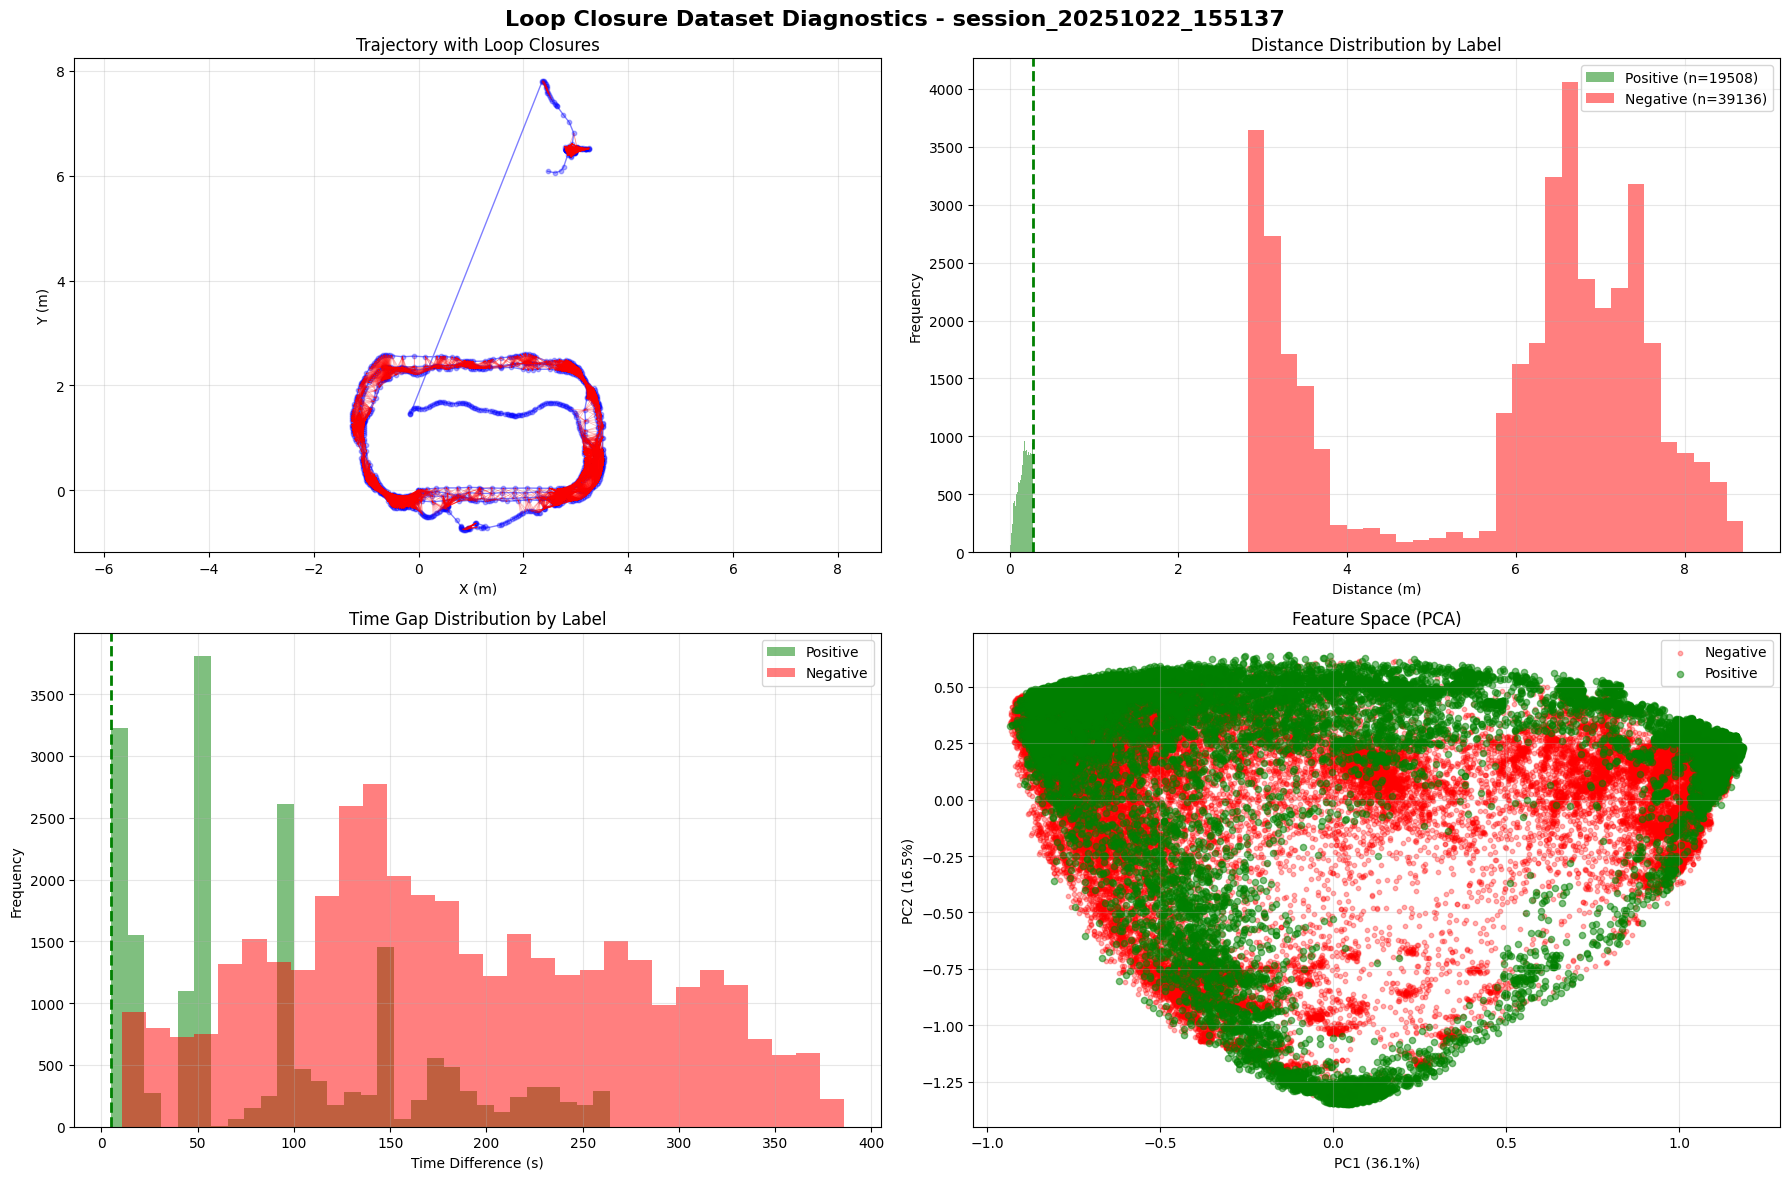

In [52]:
print("\n" + "="*70)
print("DIAGNOSTIC VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(f'Loop Closure Dataset Diagnostics - {SESSION_ID}', fontsize=16, fontweight='bold')

# Plot 1: Trajectory with loop closures
ax = axes[0, 0]
traj_x = df_trajectory['x_m'].values
traj_y = df_trajectory['y_m'].values
ax.plot(traj_x, traj_y, 'b-', alpha=0.5, linewidth=1, label='Trajectory')
ax.scatter(traj_x, traj_y, c='blue', s=10, alpha=0.3)

# Highlight positive pairs
for pair in train_dataset + val_dataset + test_dataset:
    if pair['label'] == 1:
        # Note: pair dict already has node1_id and node2_id from feature assembly
        n1 = df_trajectory[df_trajectory['node_id'] == pair['node1_id']].iloc[0]
        n2 = df_trajectory[df_trajectory['node_id'] == pair['node2_id']].iloc[0]
        ax.plot([n1['x_m'], n2['x_m']], [n1['y_m'], n2['y_m']], 'r-', alpha=0.3, linewidth=0.5)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Trajectory with Loop Closures')
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Plot 2: Distance distribution by type
ax = axes[0, 1]
pos_distances = [d['distance'] for d in dataset if d['label'] == 1]
neg_distances = [d['distance'] for d in dataset if d['label'] == 0]

ax.hist(pos_distances, bins=30, alpha=0.5, label=f'Positive (n={len(pos_distances)})', color='green')
ax.hist(neg_distances, bins=30, alpha=0.5, label=f'Negative (n={len(neg_distances)})', color='red')
ax.axvline(POSITIVE_DISTANCE_THRESHOLD, color='green', linestyle='--', linewidth=2)
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Frequency')
ax.set_title('Distance Distribution by Label')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Time difference distribution
ax = axes[1, 0]
pos_times = [d['time_diff'] for d in dataset if d['label'] == 1]
neg_times = [d['time_diff'] for d in dataset if d['label'] == 0]

ax.hist(pos_times, bins=30, alpha=0.5, label=f'Positive', color='green')
ax.hist(neg_times, bins=30, alpha=0.5, label=f'Negative', color='red')
ax.axvline(POSITIVE_TIME_GAP, color='green', linestyle='--', linewidth=2)
ax.set_xlabel('Time Difference (s)')
ax.set_ylabel('Frequency')
ax.set_title('Time Gap Distribution by Label')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Feature space (PCA)
ax = axes[1, 1]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pos_mask = y == 1
ax.scatter(X_pca[~pos_mask, 0], X_pca[~pos_mask, 1], c='red', alpha=0.3, s=10, label='Negative')
ax.scatter(X_pca[pos_mask, 0], X_pca[pos_mask, 1], c='green', alpha=0.5, s=20, label='Positive')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('Feature Space (PCA)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save figure
DIAGNOSTICS_FILE = os.path.join(BASE_PATH, 'dataset', 'dataset_diagnostics.png')
plt.savefig(DIAGNOSTICS_FILE, dpi=150, bbox_inches='tight')
print(f"\n✅ Diagnostic plots saved: {DIAGNOSTICS_FILE}")

plt.show()

### 9.10 Dataset Saving

In [53]:
print("Saving dataset...")

# Package dataset
dataset_package = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset,
    'metadata': {
        'session_id': SESSION_ID,
        'creation_date': str(np.datetime64('today')),
        'num_trajectory_nodes': len(df_trajectory),
        'num_valid_nodes': len(complete_alignments),
        'num_constraints': len(loop_closure_pairs),
        'feature_dim': X.shape[1],
        'random_seed': RANDOM_SEED,
        'config': {
            'max_time_offset': MAX_TIME_OFFSET,
            'positive_distance_threshold': POSITIVE_DISTANCE_THRESHOLD,
            'easy_negative_min_distance': EASY_NEGATIVE_MIN_DISTANCE,
            'hard_negative_min_distance': HARD_NEGATIVE_MIN_DISTANCE,
            'hard_negative_similarity_threshold': HARD_NEGATIVE_SIMILARITY_THRESHOLD,
            'max_constraint_residual': MAX_CONSTRAINT_RESIDUAL,
            'max_angular_distance': MAX_ANGULAR_DISTANCE
        }
    }
}

# Save to pickle
with open(DATASET_FILE, 'wb') as f:
    pickle.dump(dataset_package, f)

file_size_mb = os.path.getsize(DATASET_FILE) / (1024 * 1024)
print(f"\n✅ Dataset saved: {DATASET_FILE}")
print(f"   File size: {file_size_mb:.2f} MB")

Saving dataset...

✅ Dataset saved: dataset/loop_closure_dataset.pkl
   File size: 691.55 MB


---

## 9.11 PICKLE EXPORT DOCUMENTATION

---

### 9.11.1 Exported Pickle File Structure

The final output of Section 9 is a pickle file (`loop_closure_dataset.pkl`) containing a comprehensive, ready-to-train dataset for loop closure detection. This file packages all assembled features, labels, metadata, and configuration parameters into a single portable artifact.

---

**File Location:**
```
session_YYYYMMDD_HHMMSS/dataset/loop_closure_dataset.pkl
```

**File Format:** Python pickle (binary serialization)  
**Typical Size:** 50-500 MB depending on trajectory length and feature count  
**Compatibility:** Python 3.7+ with numpy, pandas

---

### 9.11.2 Top-Level Dictionary Structure

The pickle file contains a single Python dictionary with four top-level keys:

```
dataset_package = {
    'train': [list of training examples],
    'val': [list of validation examples],
    'test': [list of test examples],
    'metadata': {dictionary of dataset metadata}
}
```

---

### 9.11.3 Training/Validation/Test Split Structure

Each of the three splits ('train', 'val', 'test') contains a list of dictionaries, where each dictionary represents a single training example (node pair).

**Split Characteristics:**
- **'train'**: Typically 70% of total pairs (stratified by label and pair_type)
- **'val'**: Typically 15% of total pairs (stratified by label and pair_type)
- **'test'**: Typically 15% of total pairs (stratified by label and pair_type)

**Individual Example Structure:**

Each example in the train/val/test lists is a dictionary with the following fields:

| Field | Type | Shape/Value | Description |
|-------|------|-------------|-------------|
| `features` | numpy.ndarray | (3072,) float32 | Concatenated pairwise multi-modal features |
| `label` | int | 0 or 1 | Binary classification label (1=loop closure, 0=no loop) |
| `node1_id` | int | e.g., 42 | First trajectory node identifier |
| `node2_id` | int | e.g., 156 | Second trajectory node identifier |
| `distance` | float | meters | Euclidean distance between node poses |
| `time_diff` | float | seconds | Time difference between node timestamps |
| `pair_type` | str | 'positive'/'easy_negative'/'hard_negative' | Pair generation strategy |

**Feature Vector Composition:**

The `features` field is a 3072-dimensional concatenated vector:

```
features = [camera1 | lidar1 | camera2 | lidar2]
           [0:1280] [1280:1536] [1536:2816] [2816:3072]
```

- **Indices 0-1279**: Camera features for node1 (1280D MobileNetV2 embeddings, L2-normalized)
- **Indices 1280-1535**: LiDAR features for node1 (256D 1D-CNN descriptors, L2-normalized)
- **Indices 1536-2815**: Camera features for node2 (1280D MobileNetV2 embeddings, L2-normalized)
- **Indices 2816-3071**: LiDAR features for node2 (256D 1D-CNN descriptors, L2-normalized)

**Feature Properties:**
- All individual modality features are L2-normalized (unit length) before concatenation
- Concatenated vector is NOT re-normalized (length ≈ 2.0 for 4 unit vectors)
- Data type: numpy float32 for memory efficiency
- Features are ready for direct input to neural network without additional preprocessing

**Label Encoding:**
- **label=1**: Positive example (true loop closure)
  - Node pair corresponds to INTER_SUBMAP constraint from Cartographer
  - Spatial distance < positive_distance_threshold (typically ~2m)
  - Temporal gap > positive_time_gap (typically >5s)
  - High-confidence ground truth from SLAM optimization

- **label=0**: Negative example (no loop closure)
  - Either 'easy_negative' (spatially distant, >5m) OR
  - 'hard_negative' (perceptually similar but spatially distant, >3m)
  - No corresponding INTER_SUBMAP constraint

**Pair Type Categories:**
- **'positive'**: True loop closures (~30% of dataset)
- **'easy_negative'**: Spatially and temporally distant pairs (~35% of dataset)
- **'hard_negative'**: High feature similarity but spatially distinct (~35% of dataset)

---

### 9.11.4 Metadata Dictionary Structure

The `'metadata'` key contains a nested dictionary with comprehensive information about dataset generation, configuration, and statistics.

**Top-Level Metadata Fields:**

| Field | Type | Description | Example |
|-------|------|-------------|----------|
| `session_id` | str | Unique session identifier | 'session_20241113_143052' |
| `creation_date` | str | Dataset creation timestamp (ISO format) | '2024-11-13' |
| `num_trajectory_nodes` | int | Total SLAM trajectory nodes in session | 487 |
| `num_valid_nodes` | int | Nodes with complete feature alignments | 423 |
| `num_constraints` | int | INTER_SUBMAP constraints (ground truth loops) | 78 |
| `feature_dim` | int | Concatenated feature vector dimension | 3072 |
| `random_seed` | int | Random seed for reproducible splitting | 42 |
| `config` | dict | Nested dictionary of generation parameters | (see below) |

**Session Information:**
- `session_id`: Unique identifier linking dataset to source ROS bag and pbstream files
- `creation_date`: Timestamp of dataset assembly completion
- Enables traceability back to original sensor data and SLAM outputs

**Node Statistics:**
- `num_trajectory_nodes`: Total nodes extracted from Cartographer pbstream
- `num_valid_nodes`: Nodes with both camera and LiDAR features within temporal alignment threshold
- Alignment coverage = (num_valid_nodes / num_trajectory_nodes) × 100%
- Only valid nodes can participate in labeled pairs

**Ground Truth Statistics:**
- `num_constraints`: Number of INTER_SUBMAP constraints from Cartographer
- These constraints provide high-confidence positive labels
- Represent locations where SLAM successfully detected loop closures via scan matching

**Feature Dimension:**
- `feature_dim`: Always 3072 for current pipeline configuration
- Composition: (1280 camera + 256 lidar) × 2 nodes = 3072 total
- Used for validation and consistency checking in training pipeline

**Reproducibility:**
- `random_seed`: Seed used for stratified train/val/test splitting
- Enables exact reproduction of dataset splits from same parquet files
- Critical for experiment reproducibility and fair model comparison

---

### 9.11.5 Configuration Parameters

The `'config'` sub-dictionary within metadata contains all threshold and constraint parameters used during dataset generation in Section 8.

**Configuration Fields:**

| Parameter | Type | Description | Typical Value |
|-----------|------|-------------|---------------|
| `max_time_offset` | float | Maximum temporal alignment offset (seconds) | 0.7 |
| `positive_distance_threshold` | float | Maximum spatial distance for positive pairs (meters) | 2.0 |
| `easy_negative_min_distance` | float | Minimum distance for easy negative pairs (meters) | 5.0 |
| `hard_negative_min_distance` | float | Minimum distance for hard negative pairs (meters) | 3.0 |
| `hard_negative_similarity_threshold` | float | Minimum cosine similarity for hard negatives | 0.7 |
| `max_constraint_residual` | float | Maximum residual error for INTER_SUBMAP constraints | 0.5 |
| `max_angular_distance` | float | Maximum angular distance for positive pairs (radians) | 0.785 (≈45°) |

**Parameter Descriptions:**

**Temporal Alignment:**
- `max_time_offset`: Maximum allowed time difference between feature timestamp and trajectory node timestamp
- Features must be captured within ±700ms of trajectory node to be considered aligned
- Balances temporal precision with sensor capture rates
- Tighter thresholds reduce alignment coverage but improve temporal accuracy

**Positive Pair Criteria:**
- `positive_distance_threshold`: Maximum Euclidean distance between node poses for a pair to be considered a loop closure
- INTER_SUBMAP constraints provide initial candidates, distance threshold filters false positives
- Typical value ~2m reflects Cartographer's loop closure detection range and localization accuracy
- Pairs exceeding this distance are rejected even if INTER_SUBMAP constraint exists

- `max_constraint_residual`: Maximum optimization residual error for accepted INTER_SUBMAP constraints
- Residual measures alignment quality after pose graph optimization
- Lower residuals indicate higher confidence loop closures
- Filters weak or ambiguous loop closure detections

- `max_angular_distance`: Maximum angular difference (yaw) between node orientations for positive pairs
- Ensures robot is facing similar direction when revisiting location
- Typical value ~45° allows moderate orientation variation
- Prevents matching locations approached from opposite directions

**Negative Pair Generation:**
- `easy_negative_min_distance`: Minimum spatial separation for easy negative pairs
- Easy negatives are spatially distant and perceptually dissimilar
- Typical value >5m ensures clear spatial separation
- Provides baseline discriminative signal for classifier training

- `hard_negative_min_distance`: Minimum spatial separation for hard negative pairs
- Hard negatives are perceptually similar but spatially distinct
- Typical value ~3-4m creates challenging examples near decision boundary
- Forces network to learn subtle discriminative features beyond surface similarity

- `hard_negative_similarity_threshold`: Minimum cosine similarity for hard negative candidate selection
- Computed from concatenated camera+lidar features
- Typical value ~0.7 identifies pairs with strong perceptual resemblance
- Higher thresholds select more difficult hard negatives

**Impact on Dataset Characteristics:**
- Stricter thresholds reduce dataset size but improve label quality
- Looser thresholds increase dataset size but may introduce label noise
- Configuration preserved in metadata enables analysis of threshold sensitivity
- Parameters can be tuned based on robot platform, environment complexity, and SLAM performance

---

### 9.11.6 Dataset Statistics and Properties

**Split Distribution:**
- Stratified sampling ensures balanced representation across splits
- Label distribution (positive/negative) maintained within ±2% across splits
- Pair type distribution (positive/easy/hard) maintained within ±3% across splits
- No data leakage: node pairs are exclusive to single split

**Label Balance:**
- Typical distribution: ~30% positive (label=1), ~70% negative (label=0)
- Class imbalance reflects real-world deployment scenarios
- Positive pairs limited by number of INTER_SUBMAP constraints from SLAM
- Negative pairs generated to balance dataset while maintaining difficulty spectrum

**Feature Quality:**
- All features L2-normalized at extraction time
- Feature variance checked during assembly (low-variance features flagged)
- No NaN or infinite values (validated before inclusion)
- Temporal alignment quality recorded in metadata

**Memory Characteristics:**
- Each example: ~12 KB (3072 float32 features + metadata)
- Typical dataset: 2,000-10,000 total examples
- File size: 50-500 MB depending on trajectory length
- Pickle format enables fast loading but is Python-specific

**Data Integrity:**
- All node_ids reference valid trajectory nodes
- All distances and time_diffs computed from verified trajectory data
- Feature indices validated against features.h5 array bounds
- No duplicate pairs within or across splits

---

### 9.11.7 Usage Considerations

**Training Pipeline Integration:**
- Pickle file is self-contained and portable
- Can be loaded directly into PyTorch/TensorFlow data loaders
- Features are pre-normalized and ready for network input
- No additional preprocessing required beyond framework-specific tensor conversion

**Compatibility:**
- Python 3.7+ required
- Dependencies: numpy, pandas (for metadata manipulation)
- Pickle protocol: Highest available (optimized for Python 3.8+)
- Cross-platform compatible (Windows/Linux/macOS)

**Storage and Transfer:**
- Pickle files are binary and compressed via pickle protocol
- Additional compression (gzip) can reduce size by ~30-50% if needed
- Files are version-controlled alongside code for reproducibility
- Cloud storage friendly (S3, GCS) for distributed training

**Validation and Quality Checks:**
- Feature dimension consistency validated at save time
- Label distribution statistics computed and stored in metadata
- Split sizes validated against stratification targets
- Referential integrity between node_ids and source data verified

**Limitations:**
- Pickle format is Python-specific (not language-agnostic)
- Large datasets may cause memory pressure when fully loaded
- No incremental/streaming access (entire file must be unpickled)
- Pickle security: Only load files from trusted sources

**Alternative Export Formats:**
While this pipeline uses pickle for convenience, the assembled data could alternatively be exported as:
- HDF5 for language-agnostic access and memory-mapped loading
- TFRecord for TensorFlow pipeline optimization
- Parquet for SQL-queryable feature storage
- NPZ for numpy-native compressed arrays

---

**End of Section 9 Documentation**